In [ ]:
# This script validates the mizuRoute/RBM model
# By Dylan Blaskey
# Started: 3/28/23

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import hydroeval as he
import xarray as xr
import random
import seaborn as sns
import datetime as dt
import glob
import matplotlib.pyplot as plt
import statistics
import os
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('/glade/work/dblaskey/RBM_opt_code/src')
import gp
import sampling
import shapely.geometry as sg

# River Routing

## Construct Data

In [ ]:
df_sites = pd.read_csv('/glade/scratch/dblaskey/RBM/calibration_points.csv', index_col=0)
# Read in Observed Data
Q_data = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Q_sites_daily.csv', index_col=0)

df = pd.merge(Q_data, df_sites, on="site_no")
df = df[df['type'] != "Temperature Gage Only"]
df = df.drop(columns=['obs_no_year.x', 'obs_no_year.y'])

start_date = '1990-01-01'
end_date = '2021-09-30'
years = range(2013,2022)
time_series = pd.date_range(start_date, end_date)

In [188]:
df_sites = pd.read_csv('/glade/scratch/dblaskey/RBM/calibration_points.csv', index_col=0)
df_sites

station_nm        Lat        Long  \
site_no                                                                       
15803000                       MEADE R AT ATKASUK AK  70.495376 -157.395848   
15896000                   KUPARUK R NR DEADHORSE AK  70.281385 -148.962786   
15875000                      COLVILLE R AT UMIAT AK  69.360500 -152.122694   
15908000            SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   
15747000           WULIK R BL TUTAK C NR KIVALINA AK  67.875440 -163.677373   
15453500               YUKON R NR STEVENS VILLAGE AK  65.875101 -149.720349   
15519100     TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841 -148.631114   
15356000                         YUKON R AT EAGLE AK  64.789168 -141.200089   
15580095        NIUKLUK R AB MELSING C AT COUNCIL AK  64.891944 -163.670000   
15493000                    CHENA R NR TWO RIVERS AK  64.901972 -146.361333   
15511000                   L CHENA R NR FAIRBANKS AK  64.885690 -147.249648   
15515500                       TANANA R AT NENANA AK  64.564944 -149.094000   
15348000              FORTYMILE R NR STEELE CREEK AK  64.308855 -141.404517   
15484000                    SALCHA R NR SALCHAKET AK  64.471528 -146.928056   
15477740                GOODPASTER R NR BIG DELTA AK  64.450174 -144.944572   
15292000                  SUSITNA R AT GOLD CREEK AK  62.767290 -149.693379   
15200280                   GULKANA R AT SOURDOUGH AK  62.520392 -145.533015   
15292700                 TALKEETNA R NR TALKEETNA AK  62.346439 -150.019201   
15565447                 YUKON R AT PILOT STATION AK  61.933687 -162.882936   
15294005                       WILLOW C NR WILLOW AK  61.780303 -149.886679   
15283700                        MOOSE C NR PALMER AK  61.684389 -149.052417   
15284000                    MATANUSKA R AT PALMER AK  61.608631 -149.073043   
15266300                      KENAI R AT SOLDOTNA AK  60.476929 -151.081668   
15266110  KENAI R BL SKILAK LK OUTLET NR STERLING AK  60.466099 -150.601090   
15258000                KENAI R AT COOPER LANDING AK  60.492193 -149.809920   
15243900                         SNOW R NR SEWARD AK  60.294440 -149.346040   
15302000                  NUYAKUK R NR DILLINGHAM AK  59.934830 -158.190006   
15300300                   ILIAMNA R NR PEDRO BAY AK  59.757950 -153.846887   

             COMID  drain_area_va    unitarea  \
site_no                                         
15803000  81000092         1790.0  111.404842   
15896000  81000403         3340.0   17.736153   
15875000  81001684        13860.0   25.223510   
15908000  81002548         1850.0   88.189503   
15747000  81005569          705.0   38.865035   
15453500  81010219       194000.0   18.777725   
15519100  81012001          243.0   22.772364   
15356000  81014243       111600.0   53.018321   
15580095  81014331          707.0    6.200221   
15493000  81014458          934.0   95.261951   
15511000  81014548          372.0   18.488819   
15515500  81015538        25560.0    3.930487   
15348000  81015554         5850.0   48.648964   
15484000  81015621         2200.0   38.261048   
15477740  81015760          676.0  100.684092   
15292000  81021815         6130.0    5.910127   
15200280  81023679         1760.0   26.970817   
15292700  81023793         2010.0   47.030757   
15565447  81025423       318300.0   41.436845   
15294005  81026220          167.0   16.780732   
15283700  81026903           48.4  130.363903   
15284000  81027556         2060.0   80.809427   
15266300  81030914         2020.0    9.506205   
15266110  81030921         1250.0   12.225572   
15258000  81030990          643.0   56.179499   
15243900  81032646          150.0   47.620472   
15302000  81034003         1510.0   18.392804   
15300300  81034272          129.0    6.696922   

                                                   geometry  outlet_comid  \
site_no                                                                     
15803000  POLYGON ((-157.38875 70.517916666666

In [190]:
len(df_sites[df_sites['type'] != "Temperature Gage Only"])

27

In [ ]:
cfs_2_cms = 0.028316847
outlets = np.unique(df.outlet_comid.values)

list_kge = []
list_pbias = []
list_comid = []
list_outlet = []

for outlet in outlets:
    gages = df_sites.loc[df_sites['outlet_comid'] == outlet]
    comids = gages.COMID.values
    site_nos = gages.index.values
    
    ds_rasm_flow = xr.open_mfdataset('/glade/work/dblaskey/mizuRoute_Output/daily/AK_Rivers_%s.h.*'%outlet)
    reachID_list = ds_rasm_flow.reachID.isel(time=0)
    
    for i,comid in enumerate(comids):
        seg_sel = np.where(reachID_list == comid)[0][0]
        sim_flow = ds_rasm_flow.IRFroutedRunoff.sel(seg=seg_sel)/cfs_2_cms
        sim_flow.load()
        sim_df = pd.DataFrame(sim_flow, index=time_series, columns=['sim'])
        sim_df.index.name = 'Date'

        # Filter to just one gage for observations
        Q_df = df[df['site_no'] == site_nos[i]][['X_00060_00003', 'Date']]
        Q_df = Q_df.rename(columns={"X_00060_00003": "obs"})
        Q_df = Q_df.set_index('Date')
        Q_df.index = pd.to_datetime(Q_df.index)

        # Combine simulation and observation datasets
        df_concat = pd.concat([sim_df,Q_df],axis=1)
        df_concat = df_concat.dropna()
        df_concat = df_concat.loc['2013-10-01':'2021-09-30']
        df_concat = df_concat[df_concat.index.month.isin([5,6,7,8,9])]
        df_concat = df_concat.reset_index()
        df_concat['JDay'] = pd.to_datetime(df_concat.Date).dt.dayofyear
        
        plot_df = df_concat.groupby(df_concat.JDay).mean()
        plt.figure(dpi=300)
        plt.plot(plot_df.index.values, plot_df['sim'],c='dodgerblue')
        plt.plot(plot_df.index.values, plot_df['obs'],c='orangered')
        plt.legend(['RASM-CTSM','OBS-USGS'])
        plt.title(gages.station_nm.values[i])
        plt.xlabel('month')
        plt.ylabel('monthly flow (cfs)')
        plt.savefig('/glade/u/home/dblaskey/Figures/Discharge_%s_Validation_DOY.png'%site_nos[i])
        
        list_kge.append(he.evaluator(he.kge, df_concat.sim.values, df_concat.obs.values)[0])
        list_pbias.append(he.evaluator(he.pbias, df_concat.sim.values, df_concat.obs.values)[0])
        list_comid.append(np.int(comid))
        list_outlet.append(outlet)

In [ ]:
val_results = pd.DataFrame({'KGE':np.concatenate(list_kge, axis=0), 'PBias':list_pbias, 'COMID':list_comid, 'outlet_id': list_outlet})
val_results

In [ ]:
list_kge = []
list_pbias = []
list_comid = []
list_outlet = []
list_m = []

for outlet in outlets:
    gages = df_sites.loc[df_sites['outlet_comid'] == outlet]
    comids = gages.COMID.values
    site_nos = gages.index.values
    
    ds_rasm_flow = xr.open_mfdataset('/glade/work/dblaskey/mizuRoute_Output/daily/AK_Rivers_%s.h.*'%outlet)
    reachID_list = ds_rasm_flow.reachID.isel(time=0)
    
    for i,comid in enumerate(comids):
        seg_sel = np.where(reachID_list == comid)[0][0]
        sim_flow = ds_rasm_flow.IRFroutedRunoff.sel(seg=seg_sel)/cfs_2_cms
        sim_flow.load()
        sim_df = pd.DataFrame(sim_flow, index=time_series, columns=['sim'])
        sim_df.index.name = 'Date'

        # Filter to just one gage for observations
        Q_df = df[df['site_no'] == site_nos[i]][['X_00060_00003', 'Date']]
        Q_df = Q_df.rename(columns={"X_00060_00003": "obs"})
        Q_df = Q_df.set_index('Date')
        Q_df.index = pd.to_datetime(Q_df.index)

        # Combine simulation and observation datasets
        df_concat = pd.concat([sim_df,Q_df],axis=1)
        df_concat = df_concat.dropna()
        df_concat = df_concat.loc['2013-10-01':'2021-09-30']
        
        for m in range(5,10):
            df_concat_m = df_concat[df_concat.index.month == m]
            df_concat_m = df_concat_m.reset_index()

            list_kge.append(he.evaluator(he.kge, df_concat_m.sim.values, df_concat_m.obs.values)[0])
            list_pbias.append(he.evaluator(he.pbias, df_concat_m.sim.values, df_concat_m.obs.values)[0])
            list_comid.append(np.int(comid))
            list_outlet.append(outlet)
            list_m.append(m)

In [ ]:
val_results_m = pd.DataFrame({'KGE':np.concatenate(list_kge, axis=0), 'PBias':list_pbias, 
                              'COMID':list_comid, 'outlet_id': list_outlet, 'Month': list_m})
val_results_m

In [ ]:
val_results_m.to_csv('/glade/u/home/dblaskey/RBM/Validation/Val_flow_month.csv', index=False)
val_results.to_csv('/glade/u/home/dblaskey/RBM/Validation/Val_flow_annual.csv', index=False)

## Plot Data

In [4]:
val_results_m = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_flow_month.csv')
val_results = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_flow_annual.csv')

In [7]:
for m in [5,6,7,8,9]:
    temporary = val_results_m[val_results_m['Month'] == m]
    print(temporary.KGE.max(), temporary.KGE.min(), temporary.KGE.mean(), temporary.PBias.mean())

0.802999981273552 -0.7506160884645585 0.2648495857837726 -24.795409649430127
0.6419404472403356 -0.3842896908993951 0.2195620730502359 -14.362723508105928
0.6185534508337321 -3.191295283486949 -0.16561776623280888 -28.215844571922865
0.6535051428196127 -0.9672929845921876 0.18175939460037657 -0.9596805742190229
0.7358910624408476 -1.3626456601166101 0.1455258800464584 14.847124032904613


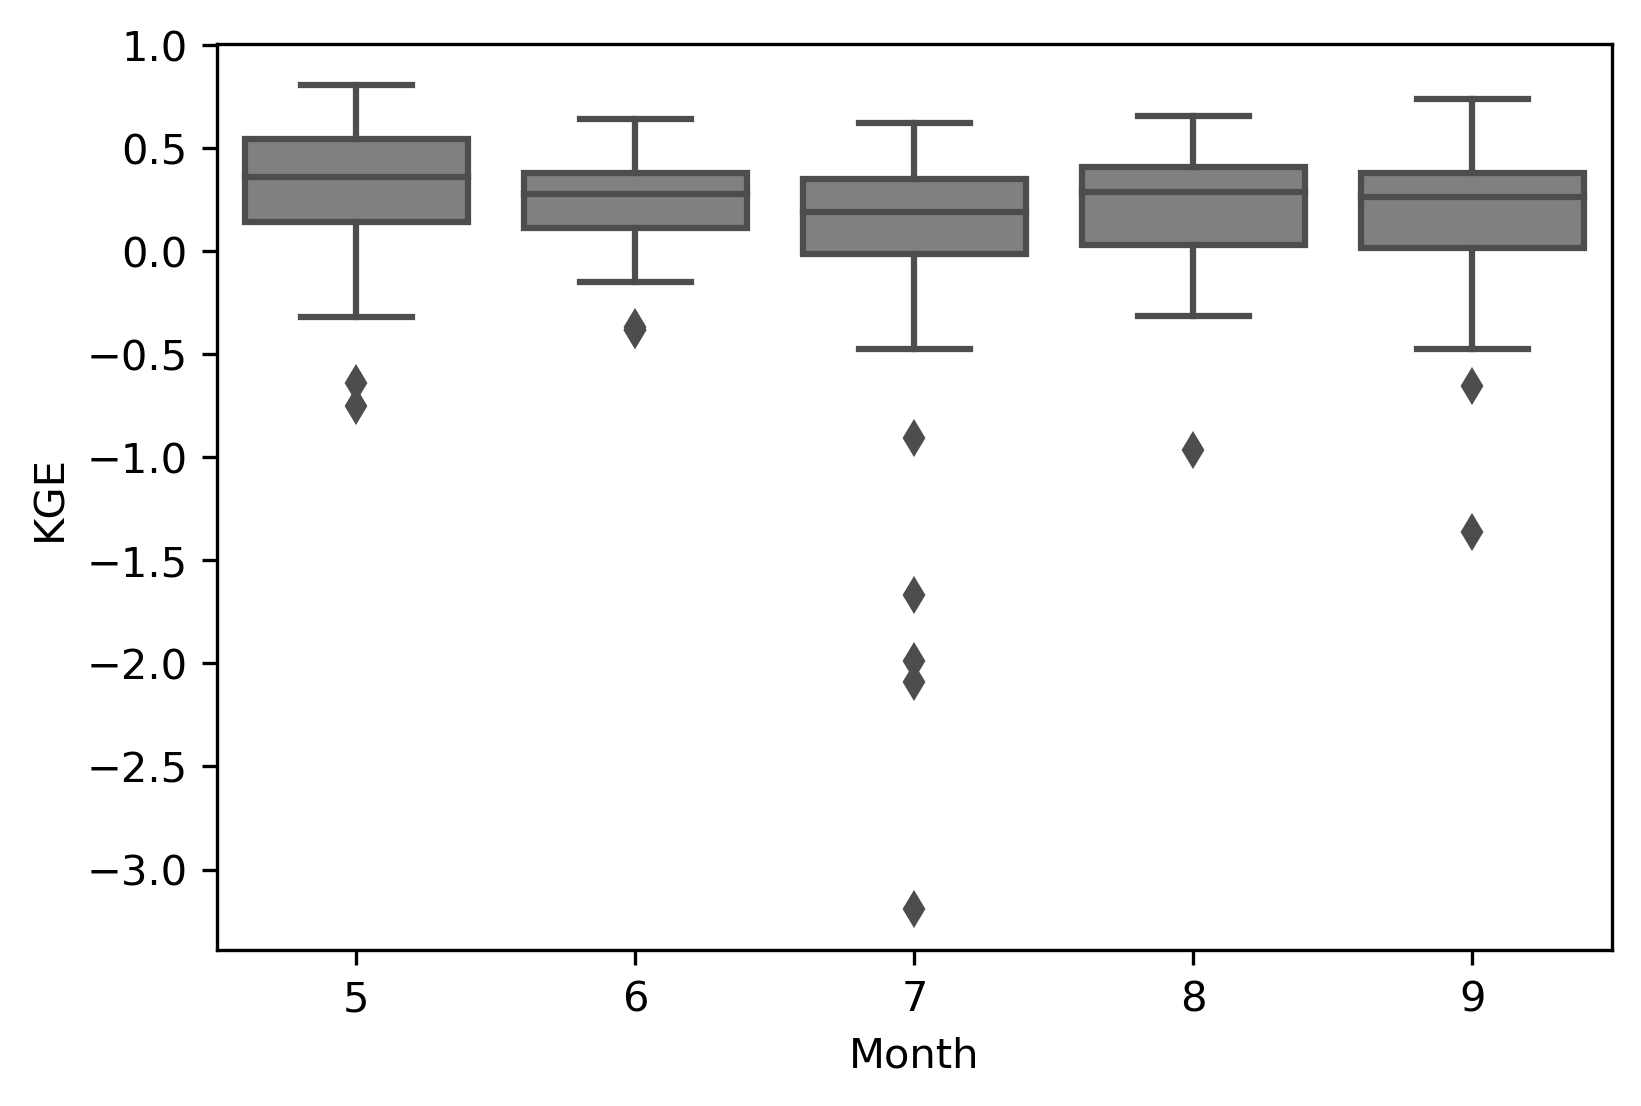

In [141]:
df_reduced = val_results_m[['KGE', 'COMID', 'Month']]
plt.figure(dpi=300)
ax = sns.boxplot(x="Month", y="KGE", data=df_reduced, color='grey')  # RUN PLOT
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/mizu_KGE.png", dpi='figure')
plt.show()

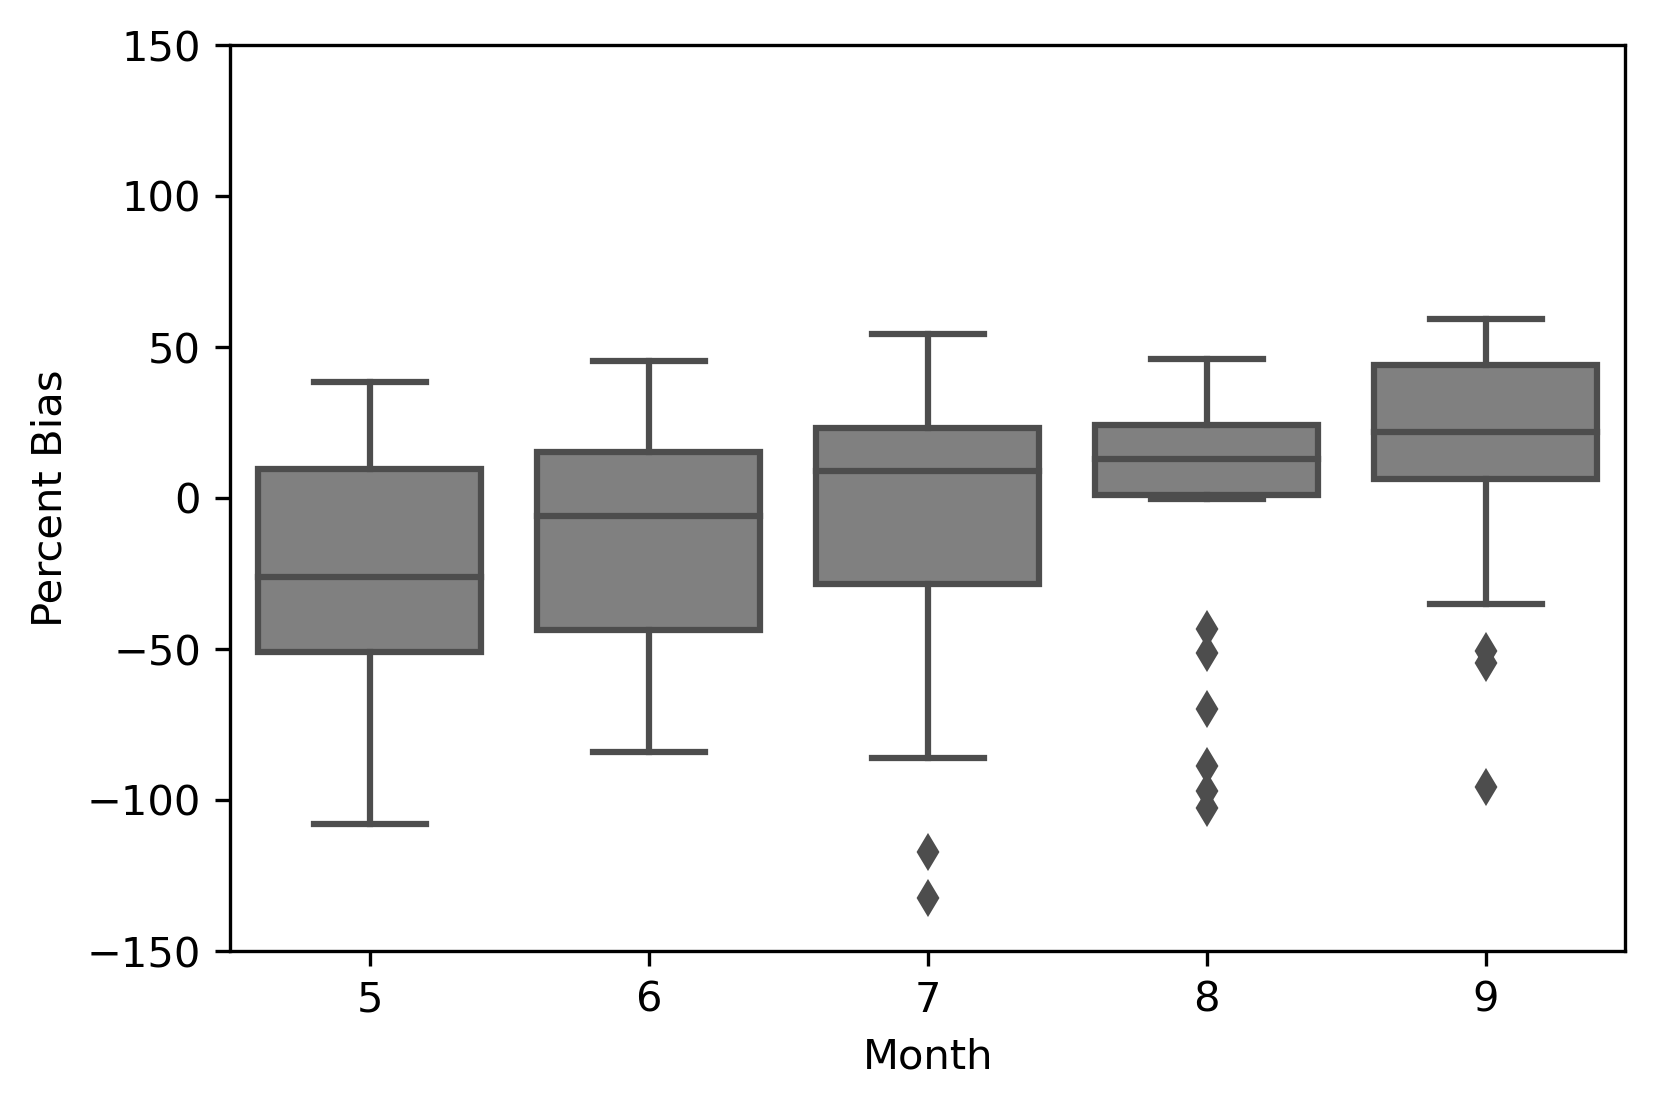

In [157]:
df_reduced = val_results_m[['PBias', 'COMID', 'Month']]
plt.figure(dpi=300)
ax = sns.boxplot(x="Month", y="PBias", data=df_reduced, color='grey')  # RUN PLOT
ax.set_ylim([-150, 150])
plt.ylabel('Percent Bias')
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/mizu_bias.png", dpi='figure')
#ax = sn.violinplot(x="Month", y="PBias", data=df_reduced)
plt.show()

In [83]:
gdf = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/cb_2018_us_state_500k.shp')
ak_map = gdf[gdf['NAME']=="Alaska"]

In [30]:
df_site_sel = pd.read_csv('/glade/scratch/dblaskey/RBM/USGS_COMID_list.csv')
df_site_sel

Unnamed: 0   site_no                          station_nm        Lat  \
0            0  15803000               MEADE R AT ATKASUK AK  70.495376   
1            1  15896000           KUPARUK R NR DEADHORSE AK  70.281385   
2            2  15875000              COLVILLE R AT UMIAT AK  69.360500   
3            3  15908000    SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833   
4            4  15747000   WULIK R BL TUTAK C NR KIVALINA AK  67.875440   
..         ...       ...                                 ...        ...   
60          60  15087300            FALLS C NR PETERSBURG AK  56.681869   
61          61  15100000              TAKATZ C NR BARANOF AK  57.142716   
62          62  15100000              TAKATZ C NR BARANOF AK  57.142716   
63          63  15087610             NAKWASINA R NR SITKA AK  57.259924   
64          64  15106920  KADASHAN R AB HOOK C NR TENAKEE AK  57.662435   

          Long     COMID  drain_area_va    unitarea  \
0  -157.395848  81000092         1790.0  111.404842   
1  -148.962786  81000403         3340.0   17.736153   
2  -152.122694  81001684        13860.0   25.223510   
3  -148.817778  81002548         1850.0   88.189503   
4  -163.677373  81005569          705.0   38.865035   
..         ...       ...            ...         ...   
60 -132.923943  81036098           17.4   43.866499   
61 -134.865642  81036098           17.4   43.866499   
62 -134.865642  81036098           17.4   43.866499   
63 -135.333427  81036153           32.0   83.618755   
64 -135.186782  81036162           10.3   27.905819   

                                             geometry  outlet_comid  
0   POLYGON ((-157.38875 70.51791666666666, -157.3...      81000005  
1   POLYGON ((-148.96375 70.36125, -148.9604166666...      81000402  
2   POLYGON ((-152.12375 69.42041666666667, -152.1...      81000069  
3   POLYGON ((-148.7429166666667 69.08458333333334...      81000433  
4   POLYGON ((-163.7229166666667 67.95625000000001...      81005554  
..                                                ...           ...  
60  MULTIPOLYGON (((-134.0954166666667 59.03958333...      81020021  
61  MULTIPOLYGON (((-134.0954166666667 59.03958333...      81020021  
62  MULTIPOLYGON (((-134.0954166666667 59.03958333...      81020021  
63  MULTIPOLYGON (((-134.2354166666667 59.09208333...      81020021  
64  MULTIPOLYGON (((-134.0270833333334 59.05125000...      81020021  

[65 rows x 10 columns]

In [31]:
plot_df = val_results.merge(df_site_sel)
plot_df

KGE       PBias     COMID  outlet_id  Unnamed: 0   site_no  \
0  -0.223186 -104.177283  81000092   81000005           0  15803000   
1   0.329357  -16.892826  81001684   81000069           2  15875000   
2   0.224356  -19.995075  81000403   81000402           1  15896000   
3   0.654093    1.324194  81002548   81000433           3  15908000   
4   0.484373    0.643335  81005569   81005554           4  15747000   
5   0.356092  -24.315084  81010219   81020021           5  15453500   
6   0.455427   35.255535  81012001   81020021           8  15519100   
7   0.030550  -30.033199  81014243   81020021          11  15356000   
8   0.393468   21.513995  81014458   81020021          13  15493000   
9   0.014650   17.535329  81014548   81020021          14  15511000   
10  0.596357    2.444512  81015538   81020021          15  15515500   
11  0.515919   21.003835  81015554   81020021          16  15348000   
12  0.448214   18.373715  81015621   81020021          18  15484000   
13  0.415657    5.534699  81015760   81020021          20  15477740   
14  0.411081  -19.786905  81025423   81020021          33  15565447   
15  0.497676   -1.826958  81021815   81027459          24  15292000   
16  0.513093   -2.439862  81023793   81027459          30  15292700   
17 -0.384767  -69.091312  81026220   81027459          37  15294005   
18 -0.334617  -60.189776  81026903   81027546          38  15283700   
19  0.507675   19.391415  81027556   81027546          42  15284000   
20 -0.288458  -62.976876  81023679   81030789          27  15200280   
21  0.573030    9.518621  81030914   81030912          43  15266300   
22  0.514395   11.300747  81030921   81030912          44  15266110   
23  0.488585   11.145430  81030990   81030912          45  15258000   
24  0.110641   37.770526  81032646   81030912          47  15243900   
25  0.558227   -2.204810  81034003   81035777          50  15302000   
26  0.627984  -13.717549  81034272   81035794          52  15300300   

                                    station_nm        Lat        Long  \
0                        MEADE R AT ATKASUK AK  70.495376 -157.395848   
1                       COLVILLE R AT UMIAT AK  69.360500 -152.122694   
2                    KUPARUK R NR DEADHORSE AK  70.281385 -148.962786   
3             SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   
4            WULIK R BL TUTAK C NR KIVALINA AK  67.875440 -163.677373   
5                YUKON R NR STEVENS VILLAGE AK  65.875101 -149.720349   
6      TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841 -148.631114   
7                          YUKON R AT EAGLE AK  64.789168 -141.200089   
8                     CHENA R NR TWO RIVERS AK  64.901972 -146.361333   
9                    L CHENA R NR FAIRBANKS AK  64.885690 -147.249648   
10                       TANANA R AT NENANA AK  64.564944 -149.094000   
11              FORTYMILE R NR STEELE CREEK AK  64.308855 -141.404517   
12                    SALCHA R NR SALCHAKET AK  64.471528 -146.928056   
13                GOODPASTER R NR BIG DELTA AK  64.450174 -144.944572   
14                 YUKON R AT PILOT STATION AK  61.933687 -162.882936   
15                  SUSITNA R AT GOLD CREEK AK  62.767290 -149.693379   
16                 TALKEETNA R NR TALKEETNA AK  62.346439 -150.019201   
17                       WILLOW C NR WILLOW AK  61.780303 -149.886679   
18                        MOOSE C NR PALMER AK  61.684389 -149.052417   
19                    MATANUSKA R AT PALMER AK  61.608631 -149.073043   
20                   GULKANA R AT SOURDOUGH AK  62.520392 -145.533015   
21                      KENAI R AT SOLDOTNA AK  60.476929 -151.081668   
22  KENAI R BL SKILAK LK OUTLET NR STERLING AK  60.466099 -150.601090   
23                KENAI R AT COOPER LANDING AK  60.492193 -149.809920   
24                         SNOW R NR SEWARD AK  60.294440 -149.346040   
25                  NUYAKUK R NR DILLINGHAM AK  59.934830 -158.190006   
26                   ILIAMNA R NR PEDRO BAY AK  5

In [94]:
for comid in [81014324]: #np.unique(points.outlet_id.values):
    shape_file = gpd.read_file('/glade/scratch/dblaskey/RBM/Shapefiles/subbasin_{}.gpkg'.format(comid)) 
    shape_file['group'] = 1
    dissolved = shape_file.dissolve(by='group')
    dissolved.to_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/subbasin_{}.gpkg'.format(comid), driver='GPKG')

(55.0, 72.0)

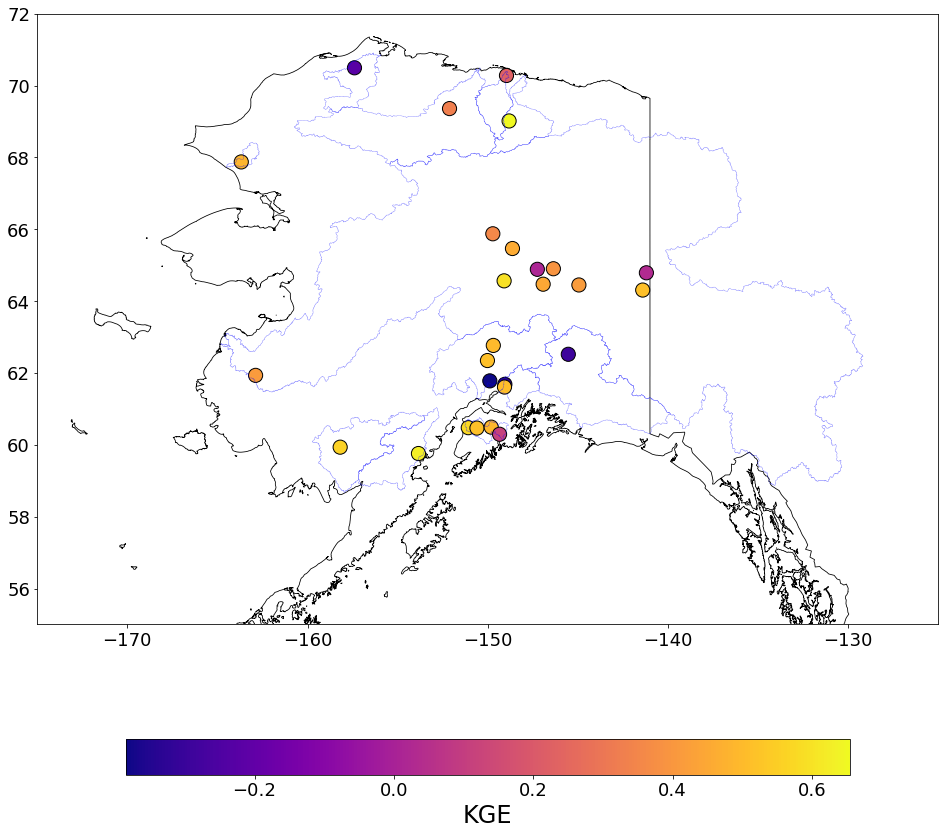

In [90]:
#color_values = iter(['blue', 'orange', 'green'])
fig, ax = plt.subplots(1, figsize=(18, 14))
# Plot Alaska and Yukon Outline
base_plot = ak_map.plot(linewidth=0.8, ax=ax, facecolor="none", 
              edgecolor='black')
base_plot.tick_params(labelsize=18)

for comid in np.unique(val_results_m.outlet_id.values):
    shape_file = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/subbasin_{}.gpkg'.format(comid)) 
    dissolved=shape_file.exterior
    dissolved.plot(linewidth=0.4, ax=ax, alpha=0.4, facecolor="none", edgecolor='blue')

#ax.plot(plot_df.Long, plot_df.Lat, marker='o', linestyle='', markersize=8, c=plot_df.KGE)\
points = ax.scatter(plot_df.Long, plot_df.Lat, c=plot_df.KGE, s=200, cmap="plasma", alpha=1, edgecolor='black')
cbar = fig.colorbar(points, orientation="horizontal", fraction=0.037*18/14) 
cbar.set_label(label='KGE', size=24)
cbar.ax.tick_params(labelsize=18)

#plt.legend()
plt.xlim([-175, -125])
plt.ylim([55, 72])

In [92]:
points = pd.read_csv('/glade/scratch/dblaskey/RBM/calibration_points.csv')

In [93]:
points

site_no                                  station_nm        Lat  \
0   15803000                       MEADE R AT ATKASUK AK  70.495376   
1   15896000                   KUPARUK R NR DEADHORSE AK  70.281385   
2   15875000                      COLVILLE R AT UMIAT AK  69.360500   
3   15908000            SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833   
4   15747000           WULIK R BL TUTAK C NR KIVALINA AK  67.875440   
5   15453500               YUKON R NR STEVENS VILLAGE AK  65.875101   
6   15519100     TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841   
7   15356000                         YUKON R AT EAGLE AK  64.789168   
8   15580095        NIUKLUK R AB MELSING C AT COUNCIL AK  64.891944   
9   15493000                    CHENA R NR TWO RIVERS AK  64.901972   
10  15511000                   L CHENA R NR FAIRBANKS AK  64.885690   
11  15515500                       TANANA R AT NENANA AK  64.564944   
12  15348000              FORTYMILE R NR STEELE CREEK AK  64.308855   
13  15484000                    SALCHA R NR SALCHAKET AK  64.471528   
14  15477740                GOODPASTER R NR BIG DELTA AK  64.450174   
15  15292000                  SUSITNA R AT GOLD CREEK AK  62.767290   
16  15200280                   GULKANA R AT SOURDOUGH AK  62.520392   
17  15292700                 TALKEETNA R NR TALKEETNA AK  62.346439   
18  15565447                 YUKON R AT PILOT STATION AK  61.933687   
19  15294005                       WILLOW C NR WILLOW AK  61.780303   
20  15283700                        MOOSE C NR PALMER AK  61.684389   
21  15284000                    MATANUSKA R AT PALMER AK  61.608631   
22  15266300                      KENAI R AT SOLDOTNA AK  60.476929   
23  15266110  KENAI R BL SKILAK LK OUTLET NR STERLING AK  60.466099   
24  15258000                KENAI R AT COOPER LANDING AK  60.492193   
25  15243900                         SNOW R NR SEWARD AK  60.294440   
26  15302000                  NUYAKUK R NR DILLINGHAM AK  59.934830   
27  15300300                   ILIAMNA R NR PEDRO BAY AK  59.757950   

          Long     COMID  drain_area_va    unitarea  \
0  -157.395848  81000092         1790.0  111.404842   
1  -148.962786  81000403         3340.0   17.736153   
2  -152.122694  81001684        13860.0   25.223510   
3  -148.817778  81002548         1850.0   88.189503   
4  -163.677373  81005569          705.0   38.865035   
5  -149.720349  81010219       194000.0   18.777725   
6  -148.631114  81012001          243.0   22.772364   
7  -141.200089  81014243       111600.0   53.018321   
8  -163.670000  81014331          707.0    6.200221   
9  -146.361333  81014458          934.0   95.261951   
10 -147.249648  81014548          372.0   18.488819   
11 -149.094000  81015538        25560.0    3.930487   
12 -141.404517  81015554         5850.0   48.648964   
13 -146.928056  81015621         2200.0   38.261048   
14 -144.944572  81015760          676.0  100.684092   
15 -149.693379  81021815         6130.0    5.910127   
16 -145.533015  81023679         1760.0   26.970817   
17 -150.019201  81023793         2010.0   47.030757   
18 -162.882936  81025423       318300.0   41.436845   
19 -149.886679  81026220          167.0   16.780732   
20 -149.052417  81026903           48.4  130.363903   
21 -149.073043  81027556         2060.0   80.809427   
22 -151.081668  81030914         2020.0    9.506205   
23 -150.601090  81030921         1250.0   12.225572   
24 -149.809920  81030990          643.0   56.179499   
25 -149.346040  81032646          150.0   47.620472   
26 -158.190006  81034003         1510.0   18.392804   
27 -153.846887  81034272          129.0    6.696922   

                                             geometry  outlet_comid  \
0   POLYGON ((-157.38875 70.51791666666666, -157.3...      81000005   
1   POLYGON ((-148.96375 70.36125, -148.9604166666...      81000402   
2   POLYGON ((-152.12375 69.42041666666667, -152.1...      81000069   
3   POLYGON ((-148.7429166666667 69.08458333333334...      810004

(55.0, 72.0)

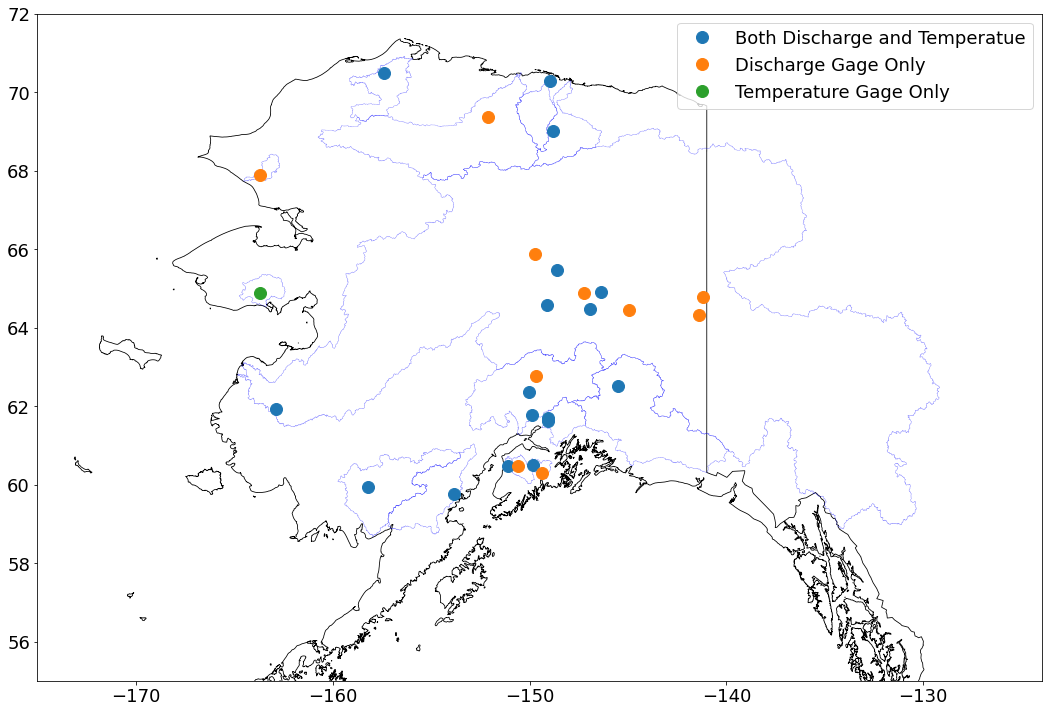

In [103]:


fig, ax = plt.subplots(1, figsize=(18, 14))
# Plot Alaska and Yukon Outline
base_plot = ak_map.plot(linewidth=0.8, ax=ax, facecolor="none", 
              edgecolor='black')
base_plot.tick_params(labelsize=18)

for comid in np.unique(points.outlet_comid.values):
    shape_file = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/subbasin_{}.gpkg'.format(comid)) 
    dissolved=shape_file.exterior
    dissolved.plot(linewidth=0.4, ax=ax, alpha=0.4, facecolor="none", edgecolor='blue')

groups = points.groupby('type')
for name, group in groups:
    ax.plot(group.Long, group.Lat, marker="o", linestyle='', markersize=12, label=name)
    
plt.legend(fontsize="18")
plt.xlim([-175, -124])
plt.ylim([55, 72])

# River Temperature

## Suragate Model

In [2]:
df_temp =pd.read_csv('/glade/u/home/dblaskey/RBM/Optimization/LHS_results_raw_loc_0.csv')
df_temp["Iteration"] = df_temp["Name"].str.split("_", expand = True)[3]
df_temp["Iteration"] = list(map(int, df_temp.Iteration.values))

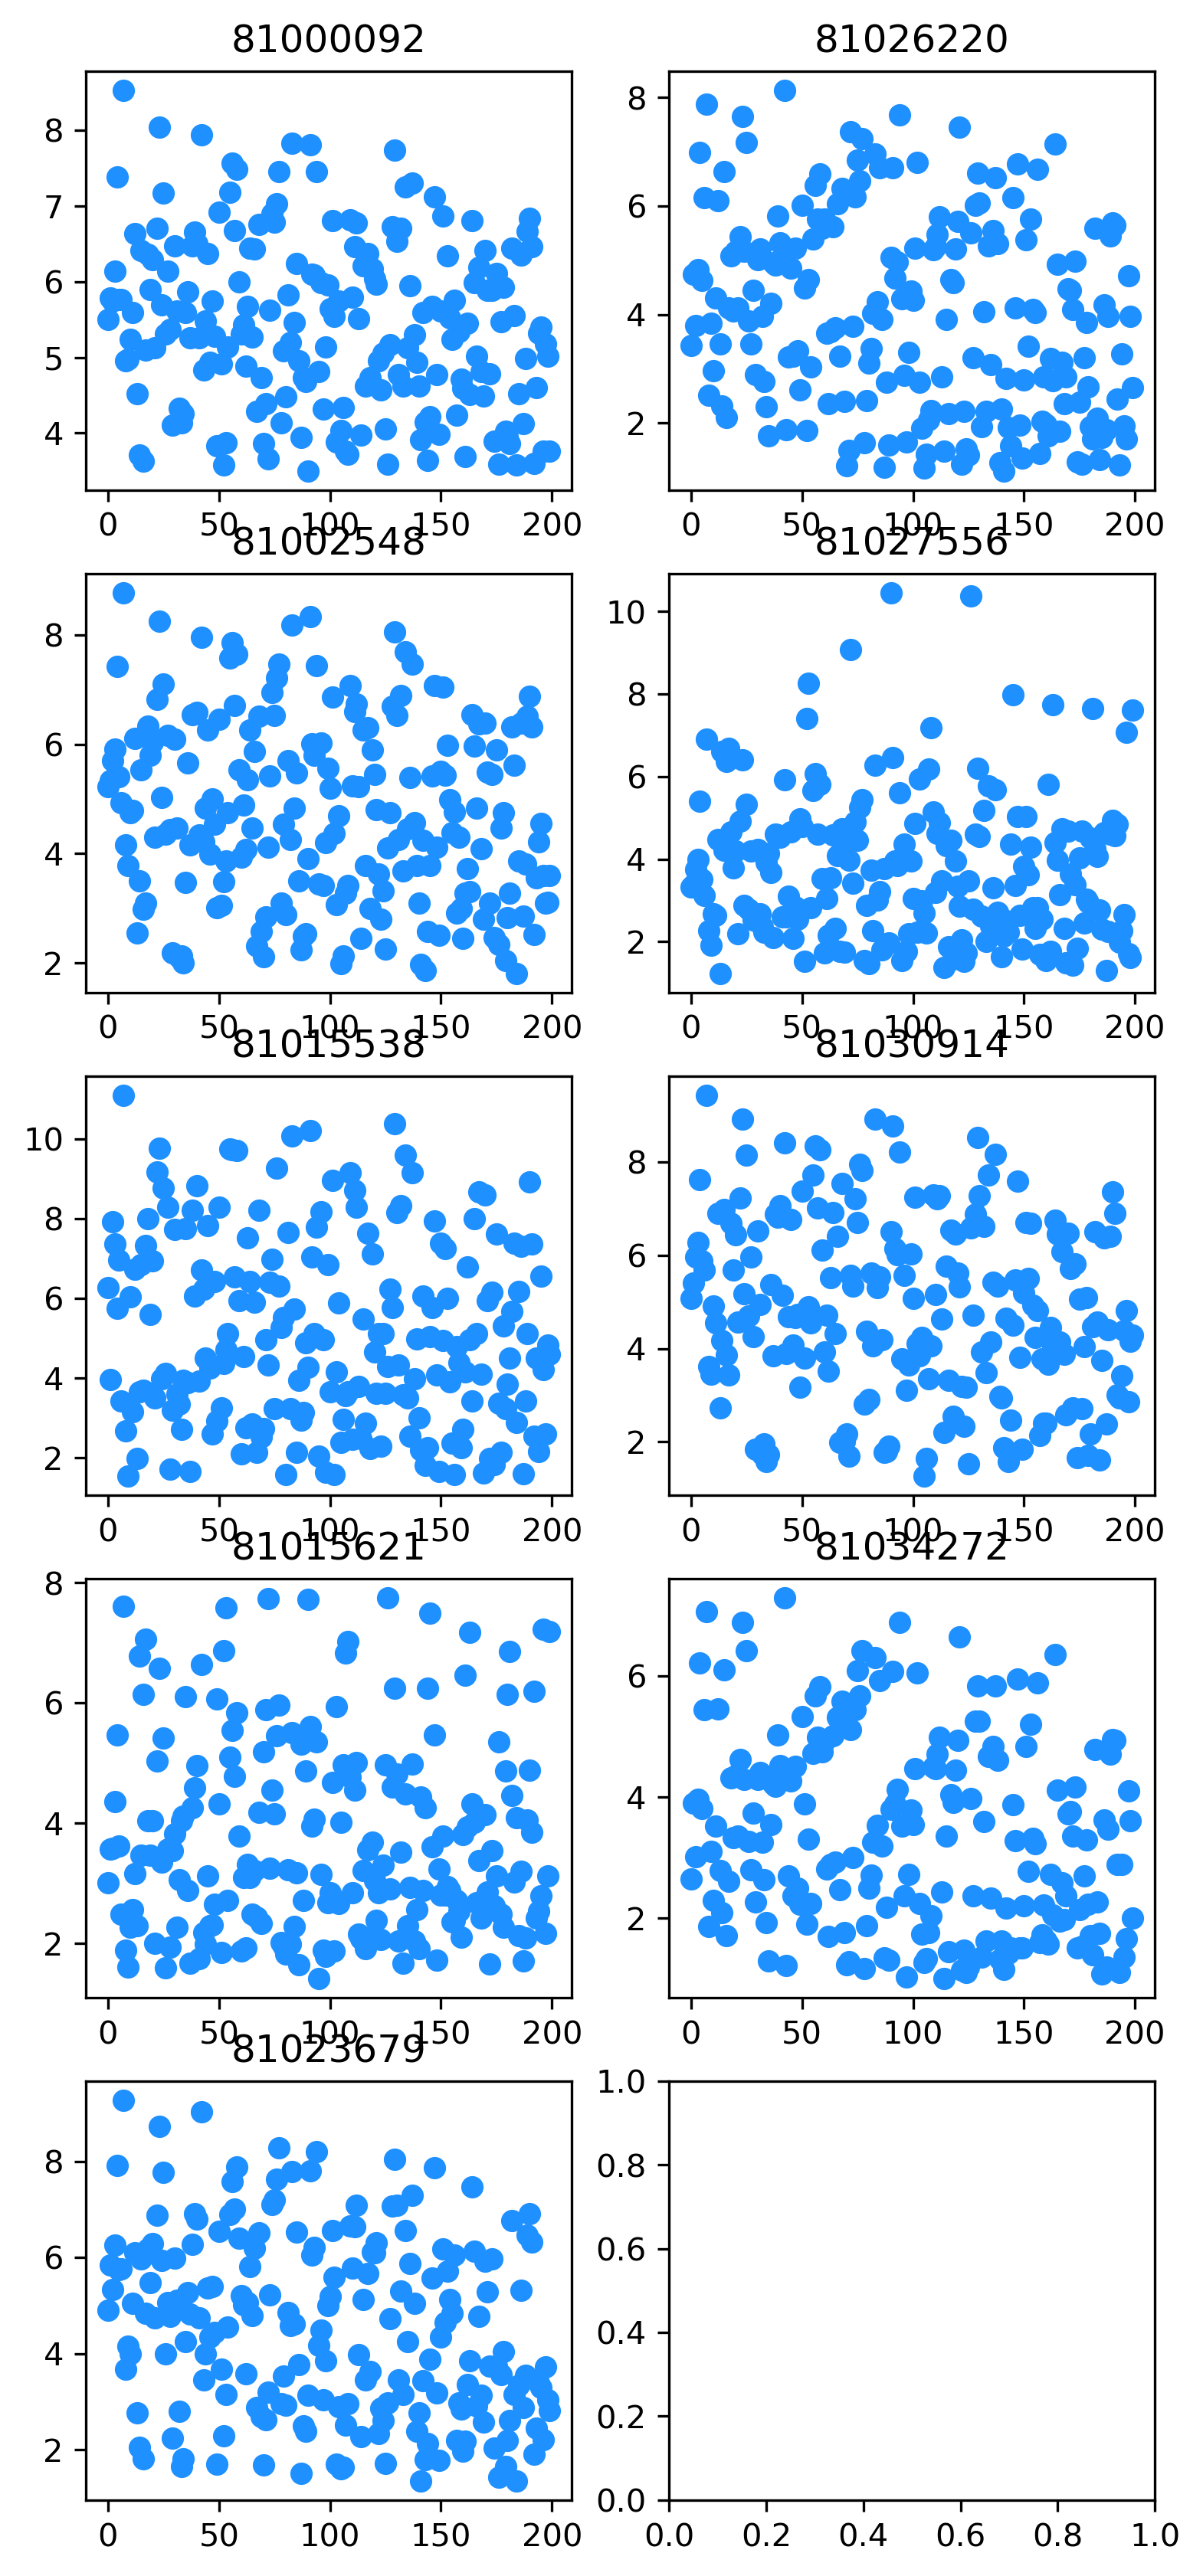

In [13]:
fig,ax = plt.subplots(5, 2,figsize=[6,14],dpi=300)
for i,comid in enumerate(np.unique(df_temp.COMID.values)):
    plot_temp = df_temp[df_temp['COMID'] == comid]
    col = int(np.floor(i/5))
    row = i % 5
    ax[row,col].scatter(plot_temp.Iteration.values, plot_temp.temp_rmse.values, c='dodgerblue')
    ax[row,col].set_title("%s"%comid)
    xmin,xmax = ax[row,col].get_xlim()
    ymin,ymax = ax[row,col].get_ylim()

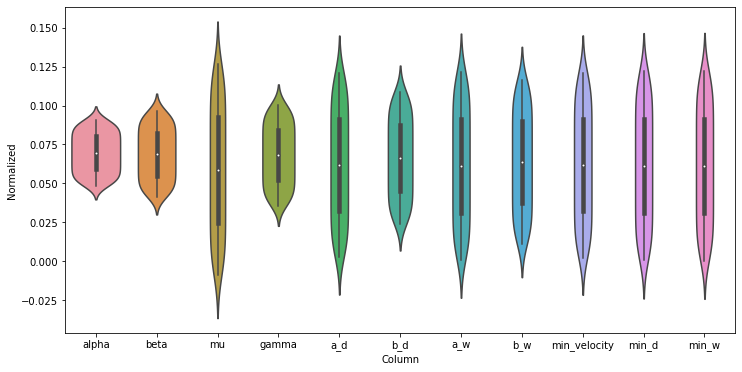

In [41]:
df_LHS = pd.read_csv('/glade/u/home/dblaskey/RBM/Optimization/LHS_results_0.csv')
d = preprocessing.normalize(df_LHS.drop(["Name", "temp_rmse"], axis = 1),axis=0,return_norm=True)
normalization_scalar = d[1]
scaled = df_LHS.drop(["Name", "temp_rmse"], axis = 1)/normalization_scalar
df_scaled = df_LHS[["Name", "temp_rmse"]].join(scaled)
df_std = scaled.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

In [3]:
param_df = pd.read_csv('/glade/u/home/dblaskey/RBM/Optimization/Param_range.csv')

1.5 0 (160, 11)
1.5 1 (160, 11)
1.5 2 (160, 11)
1.5 3 (160, 11)
1.5 4 (160, 11)
1.5 1.60652273481293 (160, 11)


Text(0.5, 0, 'Predicted')

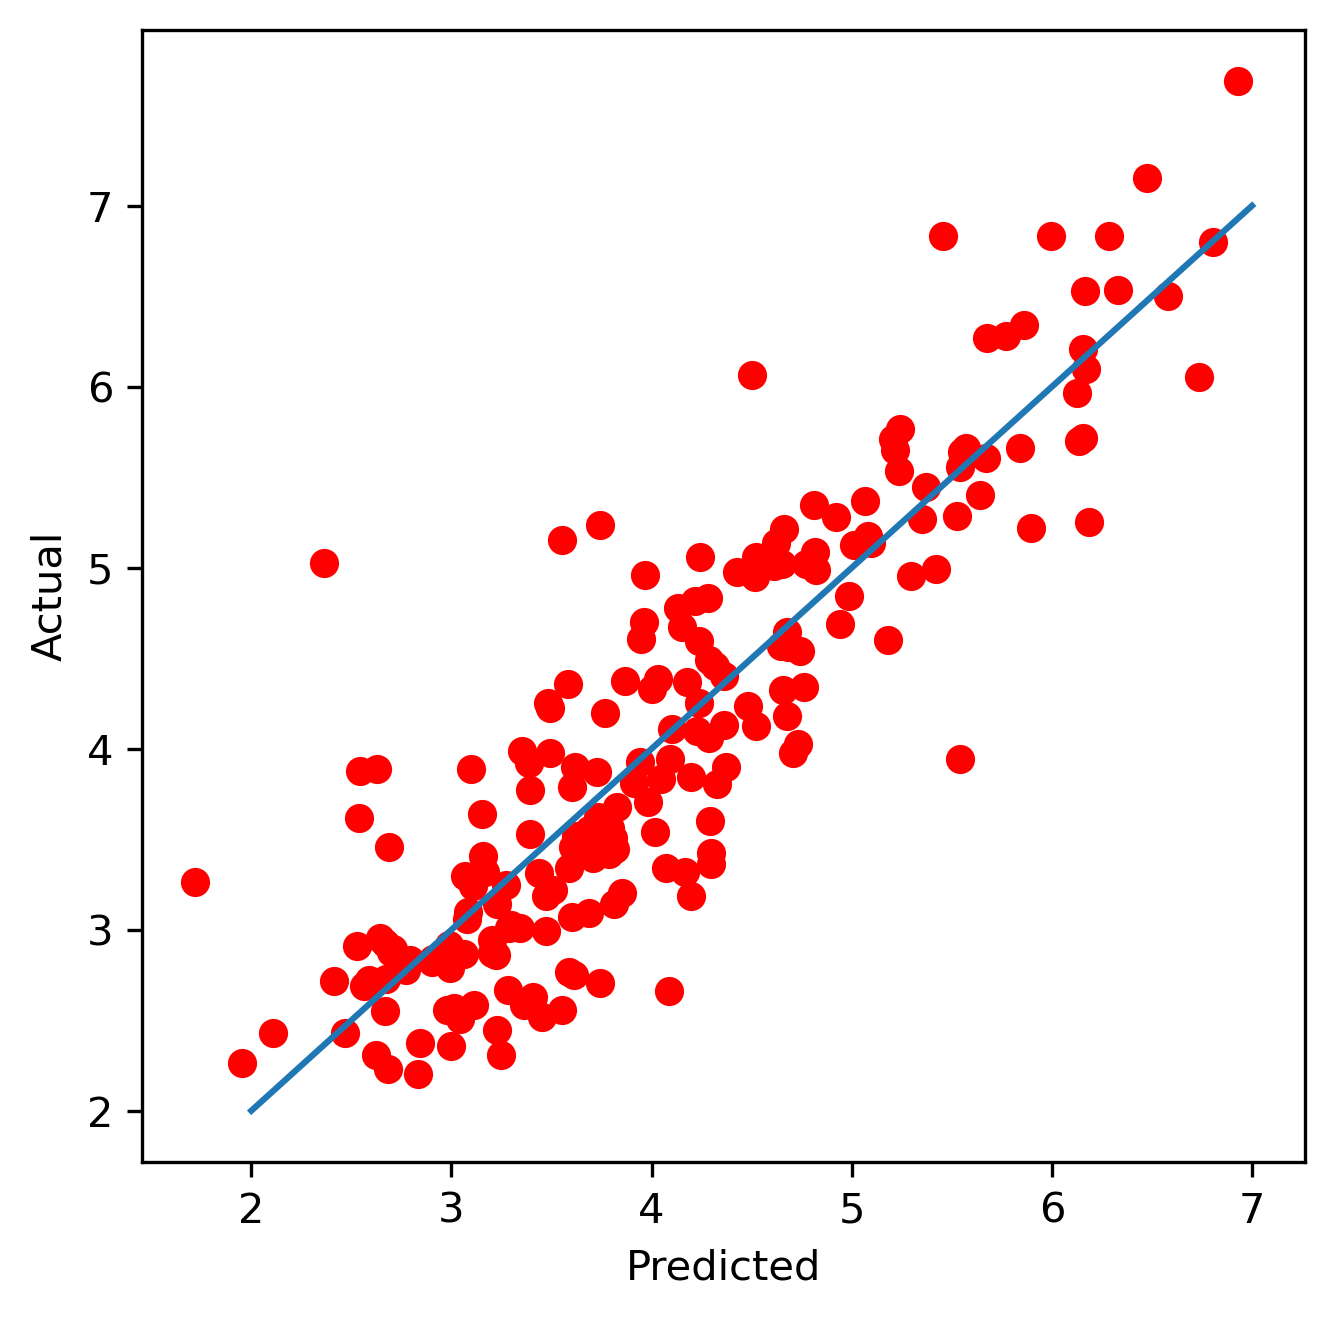

In [42]:
k_fold = 5
tot_sample_size, nInput, nOutput = len(df_scaled), 11, 1
num_validate_per_k = tot_sample_size/k_fold
num_train_per_k = tot_sample_size - num_validate_per_k

tot_id_list = np.arange(tot_sample_size)

# shuffle the id list
random.shuffle(tot_id_list)

alpha = 1e-4
lb = 1e-4
ub = 1e3
nu = 1.5

# start training the surrogate models
x = scaled.values
y = df_LHS["temp_rmse"].values 

xlb_single_value_scaled = param_df['Min_Value']/normalization_scalar
xub_single_value_scaled = param_df['Max_Value']/normalization_scalar

plt.figure(figsize=[5,5],dpi=300)
for alpha in [alpha]:
    rmse_list = []
    for k in range(k_fold):
#        validate_id_list = np.arange(k*num_validate_per_k,(k+1)*num_validate_per_k).astype(np.int)
        validate_id_list = tot_id_list[int(k*num_validate_per_k):int((k+1)*num_validate_per_k)]
        train_id_list = np.array(list(set(tot_id_list).difference(validate_id_list)))
    #     print(train_id_list, validate_id_list)

        x_train = x[train_id_list, :]
        x_val = x[validate_id_list, :]

        y_train = y[train_id_list]
        y_val = y[validate_id_list]

        sm_test = gp.GPR_Matern(x_train, y_train, nInput, nOutput, x_train.shape[0], xlb_single_value_scaled, xub_single_value_scaled, alpha=alpha, leng_sb=[lb,ub],nu=nu)
        y_predict = sm_test.predict(x_val)

        rmse_list.append(np.sqrt(pow(y_predict - y_val, 2).mean()))
        print(nu, k, x_train.shape)
        plt.scatter(y_predict.T[0],y_val,color='r')
    print(nu, np.mean(rmse_list), x_train.shape)

plt.plot([2,7],[2,7])
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [166]:
result_values = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_parameter_values.csv')
param_df = pd.read_csv('/glade/u/home/dblaskey/RBM/Optimization/Param_range.csv')
df_LHS = pd.read_csv('/glade/u/home/dblaskey/RBM/Optimization/LHS_results_0.csv')
d = preprocessing.normalize(df_LHS.drop(["Name", "temp_rmse"], axis = 1),axis=0,return_norm=True)
normalization_scalar = d[1]
scaled = df_LHS.drop(["Name", "temp_rmse"], axis = 1)/normalization_scalar

nInput, nOutput = 11, 1
alpha = 1e-4
lb = 1e-4
ub = 1e3
nu = 1.5

xlb_single_value_scaled = param_df['Min_Value']/normalization_scalar
xub_single_value_scaled = param_df['Max_Value']/normalization_scalar
default_values = param_df.Mean_Value.values/normalization_scalar
    
sim_df_list = []
for local in result_values.Location.values:
    df_LHS = pd.read_csv('/glade/u/home/dblaskey/RBM/Optimization/LHS_results_20_%s.csv'%local)
    scaled = df_LHS.drop(["Name", "temp_rmse"], axis = 1)/normalization_scalar

    # start training the surrogate models
    x = scaled.values
    y = df_LHS["temp_rmse"].values 
    sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_single_value_scaled, xub_single_value_scaled, alpha=alpha, leng_sb=[lb,ub], nu=nu)
    y_predict,y_std = sm.predict(x,return_std=True)

    for i_param,param in enumerate(param_df.Var_name.values):
        y_sim = []
        lb_m = xlb_single_value_scaled[i_param]
        ub_m = xub_single_value_scaled[i_param]
        x_sim_list = []
        x_id = i_param
        for j in range(11):
            x = default_values.copy()
            x_sim = lb_m + (ub_m-lb_m)*j/10
            x[x_id] = x_sim
            x_sim_list.append(x_sim)
            y_sim.append(sm.predict(x)[0])

        sim_df_list.append(pd.DataFrame({'flow_metric': y_sim, 'X_val': x_sim_list, 'Param': param, 'Location': local}))
            
sim_df = pd.concat(sim_df_list)
# Extract the single value from the array column
sim_df['flow_metric'] = sim_df['flow_metric'].str[0]

In [167]:
d1=sim_df.groupby(['Param', 'Location']).flow_metric.max().reset_index()
d2=sim_df.groupby(['Param', 'Location']).flow_metric.min().reset_index()
d2=d1.merge(d2, on=['Param', 'Location'])
d2['diff'] = d2.flow_metric_x - d2.flow_metric_y
Discount_dictionary ={'Interior' : 3/9, 'North' : 2/9, 'South' : 4/9}
d2['weight'] = d2['Location'].map(Discount_dictionary)
d2['weight_diff'] = d2['diff']*d2['weight']
d2

Param  Location  flow_metric_x  flow_metric_y      diff    weight  \
0            a_d  Interior       4.447199       3.545525  0.901674  0.333333   
1            a_d     North       5.421318       4.703131  0.718187  0.222222   
2            a_d     South       4.446791       3.522791  0.924000  0.444444   
3            a_w  Interior       3.698756       2.848957  0.849799  0.333333   
4            a_w     North       4.890175       3.644539  1.245636  0.222222   
5            a_w     South       3.620859       2.946823  0.674036  0.444444   
6          alpha  Interior       4.125015       3.130728  0.994288  0.333333   
7          alpha     North       4.977820       4.709083  0.268737  0.222222   
8          alpha     South       4.247408       2.611483  1.635925  0.444444   
9            b_d  Interior       4.908663       3.467125  1.441537  0.333333   
10           b_d     North       5.336937       4.733259  0.603678  0.222222   
11           b_d     South       3.992039       3.453843  0.538196  0.444444   
12           b_w  Interior       3.626652       3.567572  0.059080  0.333333   
13           b_w     North       4.893457       4.680188  0.213269  0.222222   
14           b_w     South       4.251241       3.071709  1.179531  0.444444   
15          beta  Interior       3.874980       3.440305  0.434675  0.333333   
16          beta     North       4.750841       4.533417  0.217424  0.222222   
17          beta     South       4.696861       3.016848  1.680014  0.444444   
18         gamma  Interior       3.979554       3.268104  0.711450  0.333333   
19         gamma     North       4.806272       4.429690  0.376582  0.222222   
20         gamma     South       3.883313       2.999836  0.883477  0.444444   
21         min_d  Interior       3.843157       3.387158  0.455999  0.333333   
22         min_d     North       5.590138       4.714193  0.875944  0.222222   
23         min_d     South       3.656477       3.553632  0.102845  0.444444   
24  min_velocity  Interior       4.408973       3.267861  1.141112  0.333333   
25  min_velocity     North       5.372047       4.503931  0.868116  0.222222   
26  min_velocity     South       4.138101       3.362914  0.775187  0.444444   
27         min_w  Interior       4.209546       3.530223  0.679323  0.333333   
28         min_w     North       4.858728       4.101903  0.756825  0.222222   
29         min_w     South       4.442423       3.439704  1.002720  0.444444   
30            mu  Interior       3.827548       2.925300  0.902248  0.333333   
31            mu     North       5.164770       3.550765  1.614005  0.222222   
32            mu     South       4.144087       2.250759  1.893328  0.444444   

    weight_diff  
0      0.300558  
1      0.159597  
2      0.410667  
3      0.283266  
4      0.276808  
5      0.299572  
6      0.331429  
7      0.059719  
8      0.727078  
9      0.480512  
10     0.134151  
11     0.239198  
12     0.019693  
13     0.047393  
14     0.524236  
15     0.144892  
16     0.048316  
17     0.746673  
18     0.237150  
19     0.083685  
20     0.392657  
21     0.152000  
22     0.194654  
23     0.045709  
24     0.380371  
25     0.192915  
26     0.344527  
27     0.226441  
28     0.168183  
29     0.445653  
30     0.300749  
31     0.358668  
32     0.841479

In [168]:
d1 = d2.groupby(['Param']).sum().weight_diff.sort_values().reset_index()
d1['Location'] = 'Overall'
d1 = d1[['Param', 'Location','weight_diff']]
d2 = d2[['Param', 'Location','diff']]
d2 = d2.rename(columns={'diff':'weight_diff'})
d2 = pd.concat((d2, d1), ignore_index = True)
d2

Param  Location  weight_diff
0            a_d  Interior     0.901674
1            a_d     North     0.718187
2            a_d     South     0.924000
3            a_w  Interior     0.849799
4            a_w     North     1.245636
5            a_w     South     0.674036
6          alpha  Interior     0.994288
7          alpha     North     0.268737
8          alpha     South     1.635925
9            b_d  Interior     1.441537
10           b_d     North     0.603678
11           b_d     South     0.538196
12           b_w  Interior     0.059080
13           b_w     North     0.213269
14           b_w     South     1.179531
15          beta  Interior     0.434675
16          beta     North     0.217424
17          beta     South     1.680014
18         gamma  Interior     0.711450
19         gamma     North     0.376582
20         gamma     South     0.883477
21         min_d  Interior     0.455999
22         min_d     North     0.875944
23         min_d     South     0.102845
24  min_velocity  Interior     1.141112
25  min_velocity     North     0.868116
26  min_velocity     South     0.775187
27         min_w  Interior     0.679323
28         min_w     North     0.756825
29         min_w     South     1.002720
30            mu  Interior     0.902248
31            mu     North     1.614005
32            mu     South     1.893328
33         min_d   Overall     0.392363
34           b_w   Overall     0.591323
35         gamma   Overall     0.713491
36         min_w   Overall     0.840277
37           b_d   Overall     0.853861
38           a_w   Overall     0.859646
39           a_d   Overall     0.870822
40  min_velocity   Overall     0.917812
41          beta   Overall     0.939881
42         alpha   Overall     1.118226
43            mu   Overall     1.500896

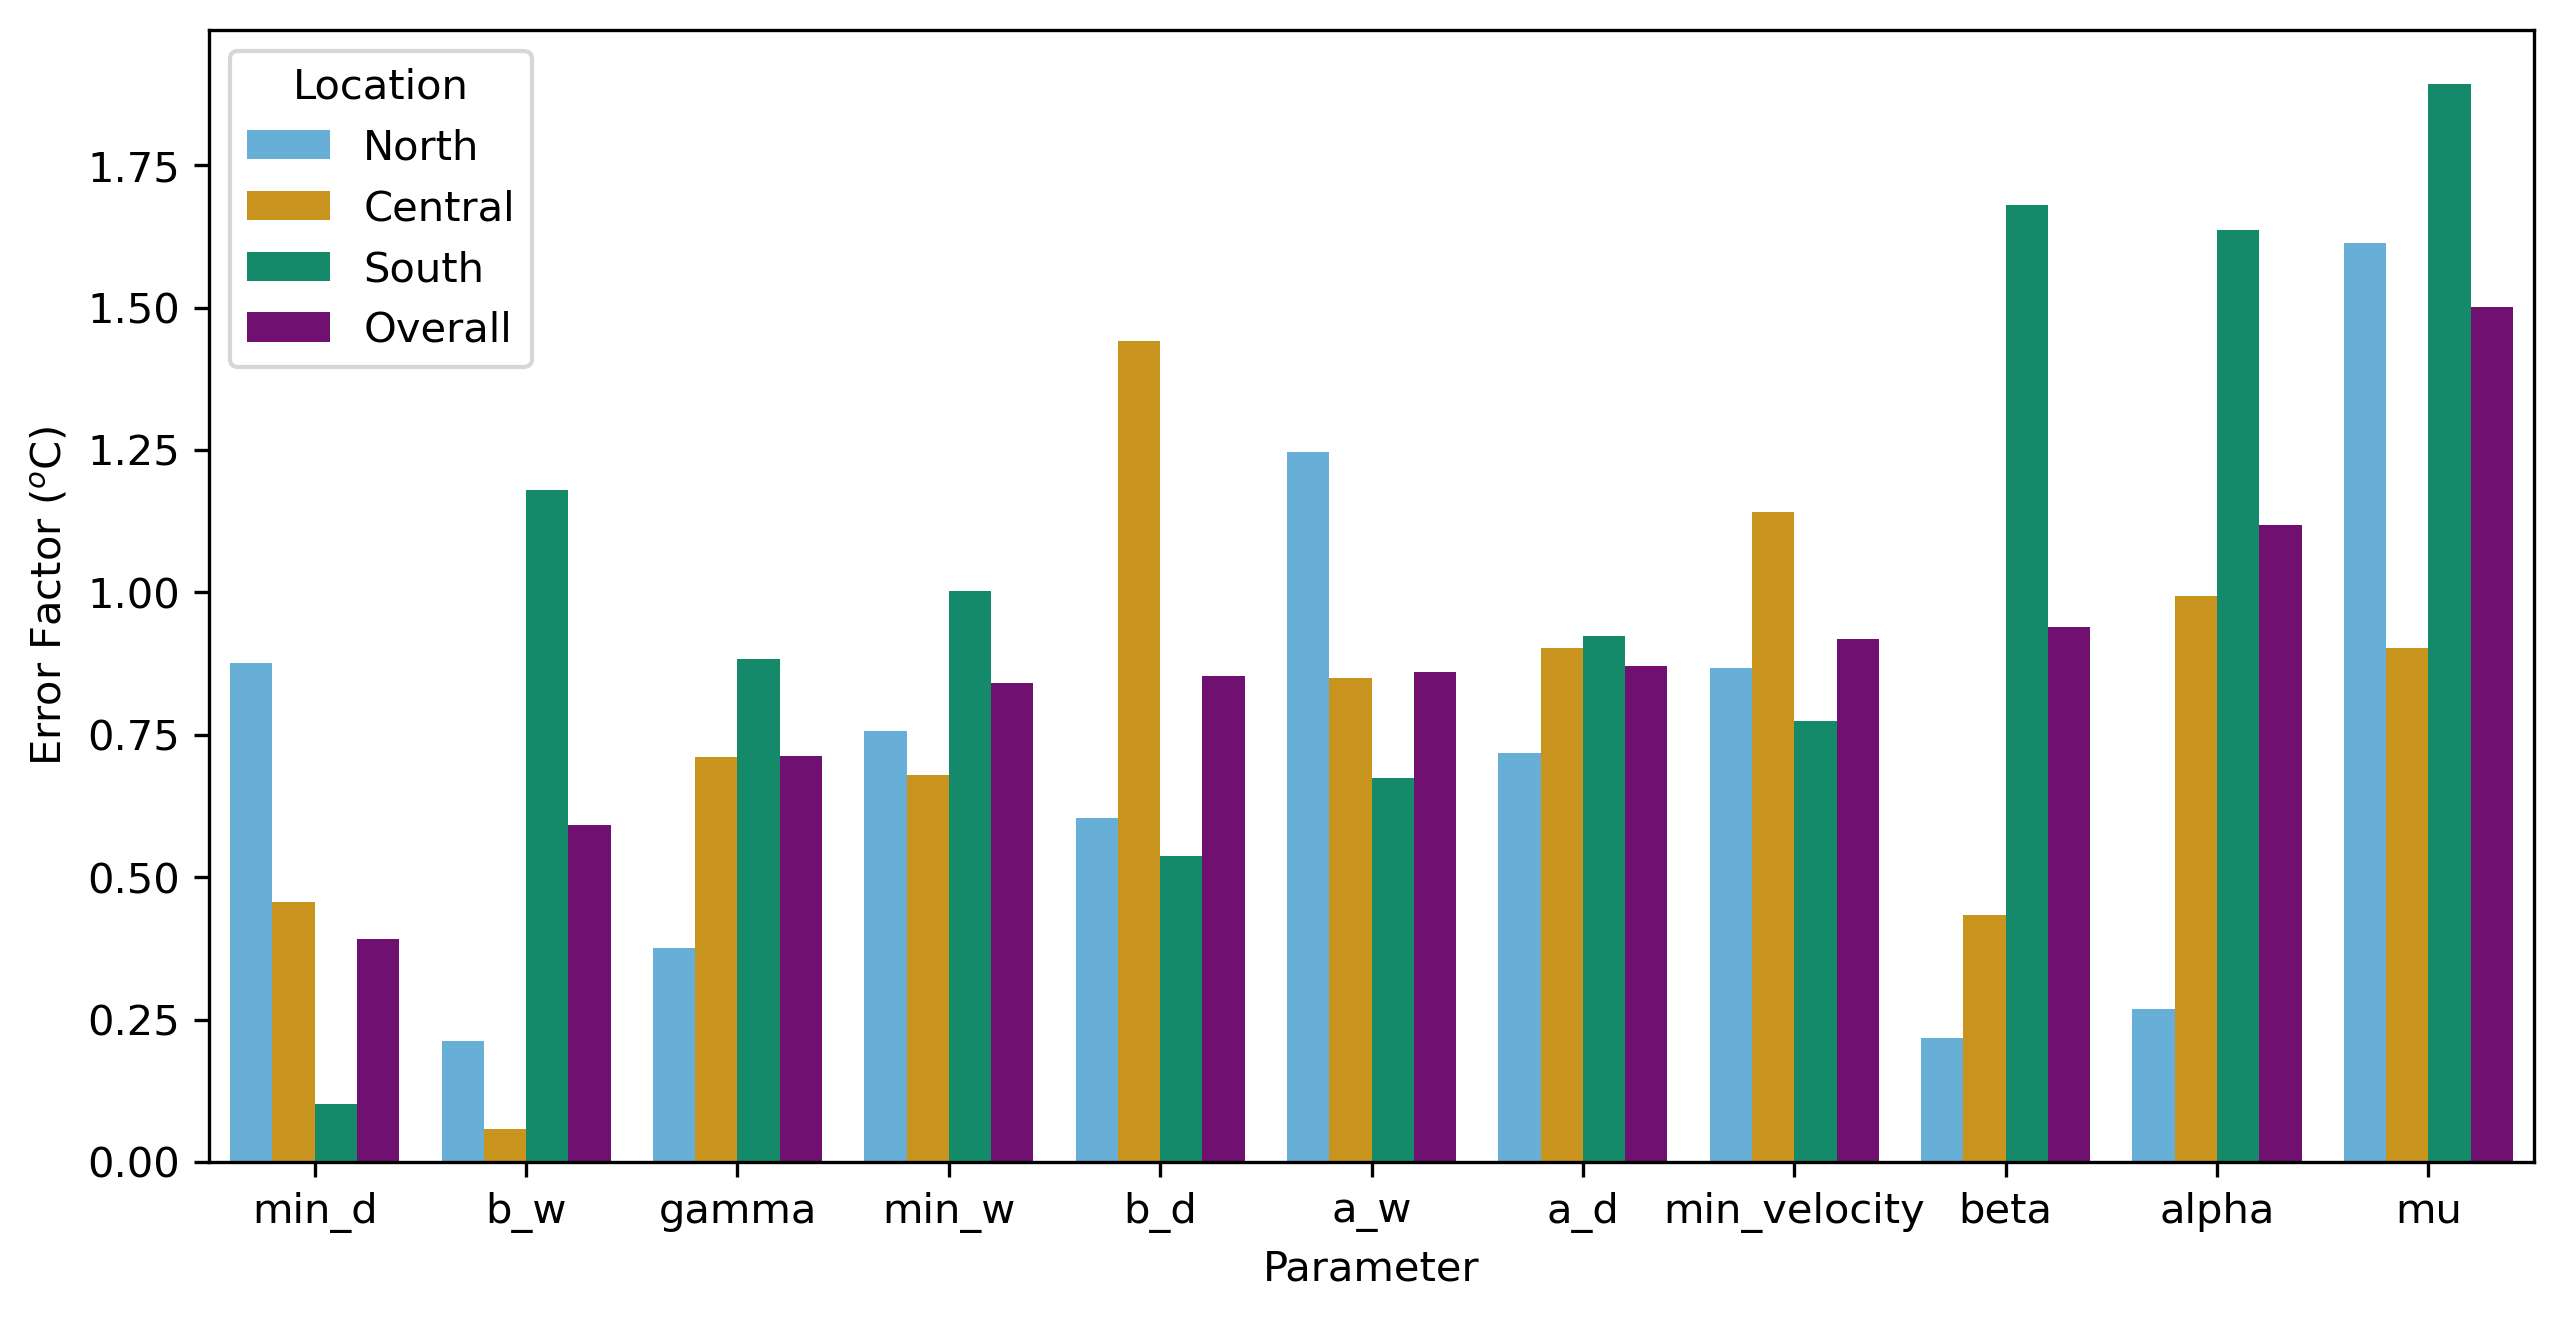

In [75]:
d2['Location'] = np.where(d2.Location.values == "Interior", 'Central', d2.Location.values)
order = d2[d2['Location'] == 'Overall'].sort_values('weight_diff').Param.values
# Arrange the legend order
legend_order = ['North', 'Central', 'South', 'Overall']

# Define your custom color palette
custom_palette = ['#56B4E9', '#E69F00', '#009E73', 'purple']  # Example colors: red, green, blue

fig, ax = plt.subplots(figsize=[10,5],dpi=300)

sns.barplot(data=d2, x="Param", y="weight_diff", hue="Location", palette=custom_palette, order=order, hue_order=legend_order)

plt.ylabel('Error Factor ($^o$C)')
plt.xlabel('Parameter')
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Parameter_Importance.png", dpi='figure')
plt.show()

In [169]:
# Define the mapping of parameters to symbols
parameter_symbols = {'mu': r'$\mu$', 'gamma': r'$\gamma$', 'beta': r'$\beta$', 'alpha': r'$\alpha$', 
                     'a_d': r'$a_d$', 'a_w': r'$a_w$', 'b_d': r'$b_d$', 'b_w': r'$b_w$',
                     'min_velocity': 'min v', 'min_d': 'min d', 'min_w': 'min w'}
d2['Param'] = d2['Param'].map(parameter_symbols)

In [170]:
d2['Location'] = np.where(d2.Location.values == "Interior", 'Central', d2.Location.values)

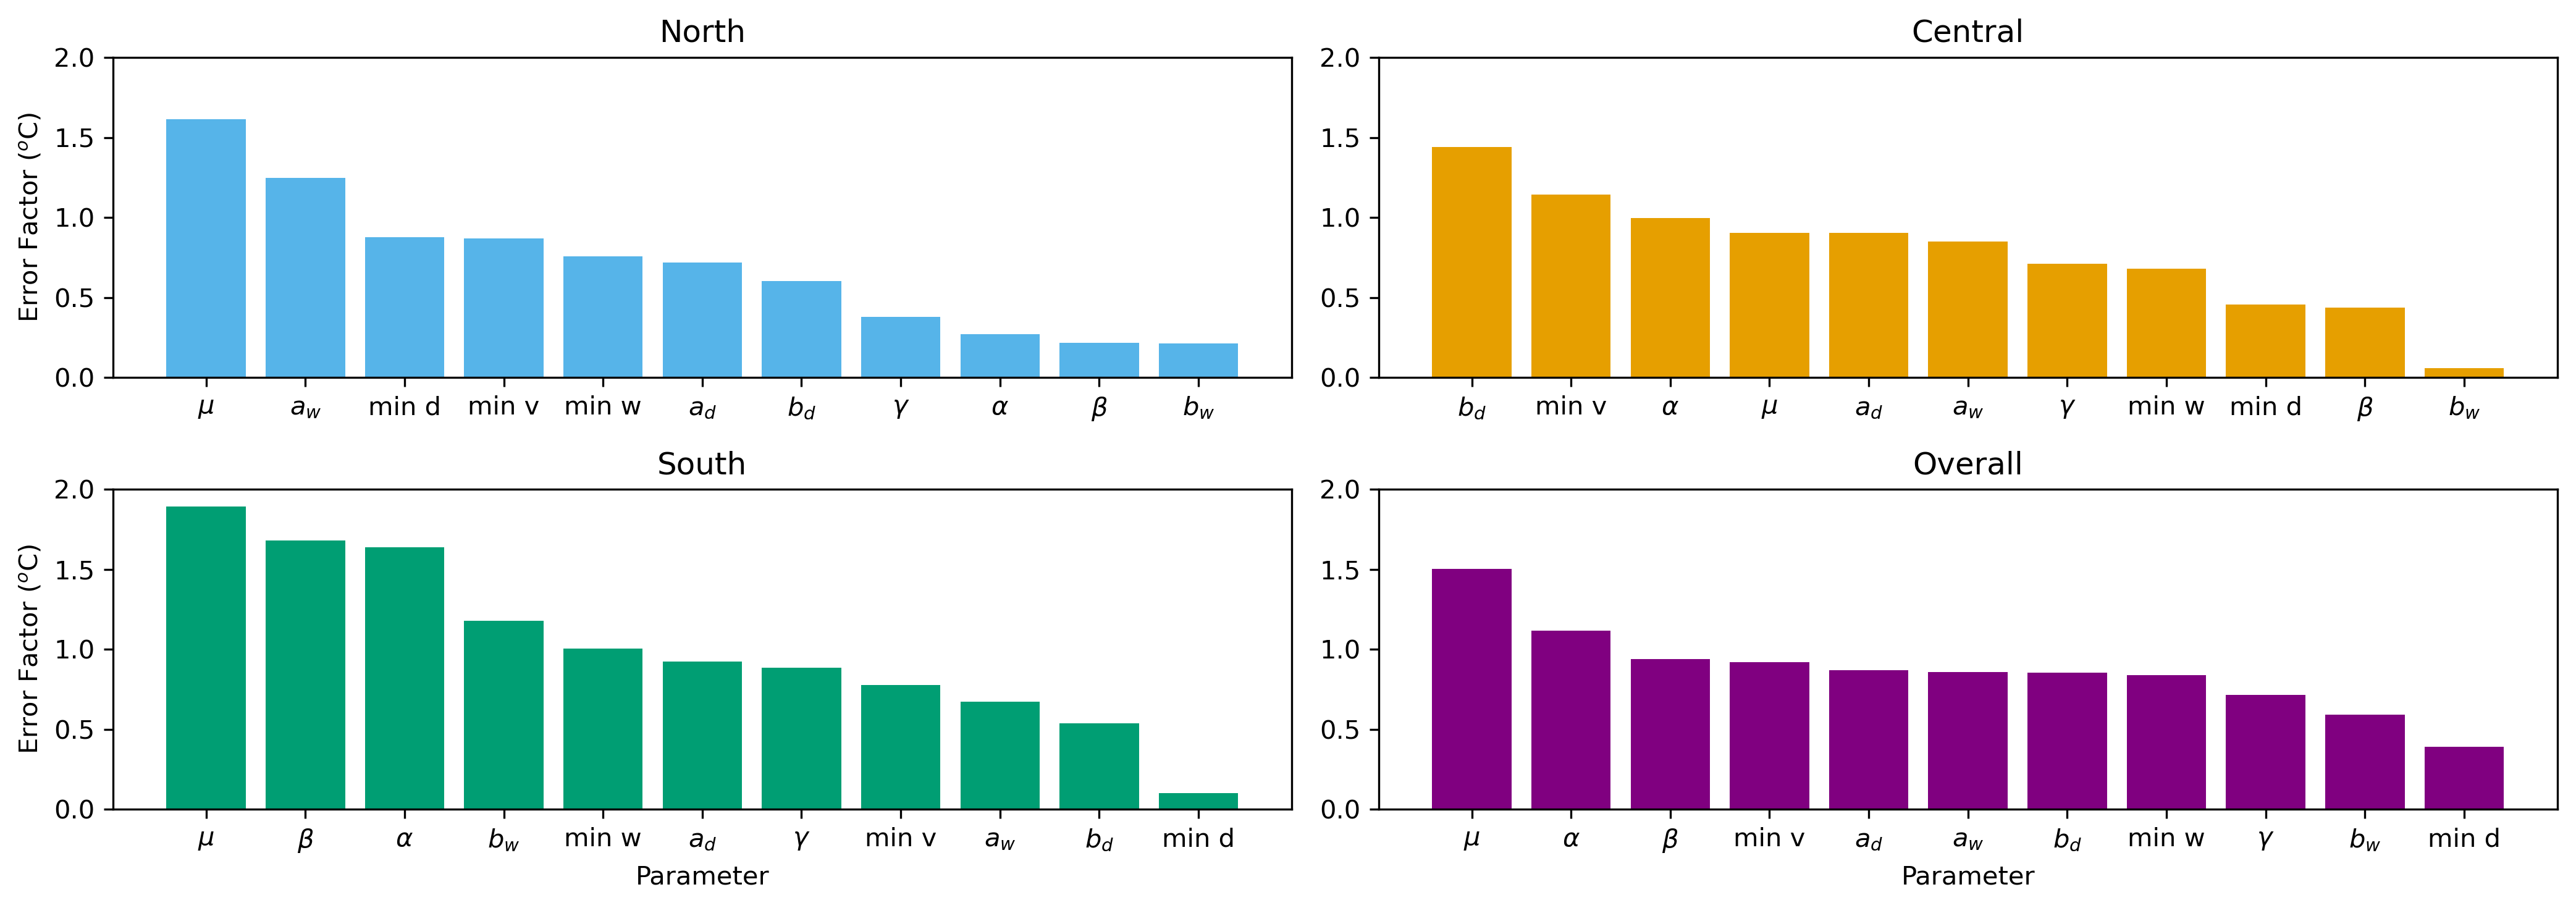

In [173]:
# Arrange the legend order
legend_order = ['North', 'Central', 'South', 'Overall']

# Define your custom color palette
custom_palette = ['#56B4E9', '#E69F00', '#009E73', 'purple']  # Example colors: red, green, blue
    
fig, ax = plt.subplots(2,2,figsize=[14,5],dpi=300)

for i,loc in enumerate(legend_order):
    col = i %2
    row = int(np.floor(i/2))
    temp = d2[d2['Location'] == loc]
    # Sort the data by 'weight_diff'
    temp = temp.sort_values('weight_diff', ascending=False)
    
    ax[row,col].bar(temp.Param.values, temp.weight_diff.values, color =custom_palette[i])
    ax[row,col].set_title("%s"%loc)
    ax[row,col].set_ylim(0,2)
    if col == 0:
        ax[row,col].set_ylabel('Error Factor ($^o$C)')
    if row == 1:
        ax[row,col].set_xlabel('Parameter')
plt.tight_layout()
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Parameter_Importance_Seperated.png", dpi='figure')
plt.show()

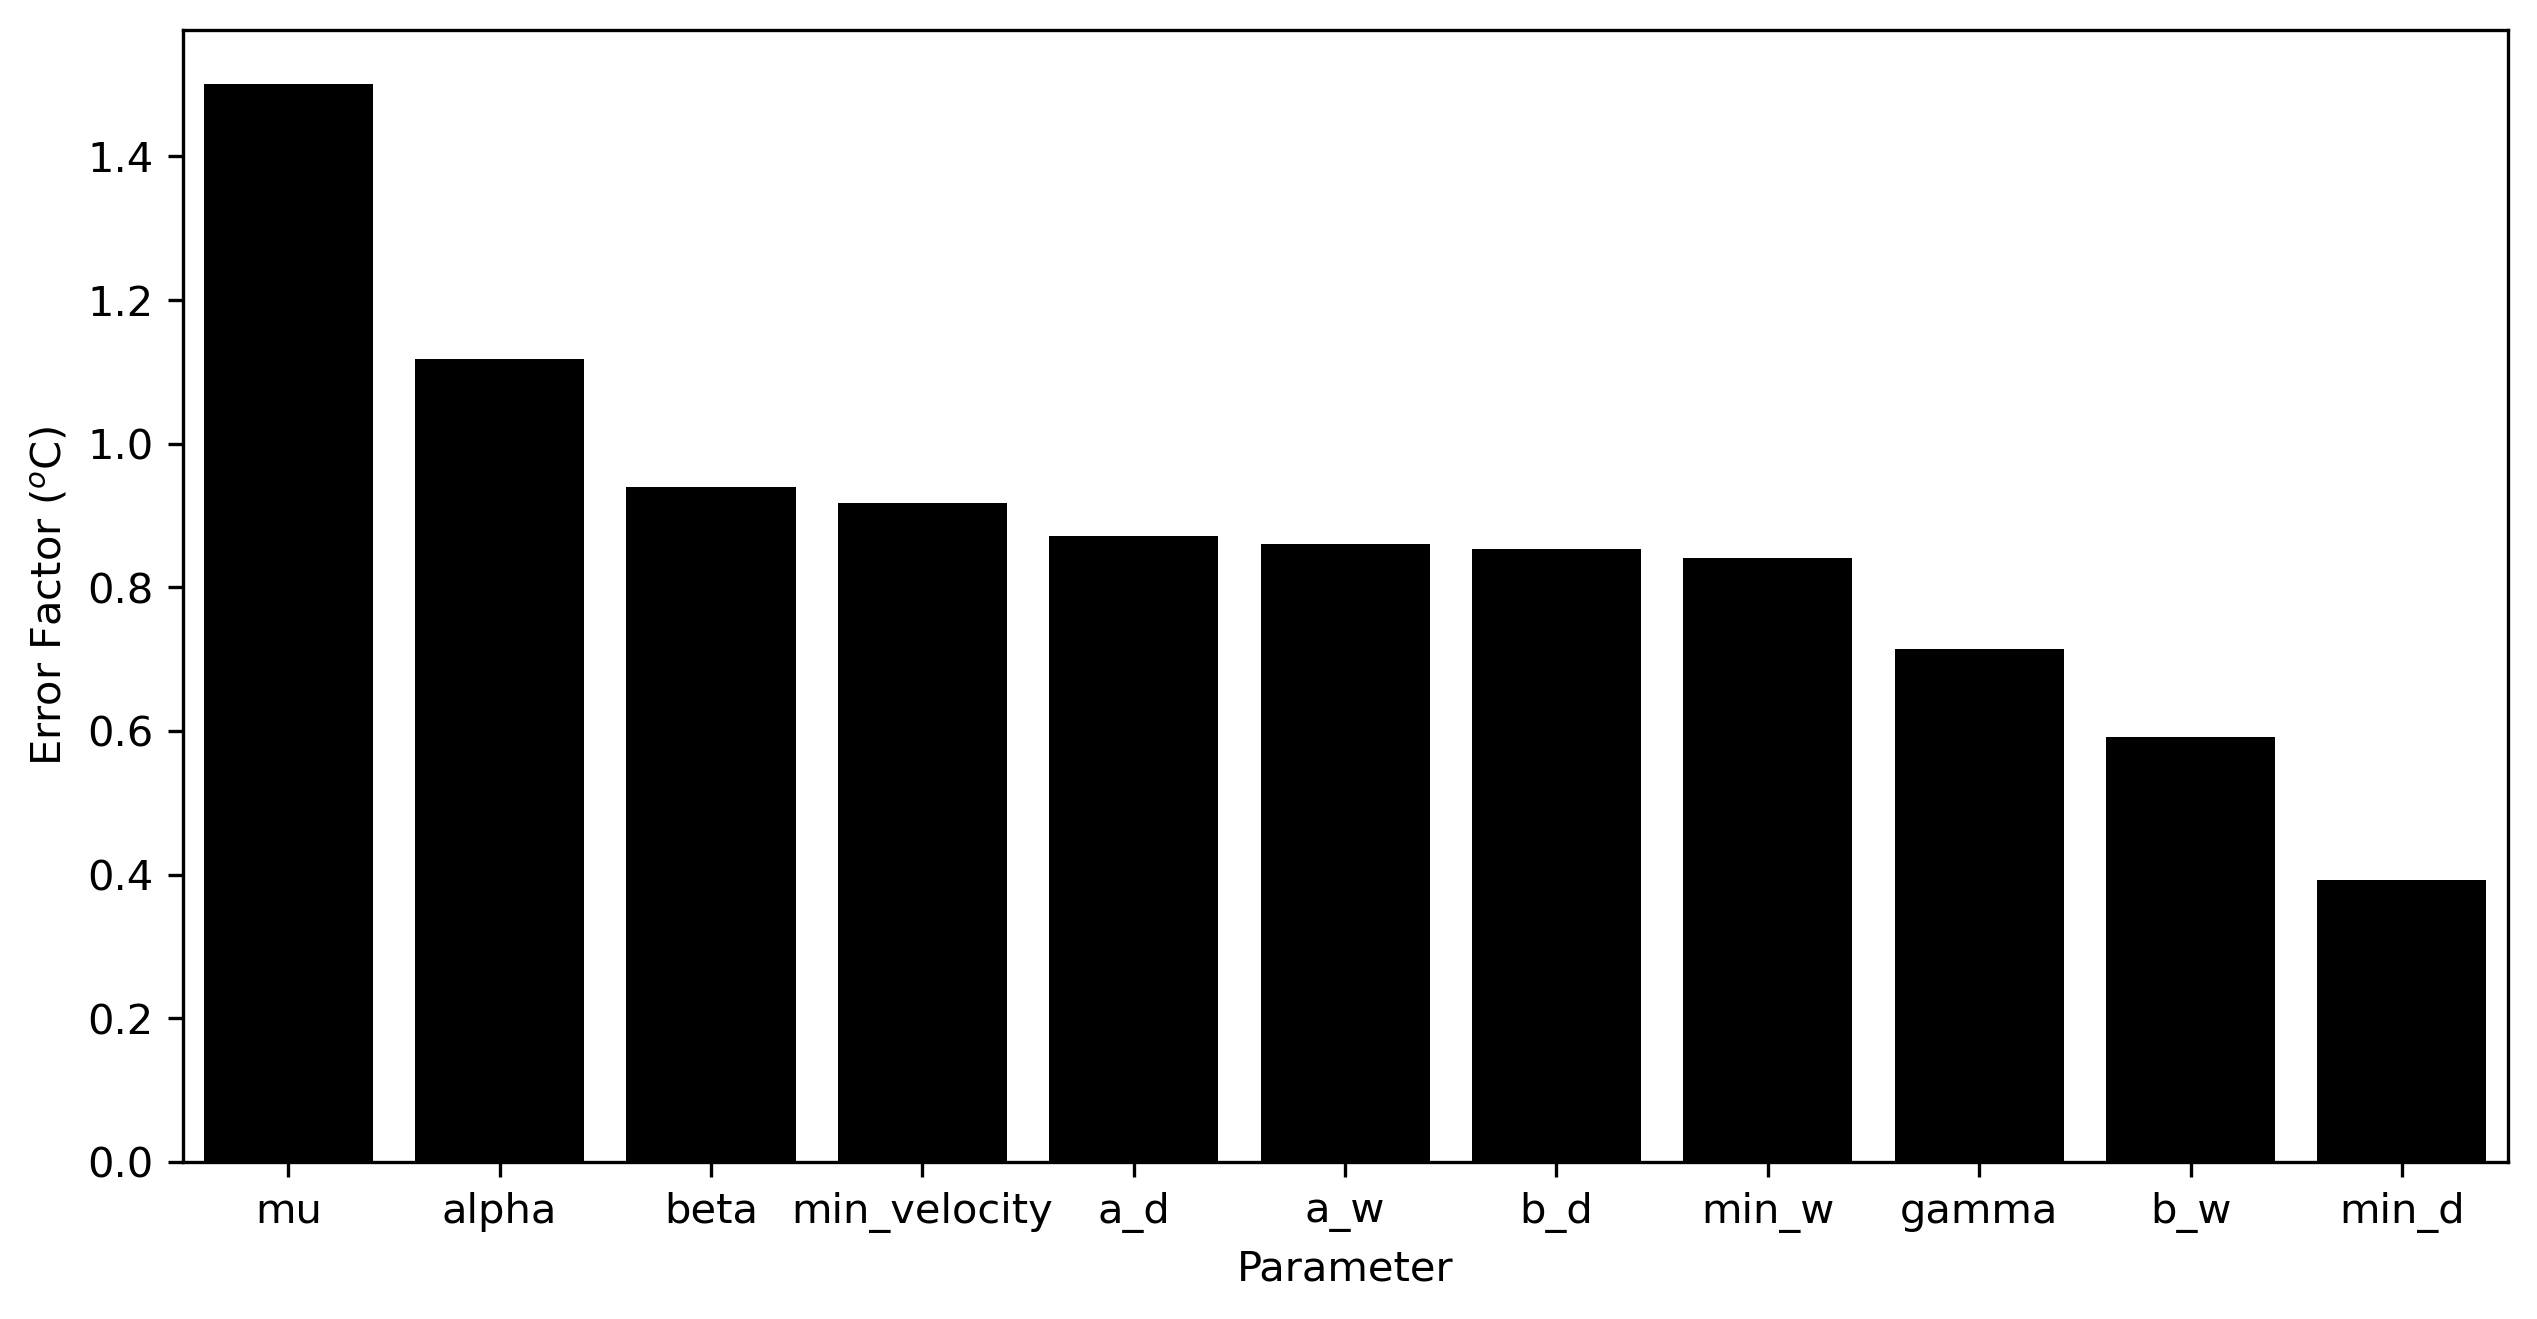

In [78]:
overall_df = d2[d2['Location'] == 'Overall']
order = overall_df.sort_values('weight_diff', ascending=False).Param.values
fig, ax = plt.subplots(figsize=[10,5],dpi=300)

sns.barplot(data=overall_df, x="Param", y="weight_diff", color='black', order=order)

plt.ylabel('Error Factor ($^o$C)')
plt.xlabel('Parameter')
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Parameter_Importance_Overall.png", dpi='figure')
plt.show()

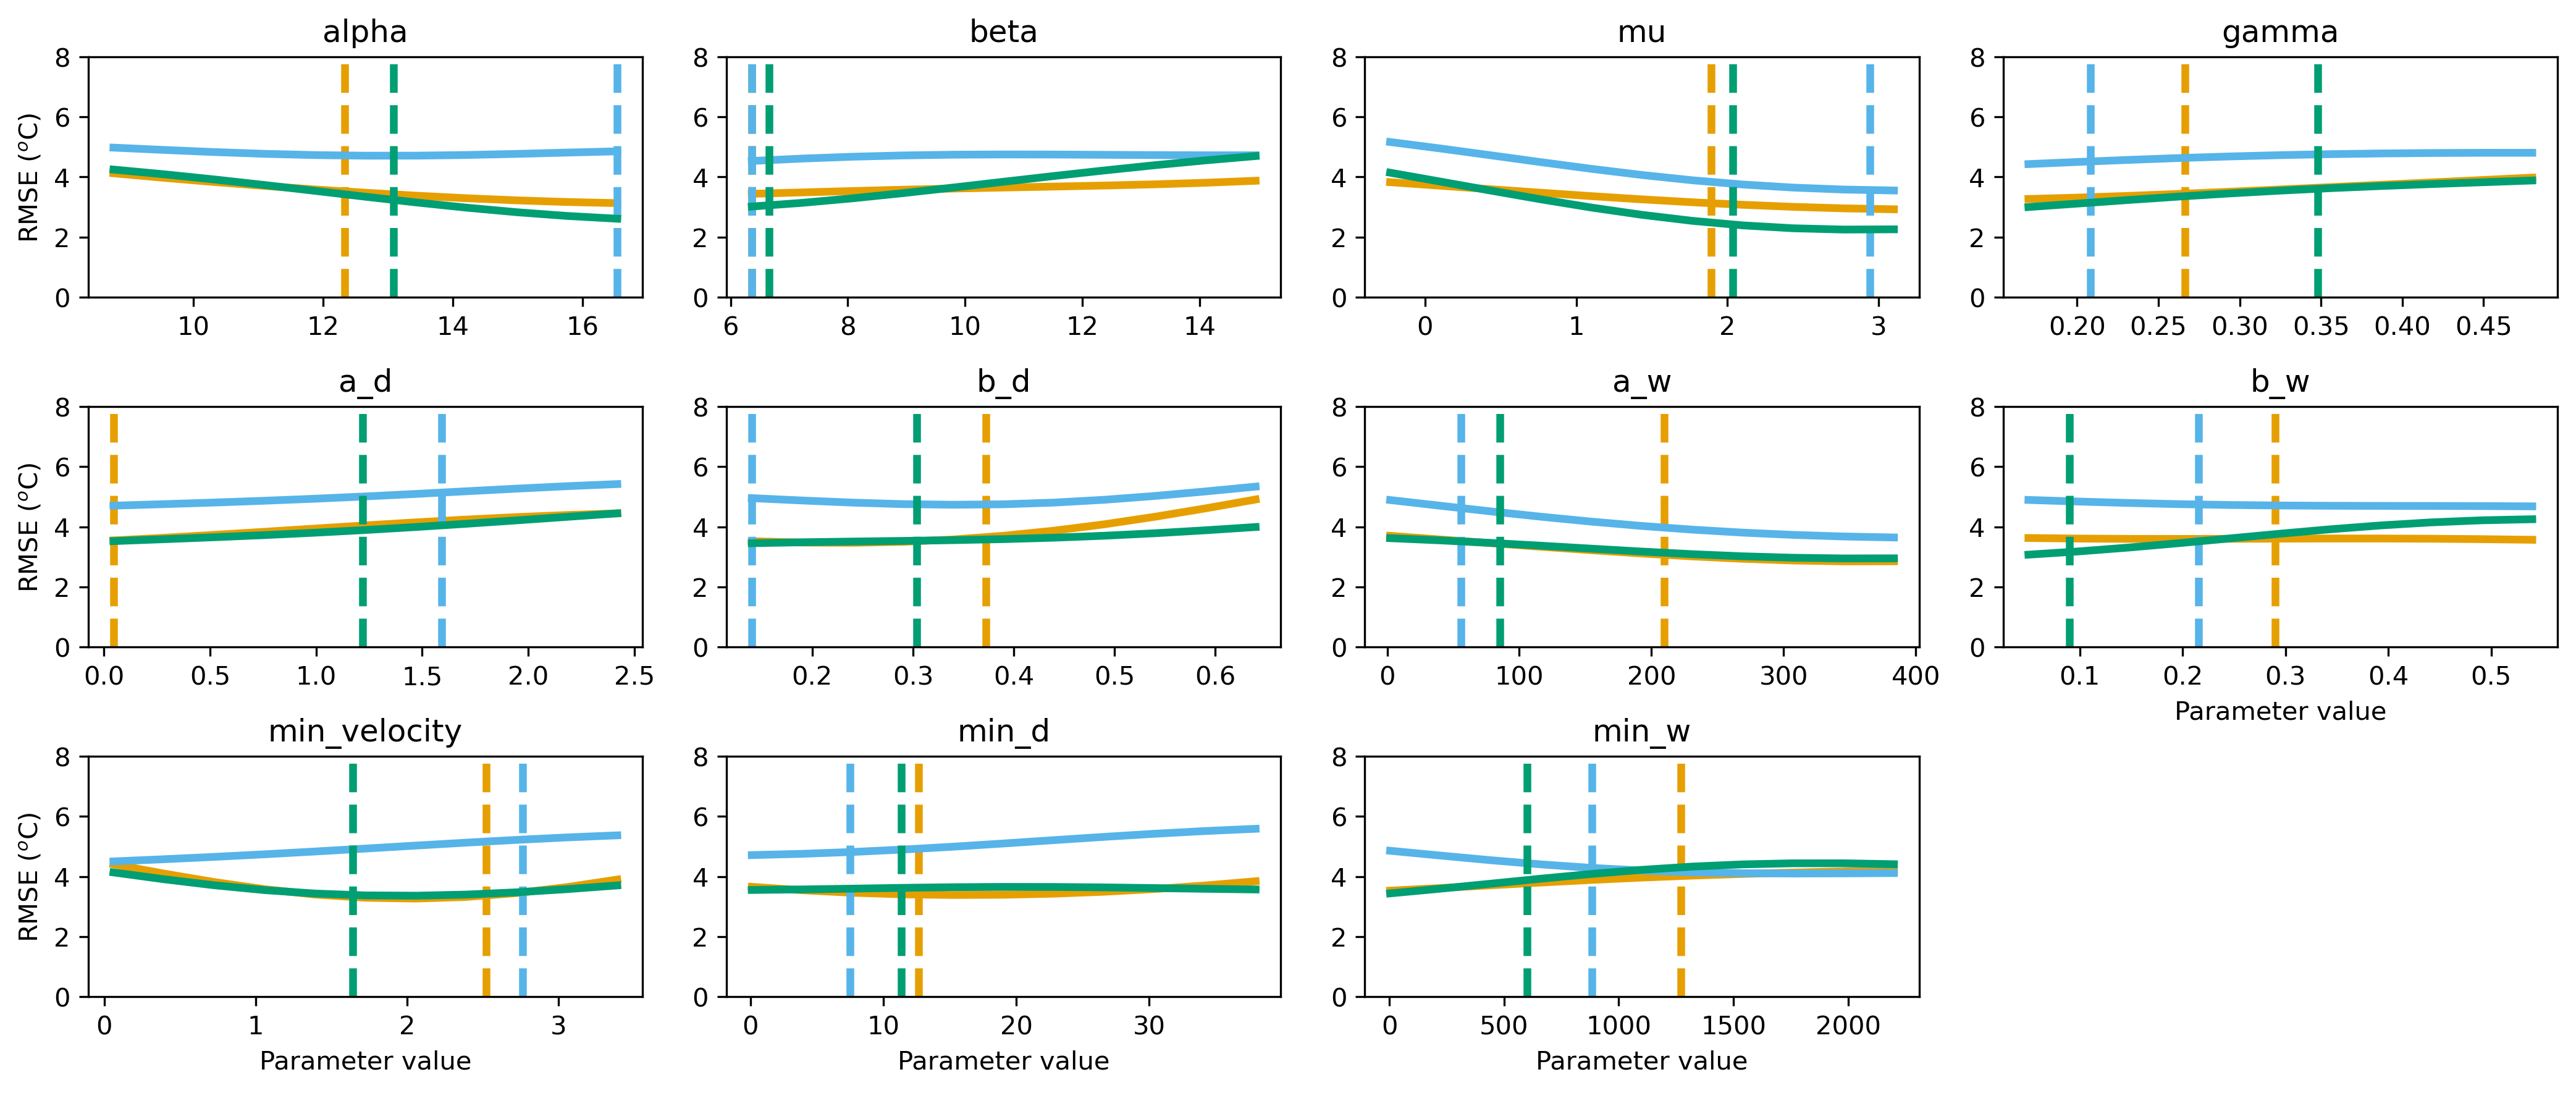

In [78]:
fig,ax = plt.subplots(3, 4,figsize=[14,6],dpi=300)
for i_param,param in enumerate(param_df.Var_name.values):
    
    col = i_param %4
    row = int(np.floor(i_param/4))
    colors = ['#E69F00', '#56B4E9', '#009E73']
    for c_i, loc in enumerate(result_values.Location.values):
        result_values_filtered = result_values[param]
        
        y_sim_df = sim_df[sim_df['Param'] == param]
        y_sim_df = y_sim_df[y_sim_df['Location'] == loc]
        ax[row,col].plot(y_sim_df.X_val.values*normalization_scalar[i_param],y_sim_df['flow_metric'].values, lw=3, c=colors[c_i])
        ax[row,col].axvline(x=result_values_filtered[c_i], c=colors[c_i], linestyle='--', lw=3)
    ax[row,col].set_title("%s"%param)#ax[row,col].set_title("%s (#%s)"%(param,i_param+1))
    ax[row,col].set_ylim(0,8)
    if col == 0:
        ax[row,col].set_ylabel('RMSE ($^o$C)')
    if row == 2:
        ax[row,col].set_xlabel('Parameter value')
    if ((col == 3) and (row == 1)):
        ax[row,col].set_xlabel('Parameter value')

fig.delaxes(ax[2, 3])
plt.tight_layout()
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/model_scatter_loc.png", dpi='figure')
plt.show()

In [43]:
# start training the surrogate models
x = scaled.values
y = df_LHS["temp_rmse"].values 
sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_single_value_scaled, xub_single_value_scaled, alpha=alpha, leng_sb=[lb,ub], nu=nu)
y_predict,y_std = sm.predict(x,return_std=True)
default_values = param_df.Mean_Value.values/normalization_scalar

In [27]:
result_values = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_results.csv')

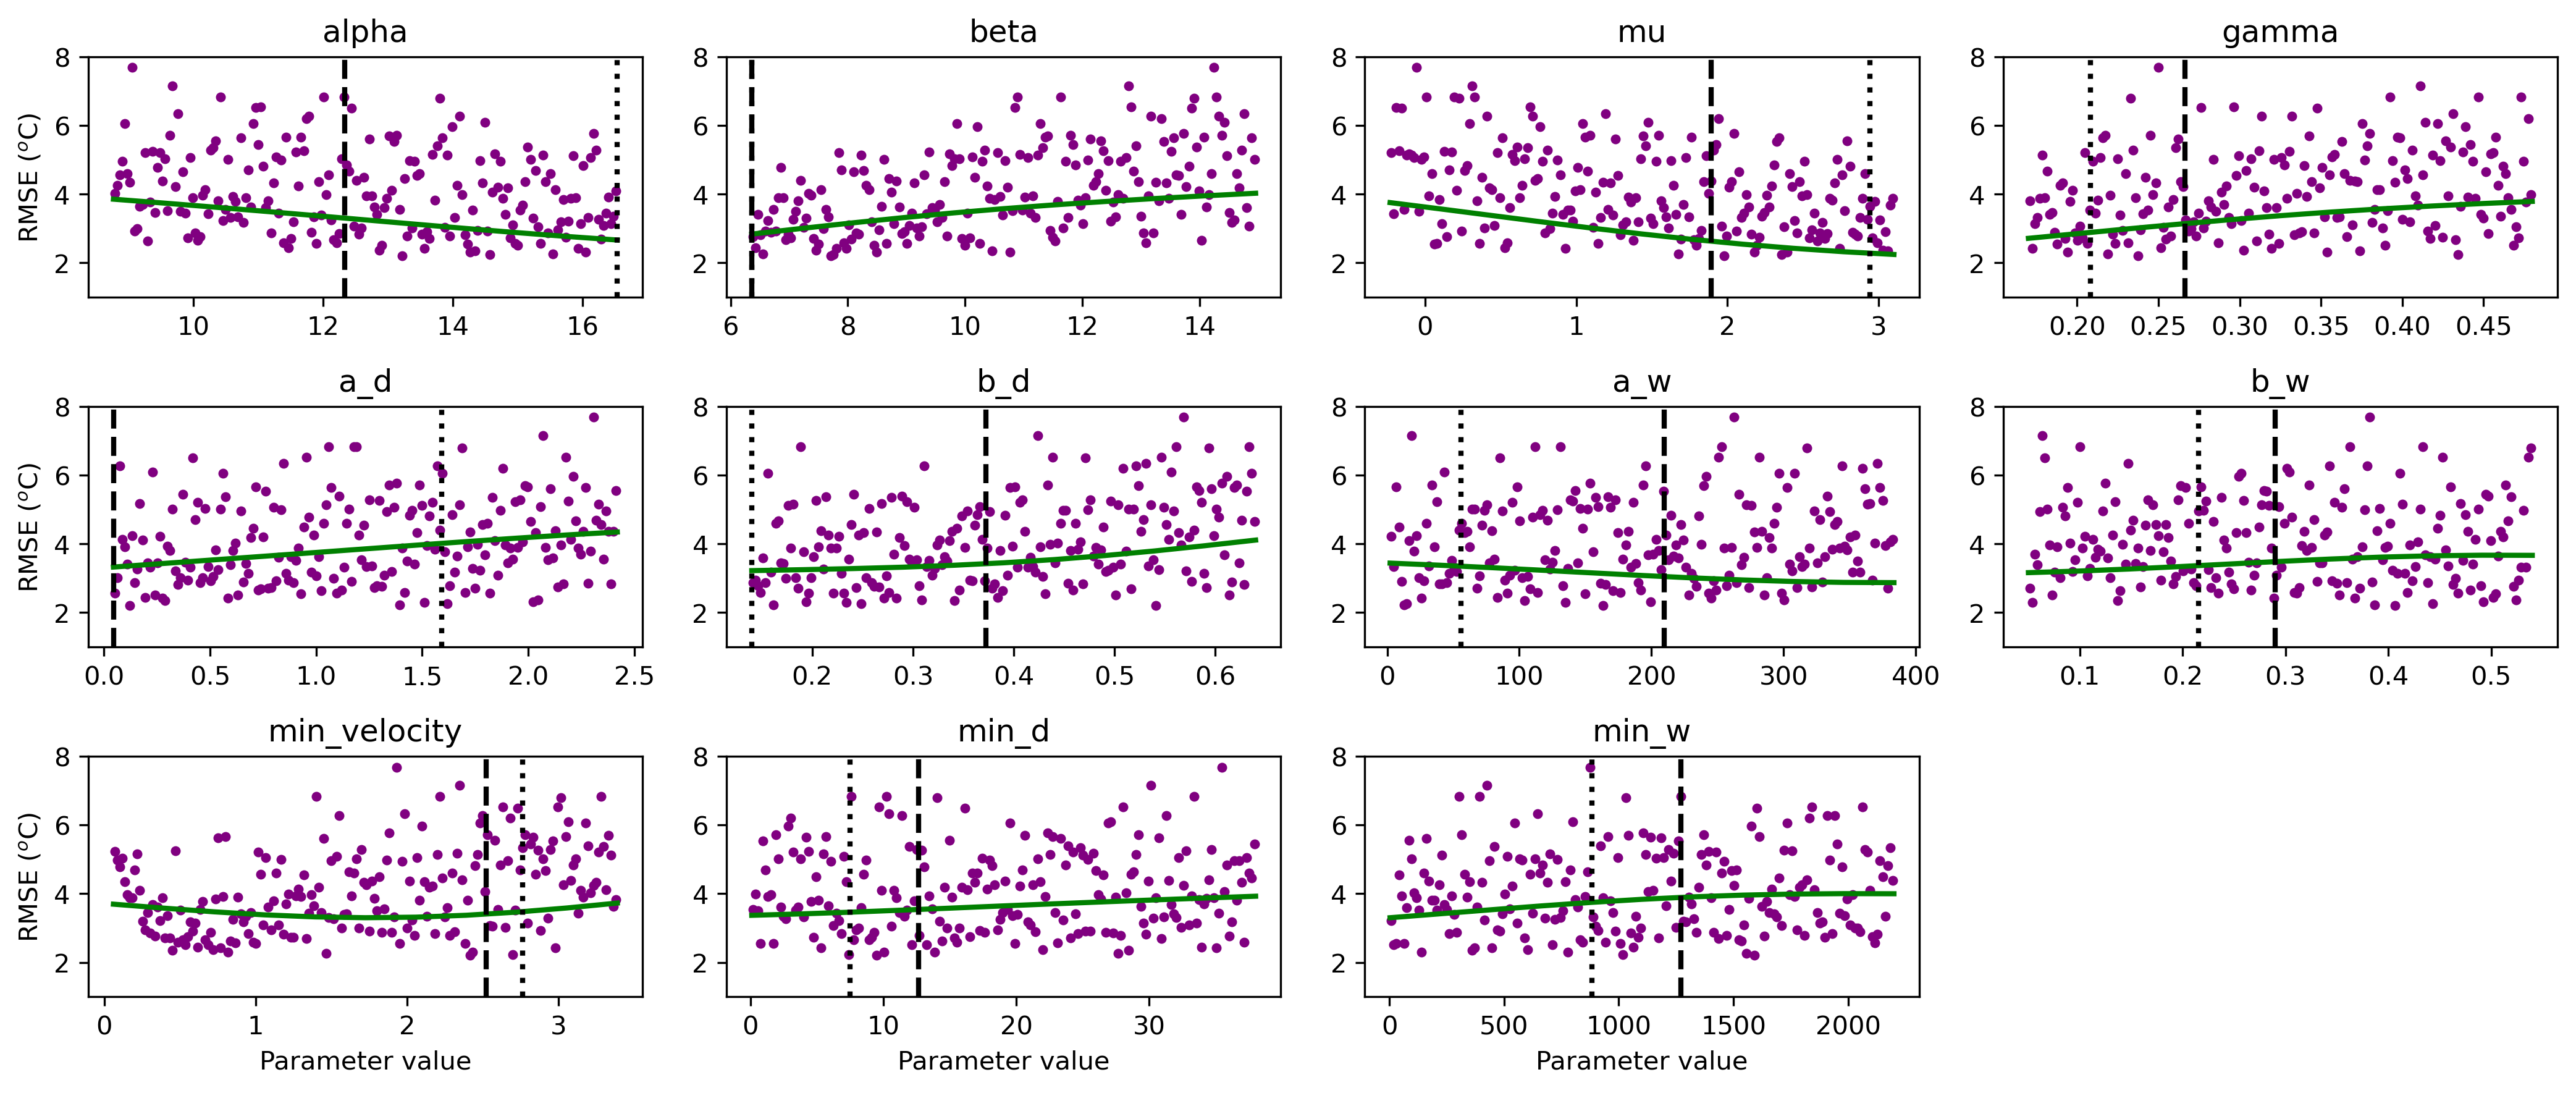

In [44]:
fig,ax = plt.subplots(3, 4,figsize=[14,6],dpi=300)
for i_param,param in enumerate(param_df.Var_name.values):
    y_sim = []
    lb = xlb_single_value_scaled[i_param]
    ub = xub_single_value_scaled[i_param]
    x_sim_list = []
    x_id = i_param
    for j in range(11):
        x = default_values.copy()
        x_sim = lb + (ub-lb)*j/10
        x[x_id] = x_sim
        x_sim_list.append(x_sim)
        y_sim.append(sm.predict(x)[0])
        y_sim_df = pd.DataFrame(y_sim,index=x_sim_list, columns=['flow_metric'])
        
    y_points = df_LHS.iloc[:, 2+i_param]
    
    result_values_filtered = result_values[param]
    
    col = i_param %4
    row = int(np.floor(i_param/4))
    ax[row,col].plot(y_sim_df.index.values*normalization_scalar[i_param],y_sim_df['flow_metric'].values, lw=2, c='green')
    ax[row,col].scatter(y_points, df_LHS['temp_rmse'].values, c='purple', s=8)
    ax[row,col].axvline(x=result_values_filtered[0], c="black", linestyle='--', lw=2)
    ax[row,col].axvline(x=result_values_filtered[1], c="black", linestyle=':', lw=2)
    ax[row,col].set_title("%s"%param)#ax[row,col].set_title("%s (#%s)"%(param,i_param+1))
    ax[row,col].set_ylim(1,8)
    xmin,xmax = ax[row,col].get_xlim()
    ymin,ymax = ax[row,col].get_ylim()
    if col == 0:
        ax[row,col].set_ylabel('RMSE ($^o$C)')
    if row == 2:
        ax[row,col].set_xlabel('Parameter value')

fig.delaxes(ax[2, 3])
plt.tight_layout()
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/model_scatter.png", dpi='figure')
plt.show()

## Optimization

### Overall

In [3]:
# Get CSV files list from a folder
csv_files = glob.glob('/glade/u/home/dblaskey/RBM/Optimization/LHS_results_raw_loc_*.csv')

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
final_opt_id = pd.concat(df_list, ignore_index=True)
final_opt_id["Iteration"] = final_opt_id["Name"].str.split("_", expand = True)[3]

In [116]:
final_opt = final_opt_id.groupby('Name').mean("temp_rmse").reset_index().drop(columns=['COMID', 'temp_pbias', 'Outlet'])
final_opt["Location"] = final_opt["Name"].str.split("_", expand = True)[2]
final_opt["Iteration"] = final_opt["Name"].str.split("_", expand = True)[3]
final_opt = final_opt[final_opt['Location'] != "0"]
final_opt

Name  temp_rmse      alpha      beta        mu  \
200   pe_basin_Interior_10_0000   2.224296  14.760260  6.360000  2.779443   
201   pe_basin_Interior_10_0001   2.223743  14.765354  6.360000  2.789402   
202   pe_basin_Interior_10_0002   2.225453  14.745357  6.360000  2.750855   
203   pe_basin_Interior_10_0003   2.222987  14.759950  6.360000  2.773186   
204   pe_basin_Interior_10_0004   2.145262  14.609332  6.360000  2.688895   
...                         ...        ...        ...       ...       ...   
1395      pe_basin_South_9_0015   1.714255  15.687527  6.398480 -0.054300   
1396      pe_basin_South_9_0016   1.743596  15.597291  6.367908 -0.049233   
1397      pe_basin_South_9_0017   1.730185  15.682342  6.368384 -0.044398   
1398      pe_basin_South_9_0018   1.637766  16.371948  6.360003 -0.110412   
1399      pe_basin_South_9_0019   1.759886  15.582090  6.360000 -0.065181   

         gamma       a_d       b_d         a_w       b_w  min_velocity  \
200   0.204584  0.107473  0.442376  114.053238  0.375331      2.660845   
201   0.204893  0.099392  0.440851  114.753860  0.375217      2.655547   
202   0.203388  0.095292  0.444015  113.775521  0.375595      2.659968   
203   0.204519  0.091948  0.444891  113.627744  0.376691      2.656890   
204   0.220306  0.045752  0.409942  128.101782  0.389896      2.714824   
...        ...       ...       ...         ...       ...           ...   
1395  0.170011  0.471756  0.365306  128.474442  0.500698      1.076381   
1396  0.170265  0.480841  0.359964  124.315048  0.497326      1.134822   
1397  0.170275  0.483067  0.357989  126.803394  0.496078      1.144573   
1398  0.170000  0.484691  0.339289  147.853638  0.468864      1.235653   
1399  0.170568  0.498144  0.360772  126.516581  0.499935      1.138247   

          min_d        min_w        Lat        Long  outlet_comid  outlet_id  \
200   19.998183  1259.523967  63.852288 -147.185024  8.102065e+07        NaN   
201   19.902601  1260.768594  63.852288 -147.185024  8.102065e+07        NaN   
202   20.248802  1259.997928  63.852288 -147.185024  8.102065e+07        NaN   
203   20.047994  1255.961143  63.852288 -147.185024  8.102065e+07        NaN   
204   18.241800  1189.891562  63.852288 -147.185024  8.102065e+07        NaN   
...         ...          ...        ...         ...           ...        ...   
1395  37.995055  1633.615844  60.905953 -150.972069  8.103043e+07        NaN   
1396  37.598366  1691.843818  60.905953 -150.972069  8.103043e+07        NaN   
1397  37.732454  1644.468979  60.905953 -150.972069  8.103043e+07        NaN   
1398  35.236873  2118.213546  60.905953 -150.972069  8.103043e+07        NaN   
1399  37.534610  1687.936441  60.905953 -150.972069  8.103043e+07        NaN   

      Location Iteration  
200   Interior        10  
201   Interior        10  
202   Interior        10  
203   Interior        10  
204   Interior        10  
...        ...       ...  
1395     South         9  
1396     South         9  
1397     South         9  
1398     South         9  
1399     South         9  

[1200 rows x 19 columns]

In [117]:
plot_df = final_opt[final_opt['temp_rmse'].isin(final_opt.groupby(['Location','Iteration']).min().temp_rmse.values)]
plot_df['Iteration'] = plot_df['Iteration'].astype(str).astype(int)
plot_df

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Name  temp_rmse      alpha      beta        mu  \
213   pe_basin_Interior_10_0013   2.142957  14.595198  6.360000  2.685890   
221   pe_basin_Interior_11_0001   2.066290  13.985214  6.378628  1.414274   
241   pe_basin_Interior_12_0001   2.074172  12.688111  6.360000  1.272578   
266   pe_basin_Interior_13_0006   1.946364  13.502950  6.429602  1.837380   
295   pe_basin_Interior_14_0015   1.937499  14.847698  6.417056  1.058963   
...                         ...        ...        ...       ...       ...   
1306      pe_basin_South_5_0006   1.546174  14.833954  6.360001  1.893798   
1337      pe_basin_South_6_0017   1.636643  12.322081  6.764628  1.995384   
1341      pe_basin_South_7_0001   1.465933  16.540000  6.360000 -0.160310   
1361      pe_basin_South_8_0001   1.511750  13.070474  6.360000  2.018221   
1381      pe_basin_South_9_0001   1.613612  16.188904  6.360000  0.000073   

         gamma       a_d       b_d         a_w       b_w  min_velocity  \
213   0.220365  0.052758  0.410738  127.970434  0.389319      2.717229   
221   0.205089  1.722471  0.168462  173.033117  0.434762      2.321827   
241   0.204476  1.893713  0.156259  271.320690  0.508808      2.191025   
266   0.297244  0.969445  0.255754  120.000221  0.306688      2.680119   
295   0.275735  0.921013  0.165818   44.501522  0.257084      2.357199   
...        ...       ...       ...         ...       ...           ...   
1306  0.226889  2.082191  0.265145   96.189483  0.347111      1.640155   
1337  0.383675  0.239578  0.438125  250.298562  0.052726      1.451208   
1341  0.170000  0.736681  0.212264   17.578838  0.359044      0.663050   
1361  0.361356  0.964766  0.331559  176.079348  0.251102      2.129834   
1381  0.170000  0.581176  0.311040  147.718142  0.482532      1.011346   

          min_d        min_w        Lat        Long  outlet_comid  outlet_id  \
213   18.087188  1186.246766  63.852288 -147.185024  8.102065e+07        NaN   
221   18.602877   515.872538  63.852288 -147.185024  8.102065e+07        NaN   
241   17.019811    14.932664  63.852288 -147.185024  8.102065e+07        NaN   
266   11.423940  1201.351340  63.852288 -147.185024  8.102065e+07        NaN   
295   13.179685  1300.575503  63.852288 -147.185024  8.102065e+07        NaN   
...         ...          ...        ...         ...           ...        ...   
1306  30.507043   383.281809  60.905953 -150.972069  8.103043e+07        NaN   
1337   6.867024   620.404250  60.905953 -150.972069  8.103043e+07        NaN   
1341  38.000000  2141.378557  60.905953 -150.972069  8.103043e+07        NaN   
1361   9.507273   402.070947  60.905953 -150.972069  8.103043e+07        NaN   
1381  38.000000  1979.144527  60.905953 -150.972069  8.103043e+07        NaN   

      Location  Iteration  
213   Interior         10  
221   Interior         11  
241   Interior         12  
266   Interior         13  
295   Interior         14  
...        ...        ...  
1306     South          5  
1337     South          6  
1341     South          7  
1361     South          8  
1381     South          9  

[65 rows x 19 columns]

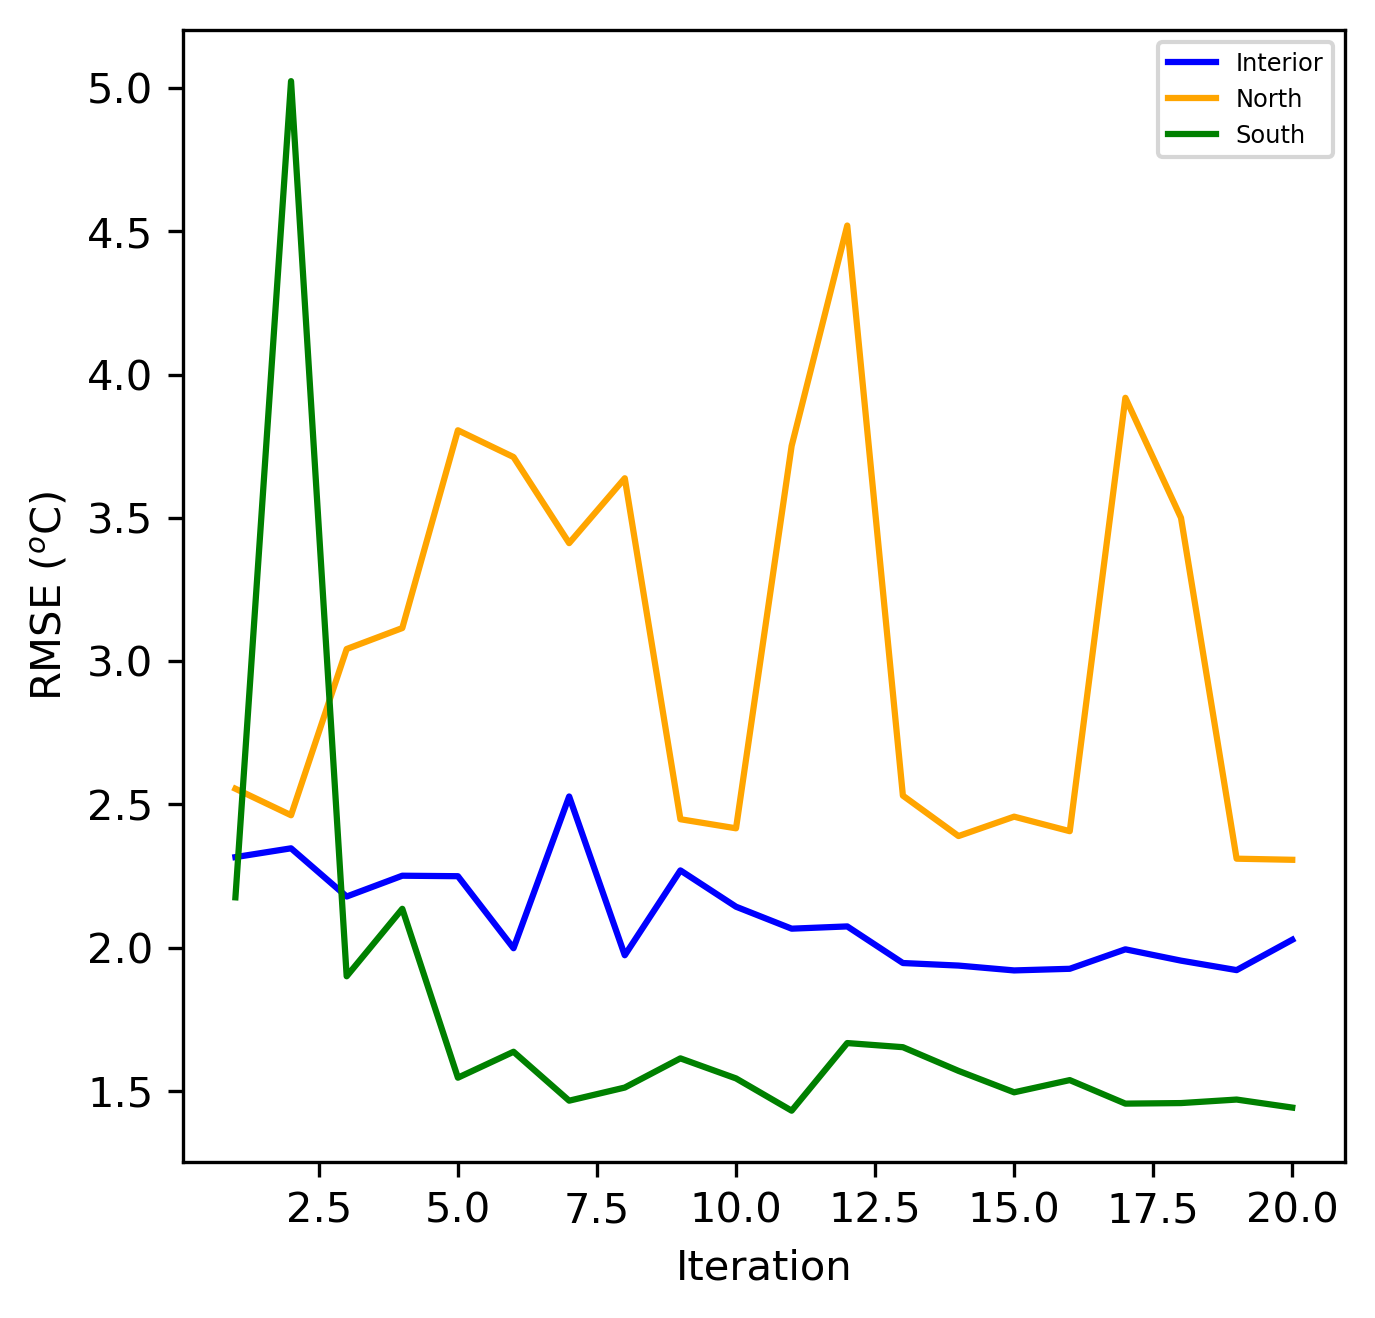

In [118]:
color_values = iter(['blue', 'orange', 'green'])
fig, ax = plt.subplots(figsize=[5,5],dpi=300)

for key, grp in plot_df.groupby(['Location']):
    grp=grp.sort_values('Iteration')
    grp.plot(ax=ax, x='Iteration', y='temp_rmse', c=next(color_values), label=key)  
plt.legend(loc='best', fontsize="xx-small")
plt.ylabel('RMSE ($^o$C)')
plt.xlabel('Iteration')
plt.show()

In [143]:
final_values_long = plot_df.loc[plot_df.groupby('Location')['temp_rmse'].idxmin()]
final_values = final_values_long.iloc[:,2:13]
final_values['Location'] = final_values_long['Location']
final_values

alpha      beta        mu     gamma       a_d       b_d         a_w  \
301   12.332417  6.360000  1.892998  0.266351  0.045732  0.372175  209.514215   
822   16.540000  6.360000  2.941564  0.208047  1.592664  0.140000   55.884606   
1025  13.085349  6.658474  2.034113  0.347912  1.219616  0.303750   85.470437   

           b_w  min_velocity      min_d        min_w  Location  
301   0.290223      2.523809  12.638491  1270.506558  Interior  
822   0.215721      2.764373   7.493126   883.735954     North  
1025  0.090076      1.642045  11.346057   599.715049     South

In [144]:
final_values.to_csv('/glade/u/home/dblaskey/RBM/Validation/Val_parameter_values.csv', index = False)

### Individual

In [122]:
plot_df_reduced = plot_df.groupby(['Iteration', 'Location']).first()

In [123]:
final_opt_id_plot = final_opt_id[final_opt_id.Name.isin(plot_df_reduced.Name.values)]
final_opt_id_plot['Iteration'] = final_opt_id_plot['Iteration'].astype(str).astype(int)
final_opt_id_plot

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


temp_rmse  temp_pbias     COMID                       Name      Outlet  \
1      3.160328   15.554349  81000092     pe_basin_North_16_0001  81000005.0   
21     1.652746   -2.015328  81002548     pe_basin_North_16_0001  81000433.0   
52     1.304938   -0.061179  81026220     pe_basin_South_17_0012  81027459.0   
72     1.611695   -1.737000  81027556     pe_basin_South_17_0012  81027546.0   
92     1.729481   12.318489  81030914     pe_basin_South_17_0012  81030912.0   
...         ...         ...       ...                        ...         ...   
5313   1.802932    4.776357  81015538  pe_basin_Interior_10_0013  81015538.0   
5333   2.652191  -21.362795  81015621  pe_basin_Interior_10_0013  81015621.0   
5353   1.973749    1.956431  81023679  pe_basin_Interior_10_0013  81030789.0   
5378   3.727042   29.007575  81000092      pe_basin_North_3_0018  81000005.0   
5398   2.357718    6.147013  81002548      pe_basin_North_3_0018  81000433.0   

          alpha       beta        mu     gamma       a_d  ...      min_d  \
1     16.206868   6.360000  3.100000  0.306971  0.908345  ...   0.424140   
21    16.206868   6.360000  3.100000  0.306971  0.908345  ...   0.424140   
52    16.540000   6.520982  0.588551  0.170000  0.587214  ...  22.144672   
72    16.540000   6.520982  0.588551  0.170000  0.587214  ...  22.144672   
92    16.540000   6.520982  0.588551  0.170000  0.587214  ...  22.144672   
...         ...        ...       ...       ...       ...  ...        ...   
5313  14.595198   6.360000  2.685890  0.220365  0.052758  ...  18.087188   
5333  14.595198   6.360000  2.685890  0.220365  0.052758  ...  18.087188   
5353  14.595198   6.360000  2.685890  0.220365  0.052758  ...  18.087188   
5378  13.818307  14.204115  2.503070  0.228496  0.045000  ...   0.100000   
5398  13.818307  14.204115  2.503070  0.228496  0.045000  ...   0.100000   

            min_w                        station_nm        Lat        Long  \
1      317.758529             MEADE R AT ATKASUK AK  70.495376 -157.395848   
21     317.758529  SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   
52    2193.094060             WILLOW C NR WILLOW AK  61.780303 -149.886679   
72    2193.094060          MATANUSKA R AT PALMER AK  61.608631 -149.073043   
92    2193.094060            KENAI R AT SOLDOTNA AK  60.476929 -151.081668   
...           ...                               ...        ...         ...   
5313  1186.246766             TANANA R AT NENANA AK  64.564944 -149.094000   
5333  1186.246766          SALCHA R NR SALCHAKET AK  64.471528 -146.928056   
5353  1186.246766         GULKANA R AT SOURDOUGH AK  62.520392 -145.533015   
5378  2102.934953             MEADE R AT ATKASUK AK  70.495376 -157.395848   
5398  2102.934953  SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   

      outlet_comid type  Location  outlet_id  Iteration  
1         81000005  Opt     North        NaN         16  
21        81000433  Opt     North        NaN         16  
52        81027459  Opt     South        NaN         17  
72        81027546  Opt     South        NaN         17  
92        81030912  Opt     South        NaN         17  
...            ...  ...       ...        ...        ...  
5313      81015538  Opt  Interior        NaN         10  
5333      81015621  Opt  Interior        NaN         10  
5353      81030789  Opt  Interior        NaN         10  
5378      81000005  Opt     North        NaN          3  
5398      81000433  Opt     North        NaN          3  

[180 rows x 24 columns]

In [ ]:
/glade/work/dblaskey/RBM/src/rbm10_mizu /glade/scratch/dblaskey/RBM/RBM_Input/Validation/%s/%s /glade/scratch/dblaskey/RBM/Output/Validation/%s/%s

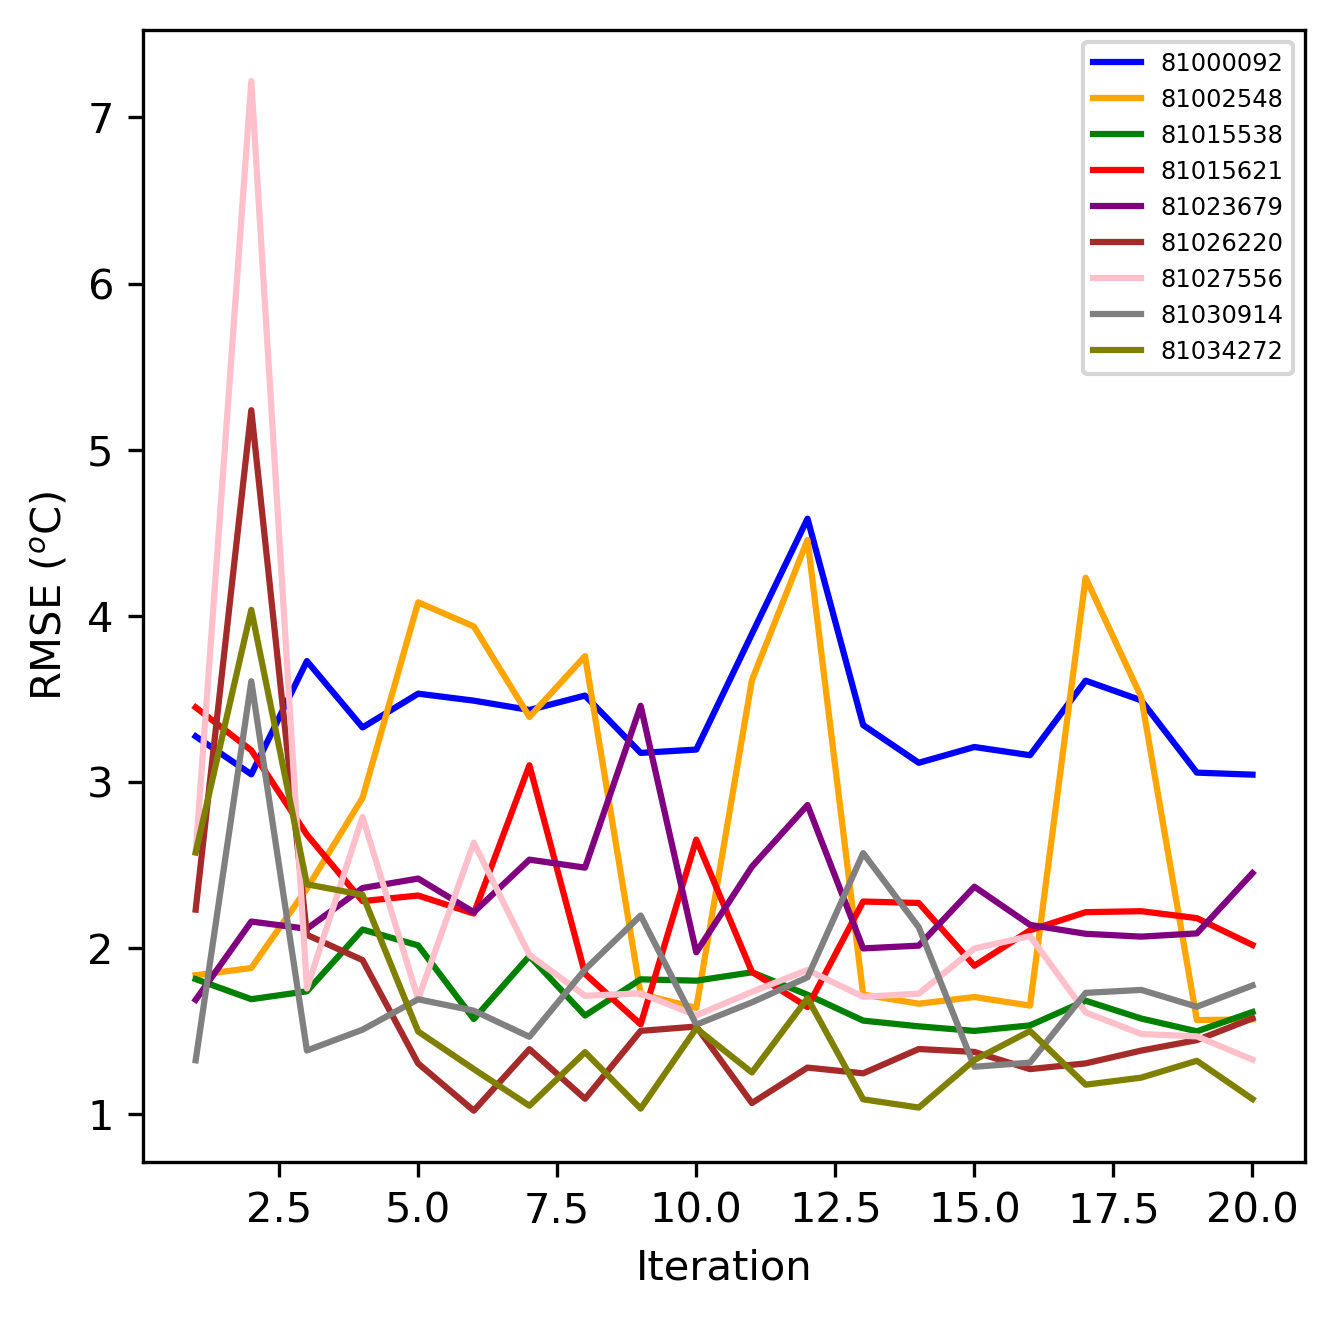

In [124]:
color_values = iter(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

fig, ax = plt.subplots(figsize=[5,5],dpi=300)

for key, grp in final_opt_id_plot.groupby(['COMID']):
    grp=grp.sort_values('Iteration')
    grp.plot(ax=ax, x='Iteration', y='temp_rmse', c=next(color_values), label=key)  
plt.legend(loc='best', fontsize="xx-small")
plt.ylabel('RMSE ($^o$C)')
plt.xlabel('Iteration')
plt.show()

## Validation

### Overall

In [159]:
#### Begin Code #####
df_sites = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv', index_col=0)

# Read in Observed Data
temp_data = pd.read_csv('/glade/scratch/dblaskey/RBM/temperature_gages.csv', index_col=0)
df = pd.merge(temp_data, df_sites, on="site_no")

start_date = '2017-01-01'
end_date = '2021-09-29'
years = range(2017,2022)
time_series = pd.date_range(start_date, end_date)

pre_lines = ["[INPUT]", 
"output_energy_nc: /glade/scratch/tcraig/archive/NNA.4km.hERA5.1989.003.pp/lnd/hist/NNA.4km.hERA5.1989.003.clm2.hrbm2.", "","[PARAM]", "start_date: 20170101", "end_date: 20210930", "seg_minflow : 4", "sd_time_step: 1", "", "[RBM_OPTIONS]", "min_flow : 5", "", "[OPT]"]

location="pe_basin"

psets_df = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_runs.csv')
psets_df.rename(columns={ psets_df.columns[0]: "Name" }, inplace = True)


list_rmse = []
list_pbias = []
list_comid = []
list_folder = []
list_outlet = []

for folder in np.unique(psets_df.Name.values):
    for outlet in np.unique(df_sites.outlet_comid.values):
        print(folder, outlet)
        gages = df_sites.loc[df_sites['outlet_comid'] == outlet]
        comids = gages.COMID
        site_nos = gages.index.values

        # Specify path
        ds_rbm = xr.open_mfdataset('/glade/scratch/dblaskey/RBM/Output/Validation/%s/%s_*.nc'%(folder, outlet))
        reachID_list = np.rint(ds_rbm.hru.values).astype(int)

        for i,comid in enumerate(comids):
            # Filter to just one gage for simulations
            seg_sel = np.where(reachID_list == comid)[0][0]
            sim_flow = ds_rbm.T_stream.sel(hru=reachID_list[seg_sel], no_seg=2)
            sim_flow.load()
            sim_df = pd.DataFrame(sim_flow, index=time_series, columns=['sim'])
            sim_df.index.name = 'Date'

            # Filter to just one gage for observations
            temp_df = df[df['site_no']== site_nos[i]][['X_00010_00003', 'Date']]
            temp_df = temp_df.rename(columns={"X_00010_00003": "obs"})
            temp_df = temp_df.set_index('Date')
            temp_df.index = pd.to_datetime(temp_df.index)

            # Combine simulation and observation datasets
            df_concat = pd.concat([sim_df,temp_df],axis=1)
            df_concat = df_concat.dropna()
            df_concat = df_concat.loc['2017-10-01':'2021-09-29']
            df_concat = df_concat[df_concat.index.month.isin([5,6,7,8,9])]
            df_concat = df_concat.reset_index()

            # return the results
            list_rmse.append(he.evaluator(he.rmse, df_concat.sim.values, df_concat.obs.values)[0])
            list_pbias.append(he.evaluator(he.pbias, df_concat.sim.values, df_concat.obs.values)[0])
            list_comid.append(np.int(comid))
            list_folder.append(folder)
            list_outlet.append(outlet)

Baseline_loc 81000005
Baseline_loc 81000402
Baseline_loc 81000433
Baseline_loc 81014324
Baseline_loc 81020021
Baseline_loc 81027459
Baseline_loc 81027546
Baseline_loc 81030789
Baseline_loc 81030912
Baseline_loc 81035777
Baseline_loc 81035794
Optimized_loc 81000005
Optimized_loc 81000402
Optimized_loc 81000433
Optimized_loc 81014324
Optimized_loc 81020021
Optimized_loc 81027459
Optimized_loc 81027546
Optimized_loc 81030789
Optimized_loc 81030912
Optimized_loc 81035777
Optimized_loc 81035794


In [160]:
val_results = pd.DataFrame({'RMSE':list_rmse, 'PBias':list_pbias, 'COMID':list_comid, 'outlet_id': list_outlet, 'folder': list_folder})
val_basins = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv')
val_results = val_results.merge(val_basins)

In [83]:
#val_results['type'] = np.where(val_results.type.values == "OB", 'OG', val_results.type.values)
val_results.groupby(['folder','type']).RMSE.mean()

folder         type
Baseline_loc   OG      3.045952
               VB      4.725227
               VG      2.908737
Optimized_loc  OG      1.919026
               VB      2.178533
               VG      2.733921
Name: RMSE, dtype: float64

In [81]:
val_results.groupby(['folder']).RMSE.mean()

folder
Baseline_loc     3.280093
Optimized_loc    2.233909
Name: RMSE, dtype: float64

In [82]:
val_results.groupby(['folder', 'Location']).RMSE.mean()

folder         Location
Baseline_loc   Interior    4.434671
               North       3.153621
               South       2.014777
Optimized_loc  Interior    2.737051
               North       2.253133
               South       1.650650
Name: RMSE, dtype: float64

In [34]:
val_results

RMSE      PBias     COMID  outlet_id         folder   site_no  \
0   3.656432  29.790955  81000092   81000005   Baseline_loc  15803000   
1   2.643331   4.538184  81000092   81000005  Optimized_loc  15803000   
2   3.227620  23.036157  81000403   81000402   Baseline_loc  15896000   
3   2.464168  -2.468704  81000403   81000402  Optimized_loc  15896000   
4   2.576812  20.298917  81002548   81000433   Baseline_loc  15908000   
5   1.651900  -6.330062  81002548   81000433  Optimized_loc  15908000   
6   4.506785  47.722941  81014331   81014324   Baseline_loc  15580095   
7   1.380485  -2.094348  81014331   81014324  Optimized_loc  15580095   
8   2.096038  18.635204  81012001   81020021   Baseline_loc  15519100   
9   2.835476 -29.323532  81012001   81020021  Optimized_loc  15519100   
10  1.340108   7.459877  81014458   81020021   Baseline_loc  15493000   
11  3.654171 -53.182831  81014458   81020021  Optimized_loc  15493000   
12  4.614365  34.738055  81015538   81020021   Baseline_loc  15515500   
13  1.960632   4.652406  81015538   81020021  Optimized_loc  15515500   
14  2.596670  22.468304  81015621   81020021   Baseline_loc  15484000   
15  2.561733 -20.718191  81015621   81020021  Optimized_loc  15484000   
16  7.885925  56.866135  81025423   81020021   Baseline_loc  15565447   
17  4.291404  24.675402  81025423   81020021  Optimized_loc  15565447   
18  5.441250  61.095701  81023793   81027459   Baseline_loc  15292700   
19  1.319436   9.448510  81023793   81027459  Optimized_loc  15292700   
20  4.493014  51.770019  81026220   81027459   Baseline_loc  15294005   
21  1.232342  -0.926783  81026220   81027459  Optimized_loc  15294005   
22  1.210667  -3.250889  81026903   81027546   Baseline_loc  15283700   
23  2.216545 -23.220205  81026903   81027546  Optimized_loc  15283700   
24  1.523531   3.757262  81027556   81027546   Baseline_loc  15284000   
25  1.872234  -7.773563  81027556   81027546  Optimized_loc  15284000   
26  5.996204  50.714888  81023679   81030789   Baseline_loc  15200280   
27  2.521562  11.501561  81023679   81030789  Optimized_loc  15200280   
28  3.260960  26.194007  81030914   81030912   Baseline_loc  15266300   
29  1.475455   7.798243  81030914   81030912  Optimized_loc  15266300   
30  2.829743  13.671670  81030990   81030912   Baseline_loc  15258000   
31  2.304516  -5.989799  81030990   81030912  Optimized_loc  15258000   
32  3.811423  29.557032  81034003   81035777   Baseline_loc  15302000   
33  2.155740  12.252650  81034003   81035777  Optimized_loc  15302000   
34  1.556636  12.311486  81034272   81035794   Baseline_loc  15300300   
35  1.442677  -8.719940  81034272   81035794  Optimized_loc  15300300   

                                 station_nm        Lat        Long  \
0                     MEADE R AT ATKASUK AK  70.495376 -157.395848   
1                     MEADE R AT ATKASUK AK  70.495376 -157.395848   
2                 KUPARUK R NR DEADHORSE AK  70.281385 -148.962786   
3                 KUPARUK R NR DEADHORSE AK  70.281385 -148.962786   
4          SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   
5          SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   
6      NIUKLUK R AB MELSING C AT COUNCIL AK  64.891944 -163.670000   
7      NIUKLUK R AB MELSING C AT COUNCIL AK  64.891944 -163.670000   
8   TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841 -148.631114   
9   TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841 -148.631114   
10                 CHENA R NR TWO RIVERS AK  64.901972 -146.361333   
11                 CHENA R NR TWO RIVERS AK  64.901972 -146.361333   
12                    TANANA R AT NENANA AK  64.564944 -149.094000   
13                    TANANA R AT NENANA AK  64.564944 -149.094000   
14                 SALCHA R NR SALCHAKET AK  64.471528 -146.928056   
15                 SALCHA R NR SALCHAKET AK  64.471528 -146.928056   
16              YUKON R AT PILOT STATION AK  61.933687 -162.882936   
17              YUKON R AT PILOT STATION AK  6

In [164]:
val_results.to_csv('/glade/u/home/dblaskey/RBM/Validation/Val_raw_loc.csv', index=False)

In [79]:
val_results = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_raw_loc.csv')
val_results

RMSE      PBias     COMID  outlet_id         folder   site_no  \
0   3.656432  29.790955  81000092   81000005   Baseline_loc  15803000   
1   2.643331   4.538184  81000092   81000005  Optimized_loc  15803000   
2   3.227620  23.036157  81000403   81000402   Baseline_loc  15896000   
3   2.464168  -2.468704  81000403   81000402  Optimized_loc  15896000   
4   2.576812  20.298917  81002548   81000433   Baseline_loc  15908000   
5   1.651900  -6.330062  81002548   81000433  Optimized_loc  15908000   
6   4.506785  47.722941  81014331   81014324   Baseline_loc  15580095   
7   1.380485  -2.094348  81014331   81014324  Optimized_loc  15580095   
8   2.096038  18.635204  81012001   81020021   Baseline_loc  15519100   
9   2.835476 -29.323532  81012001   81020021  Optimized_loc  15519100   
10  1.340108   7.459877  81014458   81020021   Baseline_loc  15493000   
11  3.654171 -53.182831  81014458   81020021  Optimized_loc  15493000   
12  4.614365  34.738055  81015538   81020021   Baseline_loc  15515500   
13  1.960632   4.652406  81015538   81020021  Optimized_loc  15515500   
14  2.596670  22.468304  81015621   81020021   Baseline_loc  15484000   
15  2.561733 -20.718191  81015621   81020021  Optimized_loc  15484000   
16  7.885925  56.866135  81025423   81020021   Baseline_loc  15565447   
17  4.291404  24.675402  81025423   81020021  Optimized_loc  15565447   
18  2.089942  16.960195  81023793   81027459   Baseline_loc  15292700   
19  1.101416   4.137806  81023793   81027459  Optimized_loc  15292700   
20  1.631961   9.173712  81026220   81027459   Baseline_loc  15294005   
21  1.141711  -6.952863  81026220   81027459  Optimized_loc  15294005   
22  1.210667  -3.250889  81026903   81027546   Baseline_loc  15283700   
23  2.216545 -23.220205  81026903   81027546  Optimized_loc  15283700   
24  1.523531   3.757262  81027556   81027546   Baseline_loc  15284000   
25  1.872234  -7.773563  81027556   81027546  Optimized_loc  15284000   
26  5.996204  50.714888  81023679   81030789   Baseline_loc  15200280   
27  2.521562  11.501561  81023679   81030789  Optimized_loc  15200280   
28  3.260960  26.194007  81030914   81030912   Baseline_loc  15266300   
29  1.475455   7.798243  81030914   81030912  Optimized_loc  15266300   
30  2.829743  13.671670  81030990   81030912   Baseline_loc  15258000   
31  2.304516  -5.989799  81030990   81030912  Optimized_loc  15258000   
32  6.441275  58.325423  81034003   81035777   Baseline_loc  15302000   
33  2.690947  16.687075  81034003   81035777  Optimized_loc  15302000   
34  1.556636  12.311486  81034272   81035794   Baseline_loc  15300300   
35  1.442677  -8.719940  81034272   81035794  Optimized_loc  15300300   

                                 station_nm        Lat        Long  \
0                     MEADE R AT ATKASUK AK  70.495376 -157.395848   
1                     MEADE R AT ATKASUK AK  70.495376 -157.395848   
2                 KUPARUK R NR DEADHORSE AK  70.281385 -148.962786   
3                 KUPARUK R NR DEADHORSE AK  70.281385 -148.962786   
4          SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   
5          SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   
6      NIUKLUK R AB MELSING C AT COUNCIL AK  64.891944 -163.670000   
7      NIUKLUK R AB MELSING C AT COUNCIL AK  64.891944 -163.670000   
8   TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841 -148.631114   
9   TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841 -148.631114   
10                 CHENA R NR TWO RIVERS AK  64.901972 -146.361333   
11                 CHENA R NR TWO RIVERS AK  64.901972 -146.361333   
12                    TANANA R AT NENANA AK  64.564944 -149.094000   
13                    TANANA R AT NENANA AK  64.564944 -149.094000   
14                 SALCHA R NR SALCHAKET AK  64.471528 -146.928056   
15                 SALCHA R NR SALCHAKET AK  64.471528 -146.928056   
16              YUKON R AT PILOT STATION AK  61.933687 -162.882936   
17              YUKON R AT PILOT STATION AK  6

### Monthly

In [165]:
#### Begin Code #####
df_sites = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv', index_col=0)

# Read in Observed Data
temp_data = pd.read_csv('/glade/scratch/dblaskey/RBM/temperature_gages.csv', index_col=0)
df = pd.merge(temp_data, df_sites, on="site_no")

start_date = '2017-01-01'
end_date = '2021-09-29'
years = range(2017,2022)
time_series = pd.date_range(start_date, end_date)

pre_lines = ["[INPUT]", 
"output_energy_nc: /glade/scratch/tcraig/archive/NNA.4km.hERA5.1989.003.pp/lnd/hist/NNA.4km.hERA5.1989.003.clm2.hrbm2.", "","[PARAM]", "start_date: 20170101", "end_date: 20210930", "seg_minflow : 4", "sd_time_step: 1", "", "[RBM_OPTIONS]", "min_flow : 5", "", "[OPT]"]

location="pe_basin"

psets_df = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_runs.csv')
psets_df.rename(columns={ psets_df.columns[0]: "Name" }, inplace = True)


list_rmse = []
list_pbias = []
list_comid = []
list_folder = []
list_outlet = []
list_m = []

for folder in np.unique(psets_df.Name.values):
    for outlet in np.unique(df_sites.outlet_comid.values):
        print(folder, outlet)
        gages = df_sites.loc[df_sites['outlet_comid'] == outlet]
        comids = gages.COMID
        site_nos = gages.index.values

        # Specify path
        ds_rbm = xr.open_mfdataset('/glade/scratch/dblaskey/RBM/Output/Validation/%s/%s_*.nc'%(folder, outlet))
        reachID_list = np.rint(ds_rbm.hru.values).astype(int)

        for i,comid in enumerate(comids):
            # Filter to just one gage for simulations
            seg_sel = np.where(reachID_list == comid)[0][0]
            sim_flow = ds_rbm.T_stream.sel(hru=reachID_list[seg_sel], no_seg=2)
            sim_flow.load()
            sim_df = pd.DataFrame(sim_flow, index=time_series, columns=['sim'])
            sim_df.index.name = 'Date'

            # Filter to just one gage for observations
            temp_df = df[df['site_no']== site_nos[i]][['X_00010_00003', 'Date']]
            temp_df = temp_df.rename(columns={"X_00010_00003": "obs"})
            temp_df = temp_df.set_index('Date')
            temp_df.index = pd.to_datetime(temp_df.index)

            # Combine simulation and observation datasets
            df_concat = pd.concat([sim_df,temp_df],axis=1)
            df_concat = df_concat.dropna()
            df_concat = df_concat.loc['2017-10-01':'2021-09-29']
            for m in range(4,10):
                df_concat_m = df_concat[df_concat.index.month == m]
                df_concat_m = df_concat_m.reset_index()

                # return the results
                list_rmse.append(he.evaluator(he.rmse, df_concat_m.sim.values, df_concat_m.obs.values)[0])
                list_pbias.append(he.evaluator(he.pbias, df_concat_m.sim.values, df_concat_m.obs.values)[0])
                list_comid.append(np.int(comid))
                list_folder.append(folder)
                list_outlet.append(outlet)
                list_m.append(m)


Baseline_loc 81000005


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Baseline_loc 81000402


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Baseline_loc 81000433


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Baseline_loc 81014324


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Baseline_loc 81020021


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Baseline_loc 81027459
Baseline_loc 81027546
Baseline_loc 81030789
Baseline_loc 81030912
Baseline_loc 81035777
Baseline_loc 81035794
Optimized_loc 81000005


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Optimized_loc 81000402


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Optimized_loc 81000433


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Optimized_loc 81014324


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Optimized_loc 81020021


/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/hydroeval/objective_functions.py:110: RuntimeWarning: invalid value encountered in true_divide
  pbias_ = 100 * np.sum(evaluation - simulation_s, axis=0, dtype=np.float64) / np.sum(evaluation)


Optimized_loc 81027459
Optimized_loc 81027546
Optimized_loc 81030789
Optimized_loc 81030912
Optimized_loc 81035777
Optimized_loc 81035794


In [166]:
val_results_m = pd.DataFrame({'RMSE':list_rmse, 'PBias':list_pbias, 'COMID':list_comid, 'outlet_id': list_outlet, 'Month': list_m, 'folder': list_folder})
val_basins = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv')
val_results_m = val_results_m.merge(val_basins)
val_results_m

RMSE      PBias     COMID  outlet_id  Month         folder   site_no  \
0         NaN        NaN  81000092   81000005      4   Baseline_loc  15803000   
1    0.820000  54.666667  81000092   81000005      5   Baseline_loc  15803000   
2    4.339813  33.466867  81000092   81000005      6   Baseline_loc  15803000   
3    4.827208  33.504239  81000092   81000005      7   Baseline_loc  15803000   
4    2.859522  29.312027  81000092   81000005      8   Baseline_loc  15803000   
..        ...        ...       ...        ...    ...            ...       ...   
211  1.008309   9.833613  81034272   81035794      5  Optimized_loc  15300300   
212  1.753687 -17.925697  81034272   81035794      6  Optimized_loc  15300300   
213  2.057444 -16.256906  81034272   81035794      7  Optimized_loc  15300300   
214  1.148868  -6.755374  81034272   81035794      8  Optimized_loc  15300300   
215  0.870372  -5.873746  81034272   81035794      9  Optimized_loc  15300300   

                    station_nm        Lat        Long  outlet_comid type  \
0        MEADE R AT ATKASUK AK  70.495376 -157.395848      81000005   OB   
1        MEADE R AT ATKASUK AK  70.495376 -157.395848      81000005   OB   
2        MEADE R AT ATKASUK AK  70.495376 -157.395848      81000005   OB   
3        MEADE R AT ATKASUK AK  70.495376 -157.395848      81000005   OB   
4        MEADE R AT ATKASUK AK  70.495376 -157.395848      81000005   OB   
..                         ...        ...         ...           ...  ...   
211  ILIAMNA R NR PEDRO BAY AK  59.757950 -153.846887      81035794   OB   
212  ILIAMNA R NR PEDRO BAY AK  59.757950 -153.846887      81035794   OB   
213  ILIAMNA R NR PEDRO BAY AK  59.757950 -153.846887      81035794   OB   
214  ILIAMNA R NR PEDRO BAY AK  59.757950 -153.846887      81035794   OB   
215  ILIAMNA R NR PEDRO BAY AK  59.757950 -153.846887      81035794   OB   

    Location  
0      North  
1      North  
2      North  
3      North  
4      North  
..       ...  
211    South  
212    South  
213    South  
214    South  
215    South  

[216 rows x 13 columns]

In [167]:
val_results_m.to_csv('/glade/u/home/dblaskey/RBM/Validation/Val_temp_month.csv', index = False)

### Plot Data

In [84]:
val_results_m = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_temp_month.csv')
val_results = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_raw_loc.csv')

In [85]:
val_results_opt = val_results[val_results['folder'] == 'Optimized_loc']
print(val_results_opt.RMSE.max(), val_results_opt.RMSE.min(), val_results_opt.RMSE.mean(), val_results_opt.RMSE.median())

4.29140368507034 1.1014160651674 2.2339090103234542 2.2605304291976847


In [86]:
val_results_m_opt = val_results_m[val_results_m['folder'] == 'Optimized_loc']

for m in [5,6,7,8,9]:
    temporary = val_results_m_opt[val_results_m_opt['Month'] == m]
    print(temporary.RMSE.max(), temporary.RMSE.min(), temporary.RMSE.mean(), temporary.RMSE.median())

7.072160207461367 0.9579931139896638 2.6815477162046224 2.1185974609281204
4.895640662875493 0.9994523500397604 2.185320425835601 1.8359266466146595
6.060682977293937 1.200648682198301 2.528553176098667 2.307798637693939
4.274443748002623 0.6965977225750699 2.1723915203116944 1.9303378537001334
3.479263179023335 0.8703722761897139 1.877433155803215 1.709594459477421


In [93]:
df_reduced.groupby(['Month', 'folder', 'Location']).RMSE.mean()

Month  folder         Location
5      Baseline_loc   Interior    3.152259
                      South       1.342390
       Optimized_loc  Interior    2.594523
                      South       1.063754
6      Baseline_loc   Interior    5.160962
                      North       3.513906
                      South       1.690968
       Optimized_loc  Interior    2.643024
                      North       2.593651
                      South       1.487232
7      Baseline_loc   Interior    5.169893
                      North       3.668192
                      South       2.172131
       Optimized_loc  Interior    2.852387
                      North       2.444557
                      South       2.194455
8      Baseline_loc   Interior    4.174525
                      North       2.920354
                      South       2.088693
       Optimized_loc  Interior    2.862958
                      North       1.457217
                      South       1.689676
9      Baseline_loc   I

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/indexes/base.py:4105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


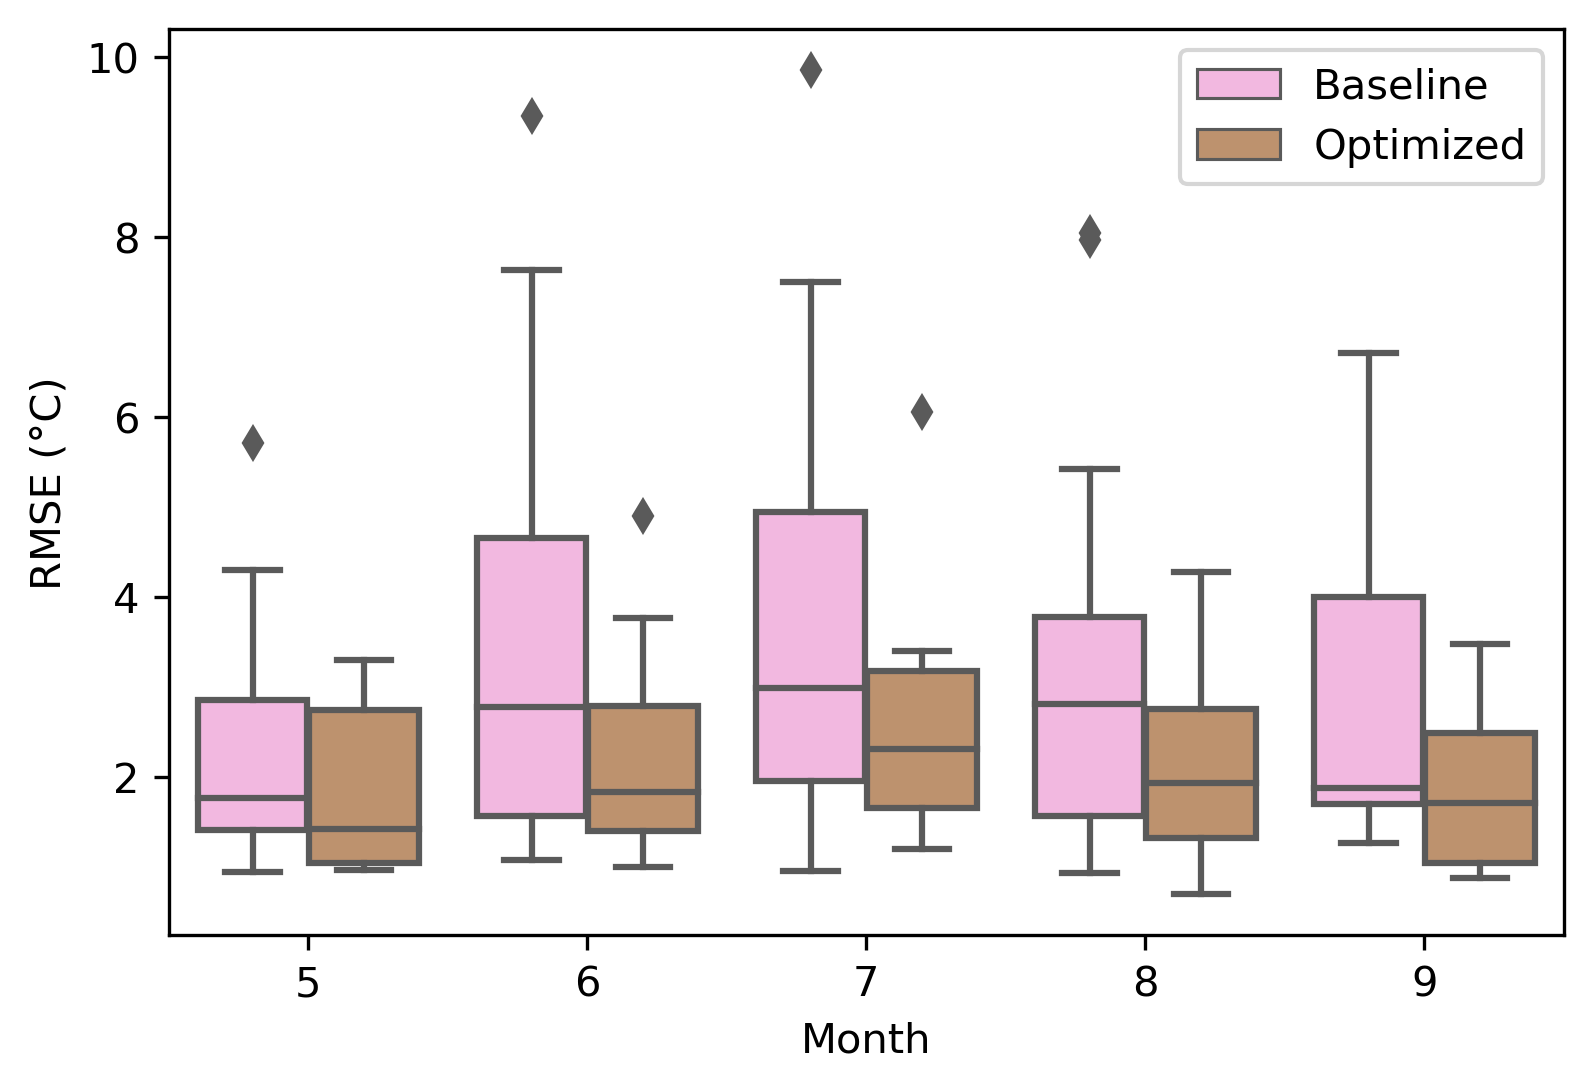

In [92]:
df_reduced = val_results_m[['RMSE', 'COMID', 'Month', 'folder', 'Location']]
df_reduced = df_reduced[df_reduced['Month'] > 4].reset_index()
a = np.where((df_reduced['Month'] == 5) & (df_reduced['Location'] == 'North'))[0].tolist()
df_reduced = df_reduced.drop(df_reduced.index[[a]])

legend_label = ["Baseline", "Optimized"]

palette = sns.color_palette("colorblind",n_colors=7)
palette.reverse()

plt.figure(dpi=300)
ax = sns.boxplot(x="Month", y="RMSE", hue="folder", data=df_reduced, palette=palette)  # RUN PLOT   
ax.legend(title="")
for n,i in enumerate(legend_label):
    ax.legend_.texts[n].set_text(i)

plt.ylabel('RMSE (°C)')
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/bbplot_Val.png", dpi='figure')
plt.show()

In [172]:
df_reduced['Location'] = np.where(df_reduced.Location.values == "Interior", 'Central', df_reduced.Location.values)

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/indexes/base.py:4105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


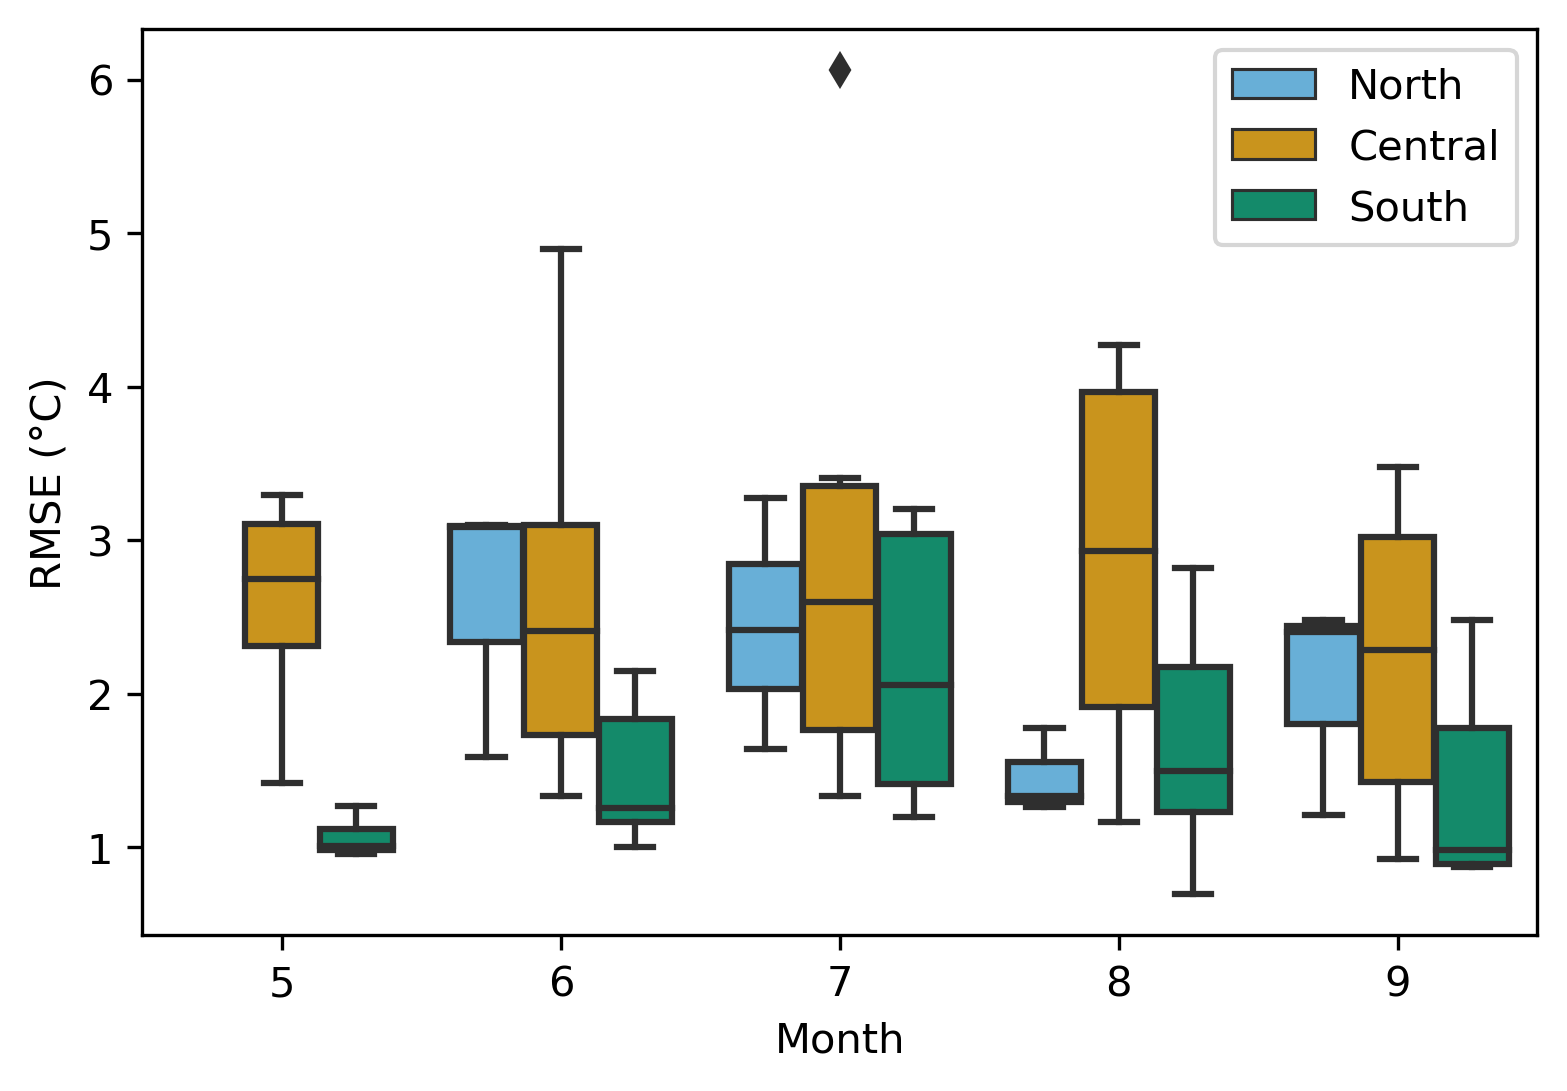

In [173]:
df_reduced = val_results_m_opt[['RMSE', 'COMID', 'Month', 'Location']]
df_reduced = df_reduced[df_reduced['Month'] > 4].reset_index()
df_reduced['Location'] = np.where(df_reduced.Location.values == "Interior", 'Central', df_reduced.Location.values)
a = np.where((df_reduced['Month'] == 5) & (df_reduced['Location'] == 'North'))[0].tolist()
df_reduced = df_reduced.drop(df_reduced.index[[a]])

#legend_label = ["Default", "Optimized"]
my_pal = ['#56B4E9', '#E69F00', '#009E73']
plt.figure(dpi=300)
ax = sns.boxplot(x="Month", y="RMSE", hue="Location", data=df_reduced, palette=my_pal)  # RUN PLOT   
ax.legend(title="")

plt.ylabel('RMSE (°C)')
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/bbplot_Val_loc.png", dpi='figure')
plt.show()

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/indexes/base.py:4105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


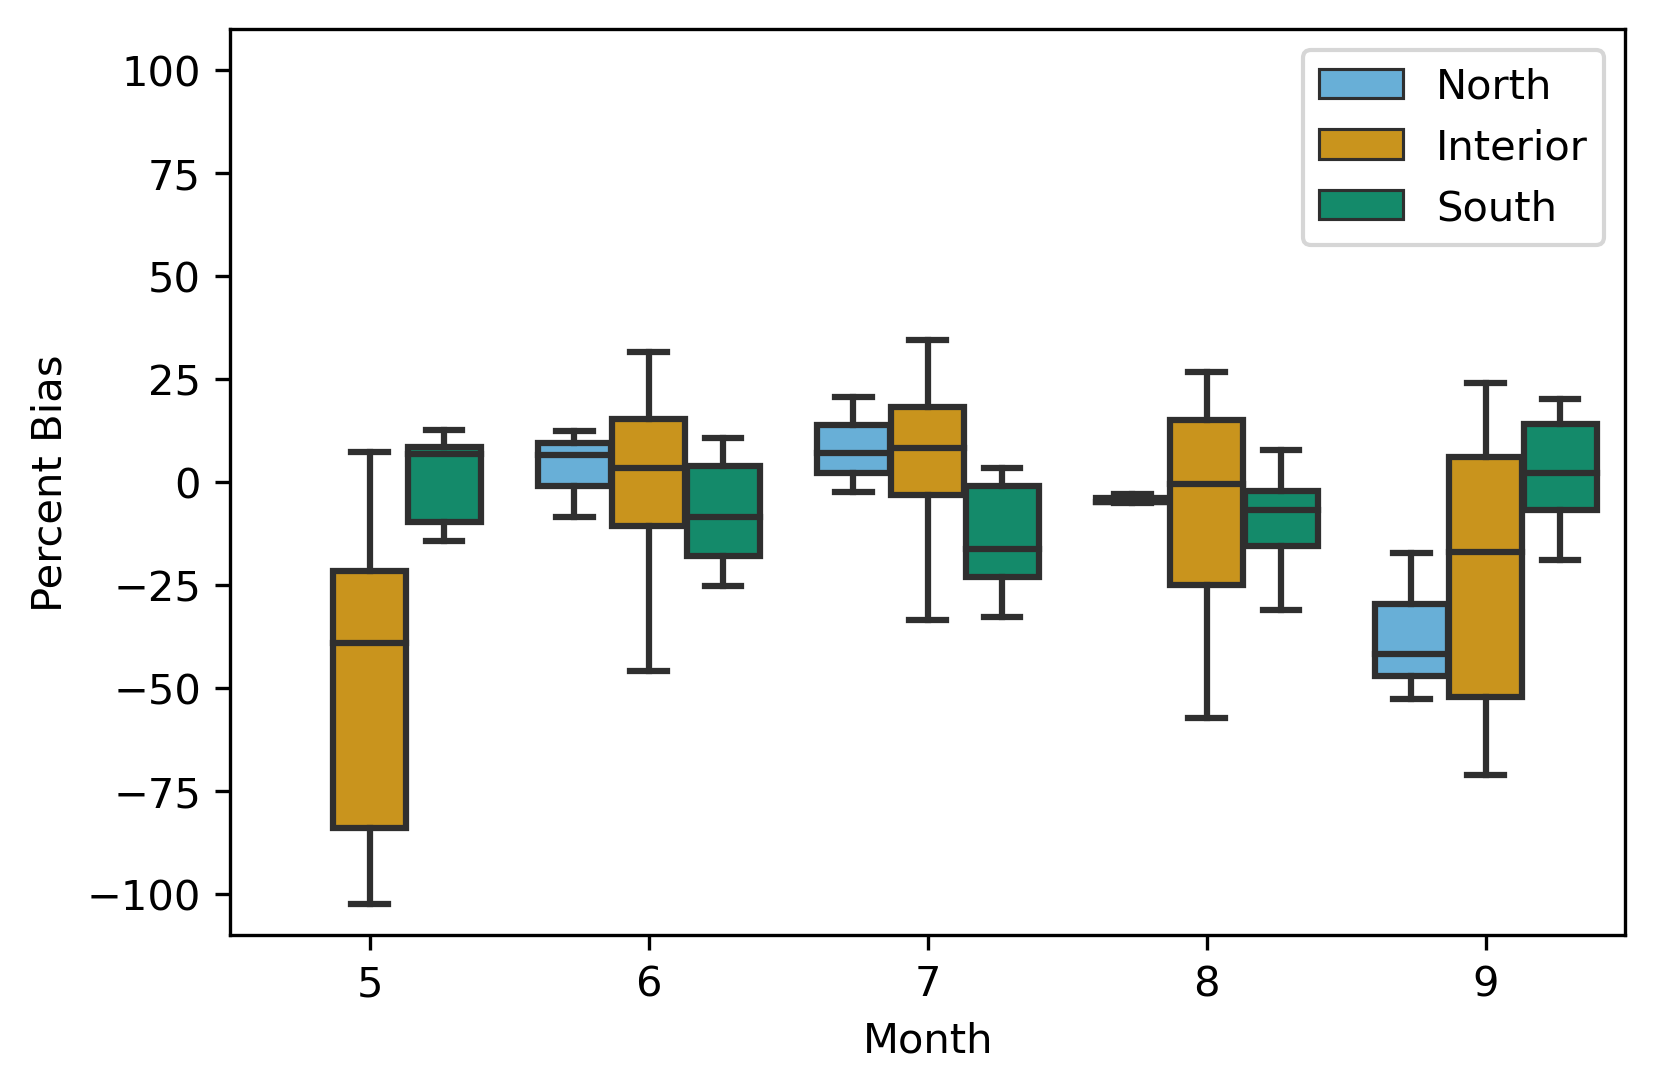

In [174]:
df_reduced = val_results_m_opt[['PBias', 'COMID', 'Month', 'Location']]
df_reduced = df_reduced[df_reduced['Month'] > 4].reset_index()
a = np.where((df_reduced['Month'] == 5) & (df_reduced['Location'] == 'North'))[0].tolist()
df_reduced = df_reduced.drop(df_reduced.index[[a]])

#legend_label = ["Default", "Optimized"]
my_pal = ['#56B4E9', '#E69F00', '#009E73']
plt.figure(dpi=300)
ax = sns.boxplot(x="Month", y="PBias", hue="Location", data=df_reduced, palette=my_pal)  # RUN PLOT   
ax.legend(title="")
ax.set_ylim([-110, 110])

plt.ylabel('Percent Bias')
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/rbm_pbias.png", dpi='figure')
plt.show()

In [95]:
#### Begin Code #####
df_sites = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv', index_col=0)

# Read in Observed Data
temp_data = pd.read_csv('/glade/scratch/dblaskey/RBM/temperature_gages.csv', index_col=0)
df = pd.merge(temp_data, df_sites, on="site_no")

start_date = '2017-01-01'
end_date = '2021-09-29'
years = range(2017,2022)
time_series = pd.date_range(start_date, end_date)

psets_df = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_runs.csv')
psets_df.rename(columns={ psets_df.columns[0]: "Name" }, inplace = True)

list_df = []
list_rmse = []
list_comid = []
list_outlet = []

folder = 'Optimized_loc'
for outlet in np.unique(df_sites.outlet_comid.values):
    print(folder, outlet)
    gages = df_sites.loc[df_sites['outlet_comid'] == outlet]
    comids = gages.COMID
    site_nos = gages.index.values

    # Specify path
    ds_rbm = xr.open_mfdataset('/glade/scratch/dblaskey/RBM/Output/Validation/%s/%s_*.nc'%(folder, outlet))
    reachID_list = np.rint(ds_rbm.hru.values).astype(int)

    for i,comid in enumerate(comids):
        # Filter to just one gage for simulations
        seg_sel = np.where(reachID_list == comid)[0][0]
        sim_flow = ds_rbm.T_stream.sel(hru=reachID_list[seg_sel], no_seg=2)
        sim_flow.load()
        sim_df = pd.DataFrame(sim_flow, index=time_series, columns=['sim'])
        sim_df.index.name = 'Date'

        # Filter to just one gage for observations
        temp_df = df[df['site_no']== site_nos[i]][['X_00010_00003', 'Date']]
        temp_df = temp_df.rename(columns={"X_00010_00003": "obs"})
        temp_df = temp_df.set_index('Date')
        temp_df.index = pd.to_datetime(temp_df.index)

        # Combine simulation and observation datasets
        df_concat = pd.concat([sim_df,temp_df],axis=1)
        df_concat = df_concat.dropna()
        df_concat = df_concat.loc['2017-10-01':'2021-09-29']
        df_concat = df_concat[df_concat.index.month.isin([5,6,7,8,9])]
        df_concat = df_concat.reset_index()

        # return the results
        list_rmse.append(he.evaluator(he.rmse, df_concat.sim.values, df_concat.obs.values)[0])
        list_comid.append(np.int(comid))
        list_outlet.append(outlet)
        list_df.append(df_concat)
        
temperature_validation = pd.concat(list_df)

Optimized_loc 81000005
Optimized_loc 81000402
Optimized_loc 81000433
Optimized_loc 81014324
Optimized_loc 81020021
Optimized_loc 81027459
Optimized_loc 81027546
Optimized_loc 81030789
Optimized_loc 81030912
Optimized_loc 81035777
Optimized_loc 81035794


In [96]:
import calendar

temperature_validation['Month'] = pd.to_datetime(temperature_validation.Date).dt.month
temperature_validation['Month'] = temperature_validation['Month'].apply(lambda x: calendar.month_abbr[x])

In [97]:
temperature_validation

Date   sim  obs Month
0   2018-06-08  4.76  1.9   Jun
1   2018-06-09  3.91  2.1   Jun
2   2018-06-10  3.31  1.7   Jun
3   2018-06-11  3.69  1.8   Jun
4   2018-06-12  5.02  2.2   Jun
..         ...   ...  ...   ...
605 2021-09-25  4.48  4.1   Sep
606 2021-09-26  4.43  3.8   Sep
607 2021-09-27  4.10  3.6   Sep
608 2021-09-28  4.19  3.6   Sep
609 2021-09-29  4.00  3.3   Sep

[9886 rows x 4 columns]

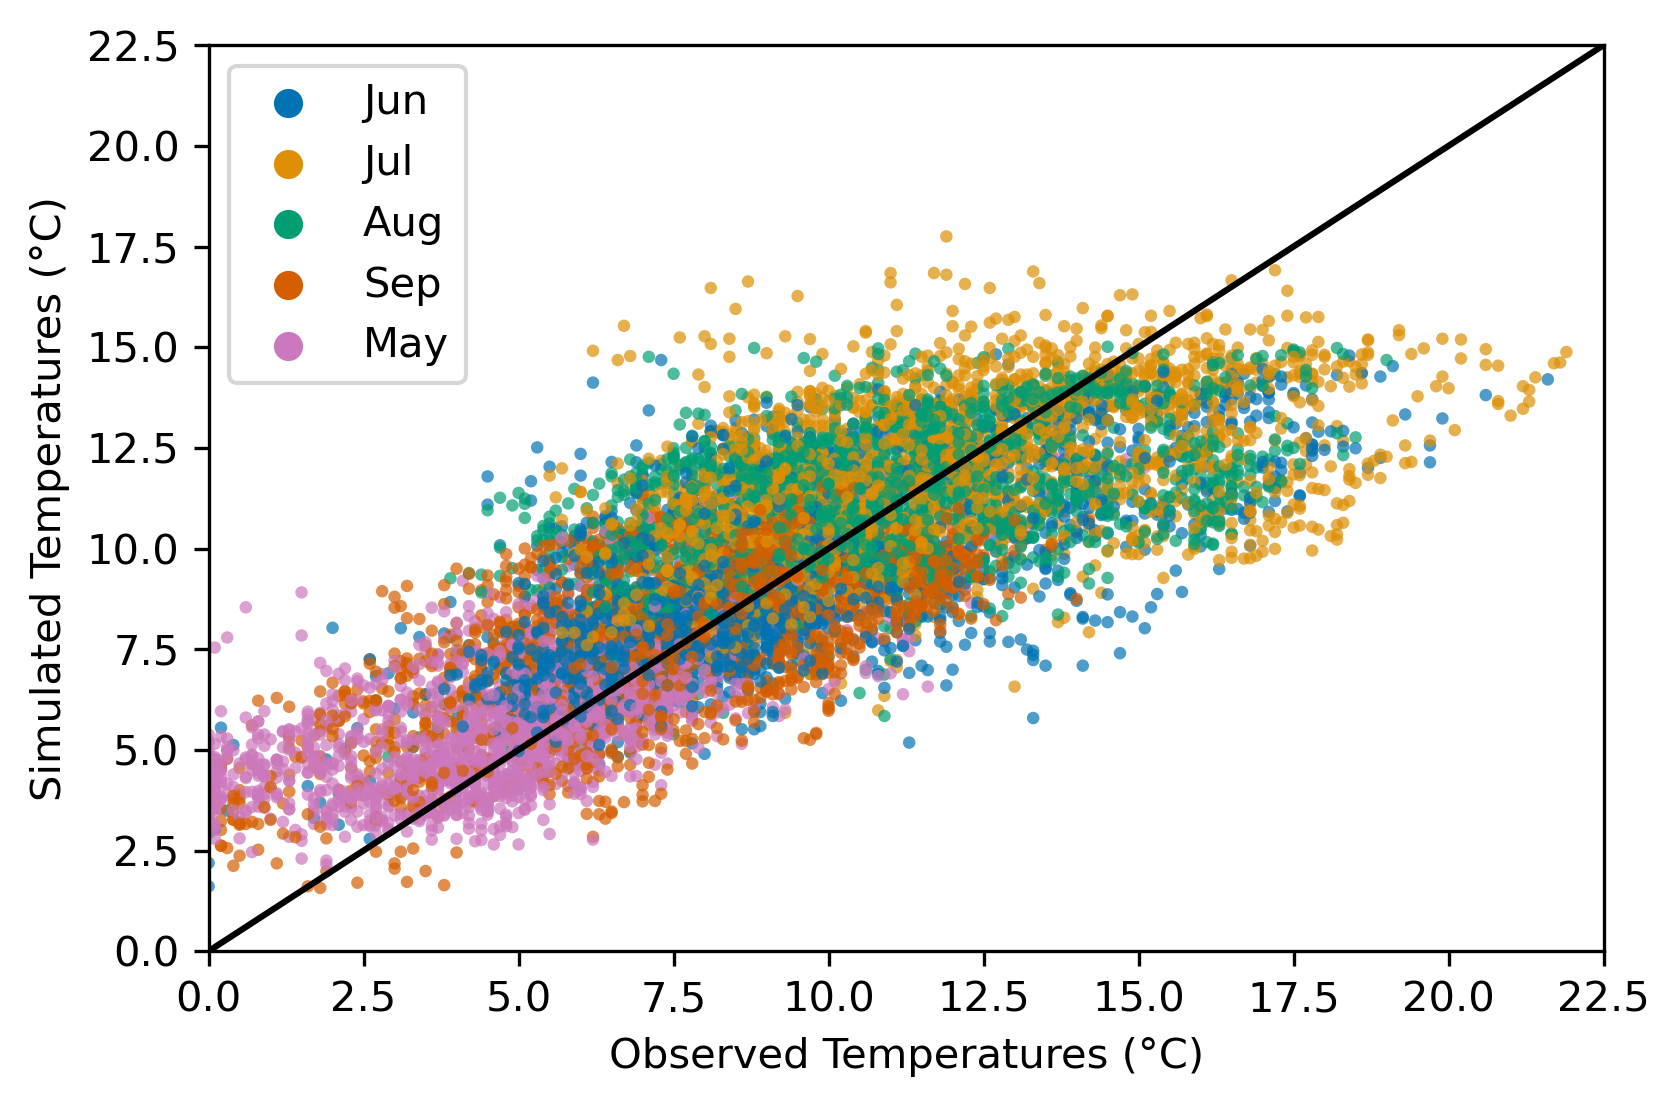

In [177]:
plt.figure(dpi=300)
plt.xlim([0, 22.5])
plt.ylim([0, 22.5])
sns.scatterplot(data=temperature_validation, x="obs", y="sim", hue=temperature_validation["Month"].to_list(), palette='colorblind',s=9, linewidth=0, alpha = 0.7)
#plt.scatter(temperature_validation.obs, temperature_validation.sim, s=1, c='black')
plt.axline((0, 0), slope=1, c="black")
plt.xlabel('Observed Temperatures (°C)')
plt.ylabel('Simulated Temperatures (°C)')
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Optimized_val_scatter.png", dpi='figure')

(0.0, 22.5)

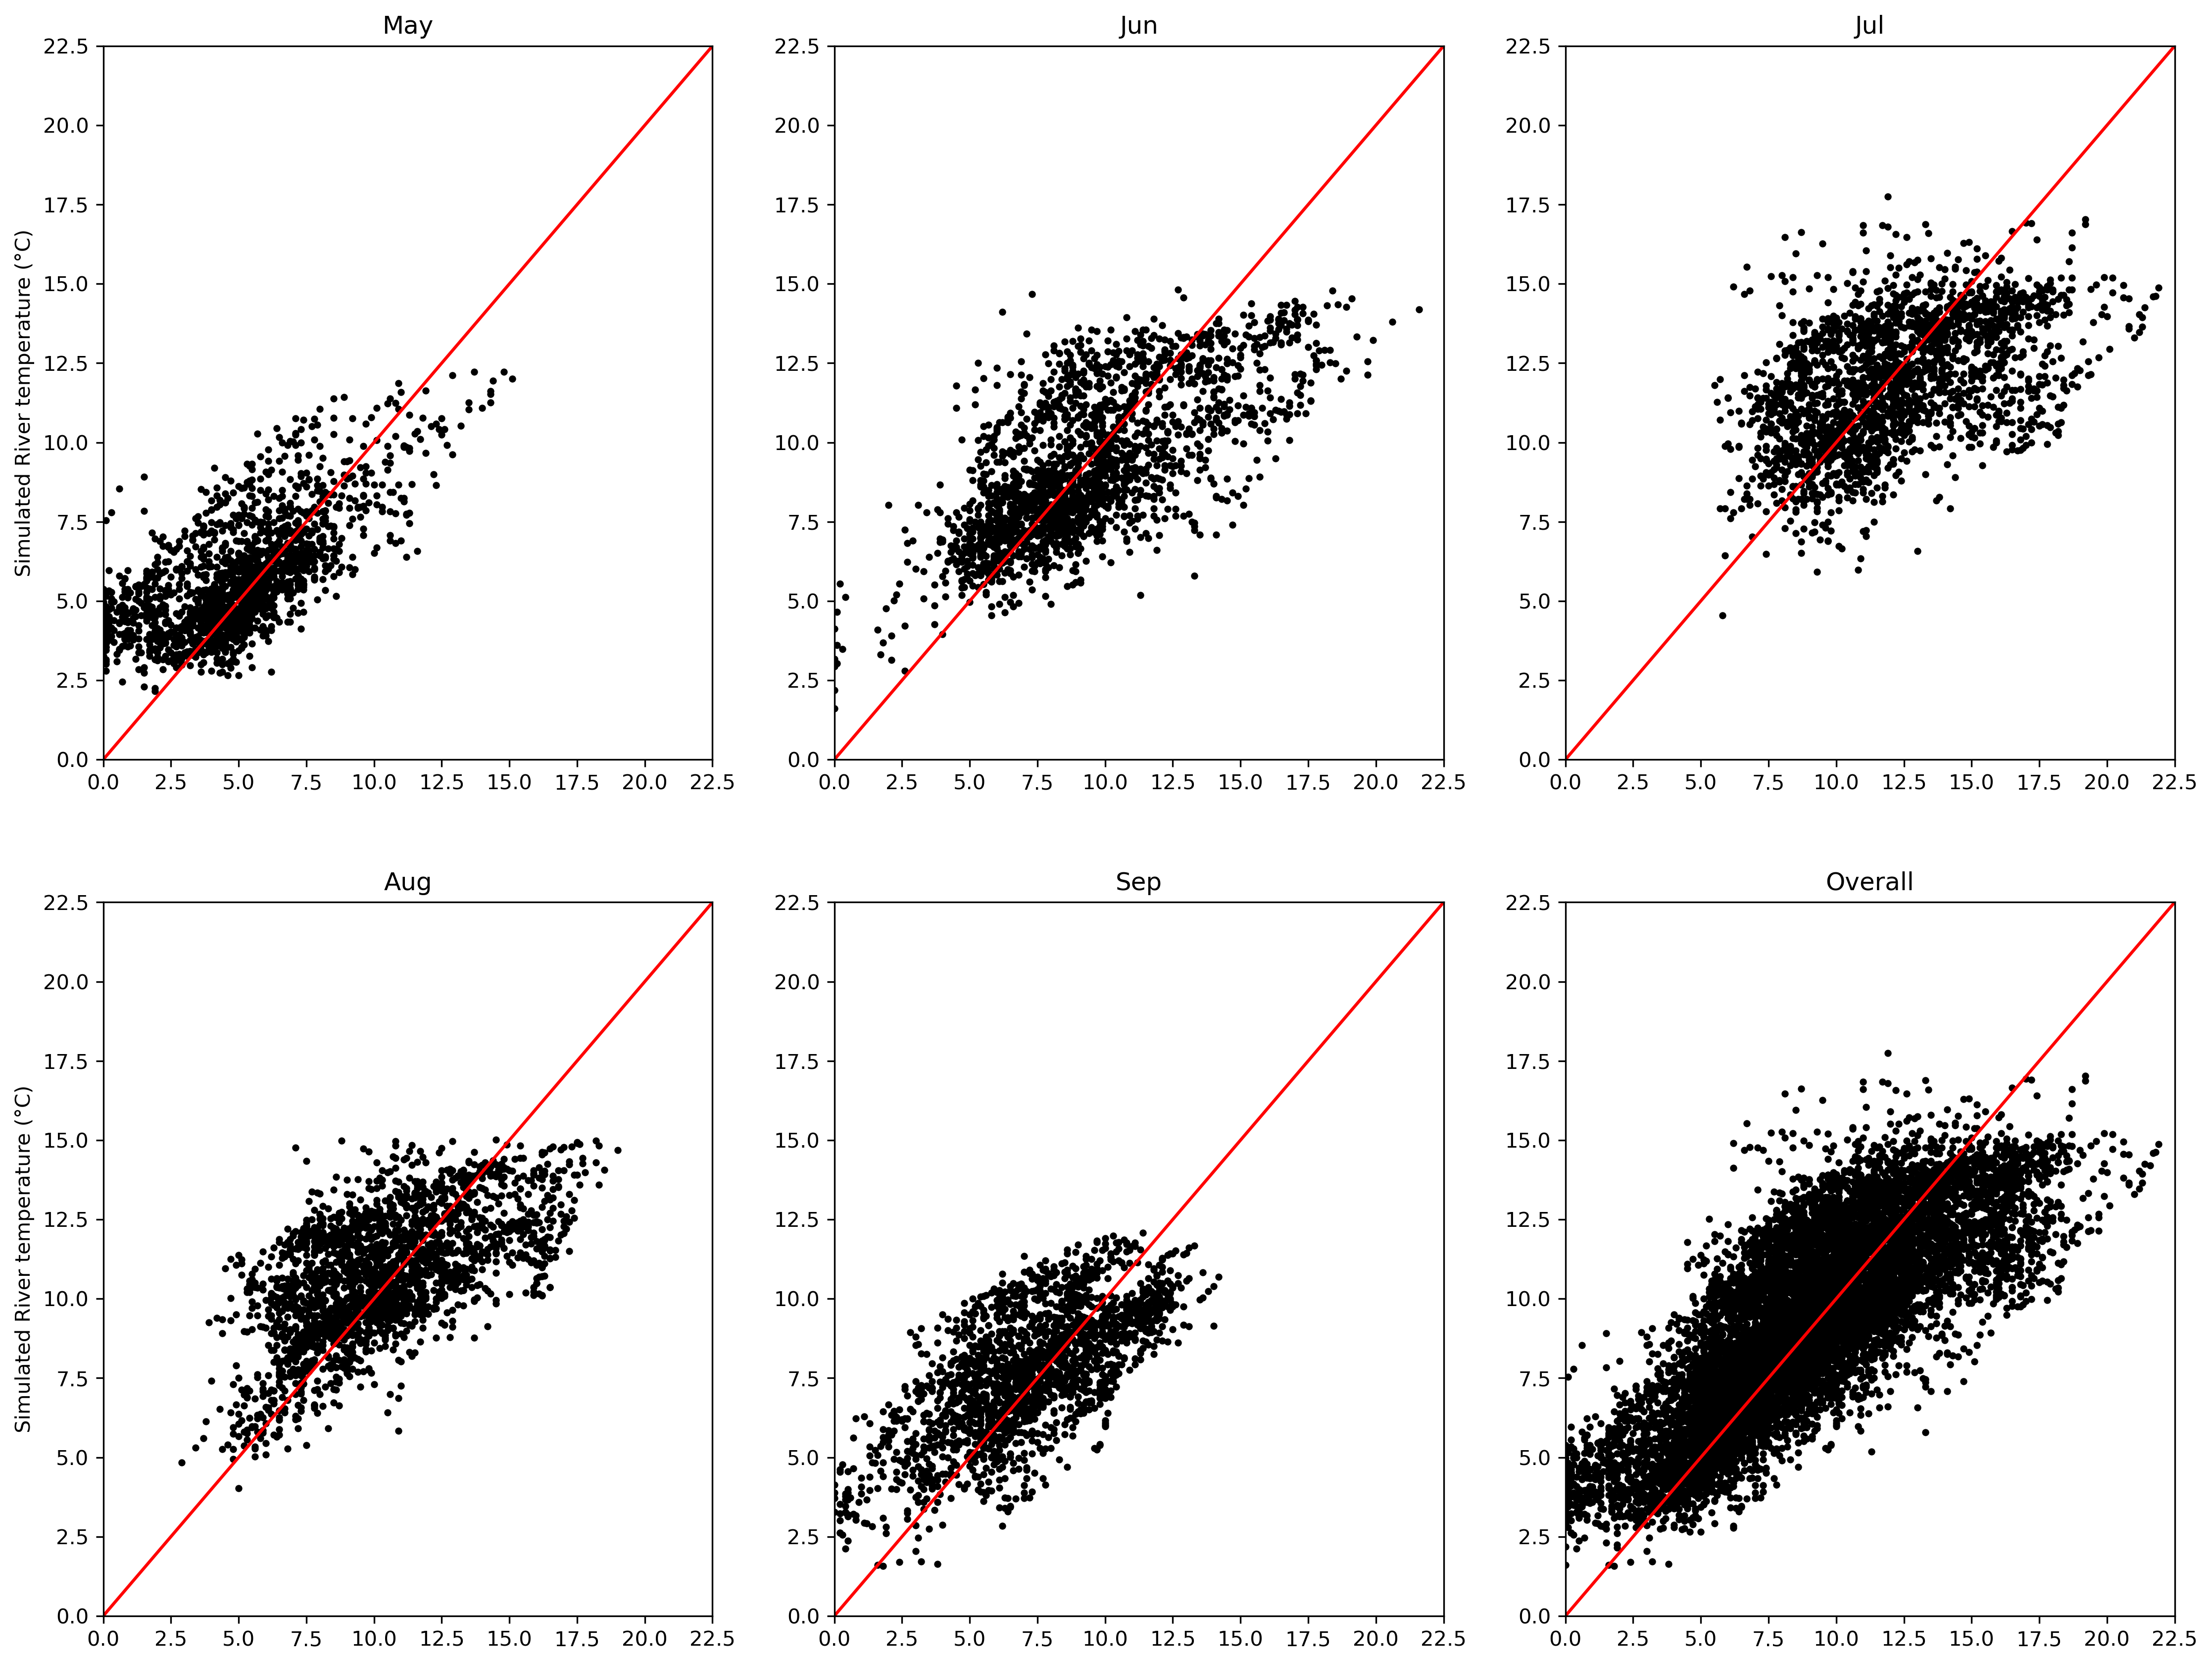

In [17]:
fig,ax = plt.subplots(2, 3,figsize=[18,14],dpi=300)

for i, month in enumerate(['May', 'Jun', 'Jul', 'Aug', 'Sep']):
    col = i %3
    row = int(np.floor(i/3))
    
    plot_df_temp = temperature_validation[temperature_validation['Month'] == month]
    ax[row,col].scatter(plot_df_temp.obs.values, plot_df_temp.sim.values, s = 6, c='black')
    ax[row,col].axline((0, 0), slope=1, c="red")
    
    ax[row,col].set_title("%s"%month) 
    
    if col == 0:
        ax[row,col].set_ylabel('Simulated River temperature (°C)')
    if row == 2:
        ax[row,col].set_xlabel('Observed River temperature (°C)')
    ax[row,col].set_ylim(0,22.5)
    ax[row,col].set_xlim(0,22.5)
ax[1,2].scatter(temperature_validation.obs.values, temperature_validation.sim.values, s = 6, c='black')
ax[1,2].set_title("Overall") 
ax[1,2].axline((0,0), slope=1, c="red")
ax[1,2].set_ylim(0,22.5)
ax[1,2].set_xlim(0,22.5)

#plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Optimized_val_scatter.png", dpi='figure')

May 1.90381758816648 0.7628803367408299
Jun 2.402688030423884 -0.10391041771514845
Jul 2.780224243841104 -0.16006158218853617
Aug 2.3813859611361985 0.4307308048103607
Sep 2.0234596309144193 0.4915690269994906
overall 2.3659239262032696 0.2650718187335627


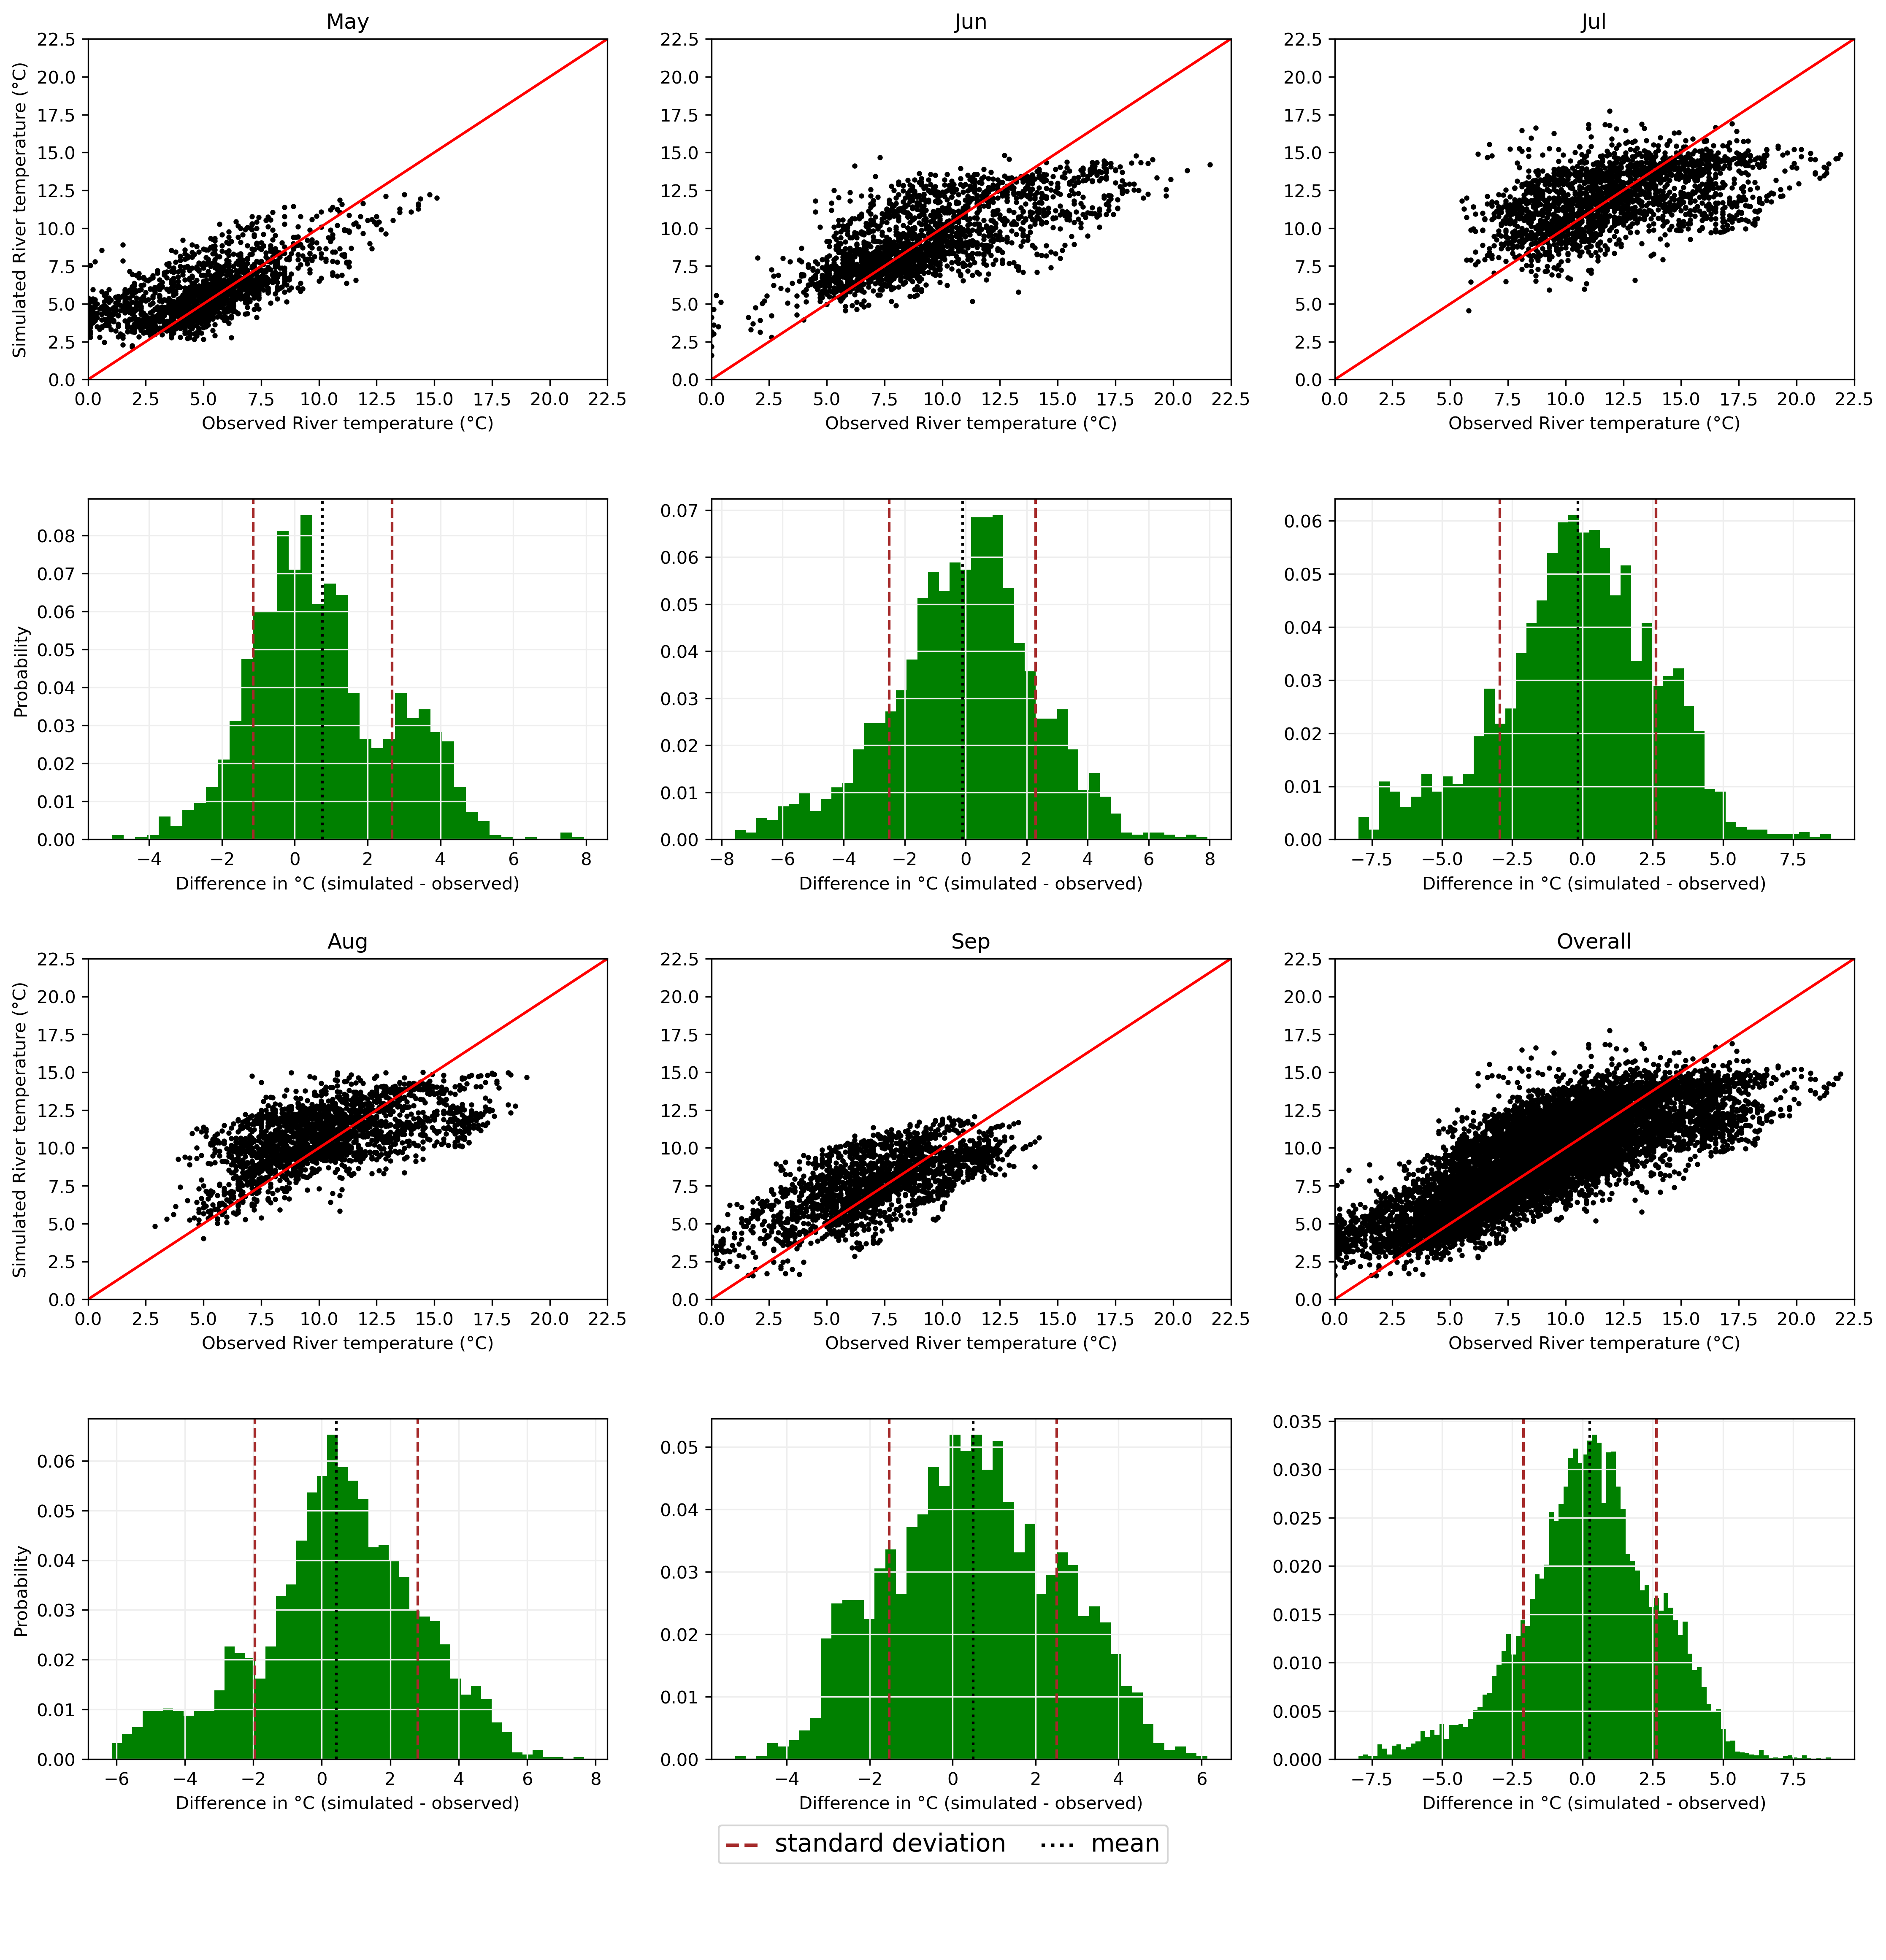

In [187]:
diff = temperature_validation.sim - temperature_validation.obs

fig,ax = plt.subplots(4, 3,figsize=[18,18],dpi=300)

for i, month in enumerate(['May', 'Jun', 'Jul', 'Aug', 'Sep']):
    col = i %3
    if i < 3:
        row = int(np.floor(i/3))
    else:
        row = int(np.floor(i/3)) + 1
    
    # Plot Scatter
    plot_df_temp = temperature_validation[temperature_validation['Month'] == month]
    ax[row,col].scatter(plot_df_temp.obs.values, plot_df_temp.sim.values, s = 4, c='black')
    ax[row,col].axline((0, 0), slope=1, c="red")
    ax[row,col].set_title("%s"%month)
    ax[row,col].set_ylim(0,22.5)
    ax[row,col].set_xlim(0,22.5)
    ax[row,col].set_xlabel('Observed River temperature (°C)')
    if col == 0:
        ax[row,col].set_ylabel('Simulated River temperature (°C)')
    
    # Plot Histogram
    diff = plot_df_temp.sim - plot_df_temp.obs
    weights = np.ones_like(diff) / (len(diff))
    std = np.std(diff)
    mean_diff = diff.mean()
    print(month, std, mean_diff)
    row2 = row+1
    ax[row2,col].hist(diff, bins=int(np.sqrt(len(diff))), weights=weights, facecolor='g')
    ax[row2,col].axvline(x=mean_diff+std, c="brown", linestyle='--', label='standard deviation')
    ax[row2,col].axvline(x=mean_diff, c="black", linestyle=':', label='mean')
    ax[row2,col].axvline(x=mean_diff-std, c="brown", linestyle='--')
    ax[row2,col].set_xlabel('Difference in °C (simulated - observed)')
    ax[row2,col].grid(True, color='#EEEEEE')
    if col == 0:
        ax[row2,col].set_ylabel('Probability')
    
# Create overall plots
ax[2,2].scatter(temperature_validation.obs.values, temperature_validation.sim.values, s = 4, c='black')
ax[2,2].set_title("Overall") 
ax[2,2].axline((0,0), slope=1, c="red")
ax[2,2].set_ylim(0,22.5)
ax[2,2].set_xlim(0,22.5)
ax[2,2].set_xlabel('Observed River temperature (°C)')

diff = temperature_validation.sim - temperature_validation.obs
weights = np.ones_like(diff) / (len(diff))
std = np.std(diff)
mean_diff = diff.mean()
print("overall", std, mean_diff)
ax[3,2].hist(diff, bins=int(np.sqrt(len(diff))), weights=weights, facecolor='g')
ax[3,2].axvline(x=mean_diff+std, c="brown", linestyle='--', label='std')
ax[3,2].axvline(x=mean_diff, c="black", linestyle=':', label='mean')
ax[3,2].axvline(x=mean_diff-std, c="brown", linestyle='--')
ax[3,2].set_xlabel('Difference in °C (simulated - observed)')
ax[3,2].grid(True, color='#EEEEEE')

fig.subplots_adjust(hspace=0.35)

# Move the legend below the figure
handles, labels = ax[1, 0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower center', ncol=4, borderaxespad=5.5)

# Increase the font size of the legend
font_size = 14
for text in legend.get_texts():
    text.set_fontsize(font_size)
for line in legend.get_lines():
    line.set_linewidth(2)
#plt.tight_layout()    
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Optimized_val_scatter_hist.png", dpi='figure')
plt.show()

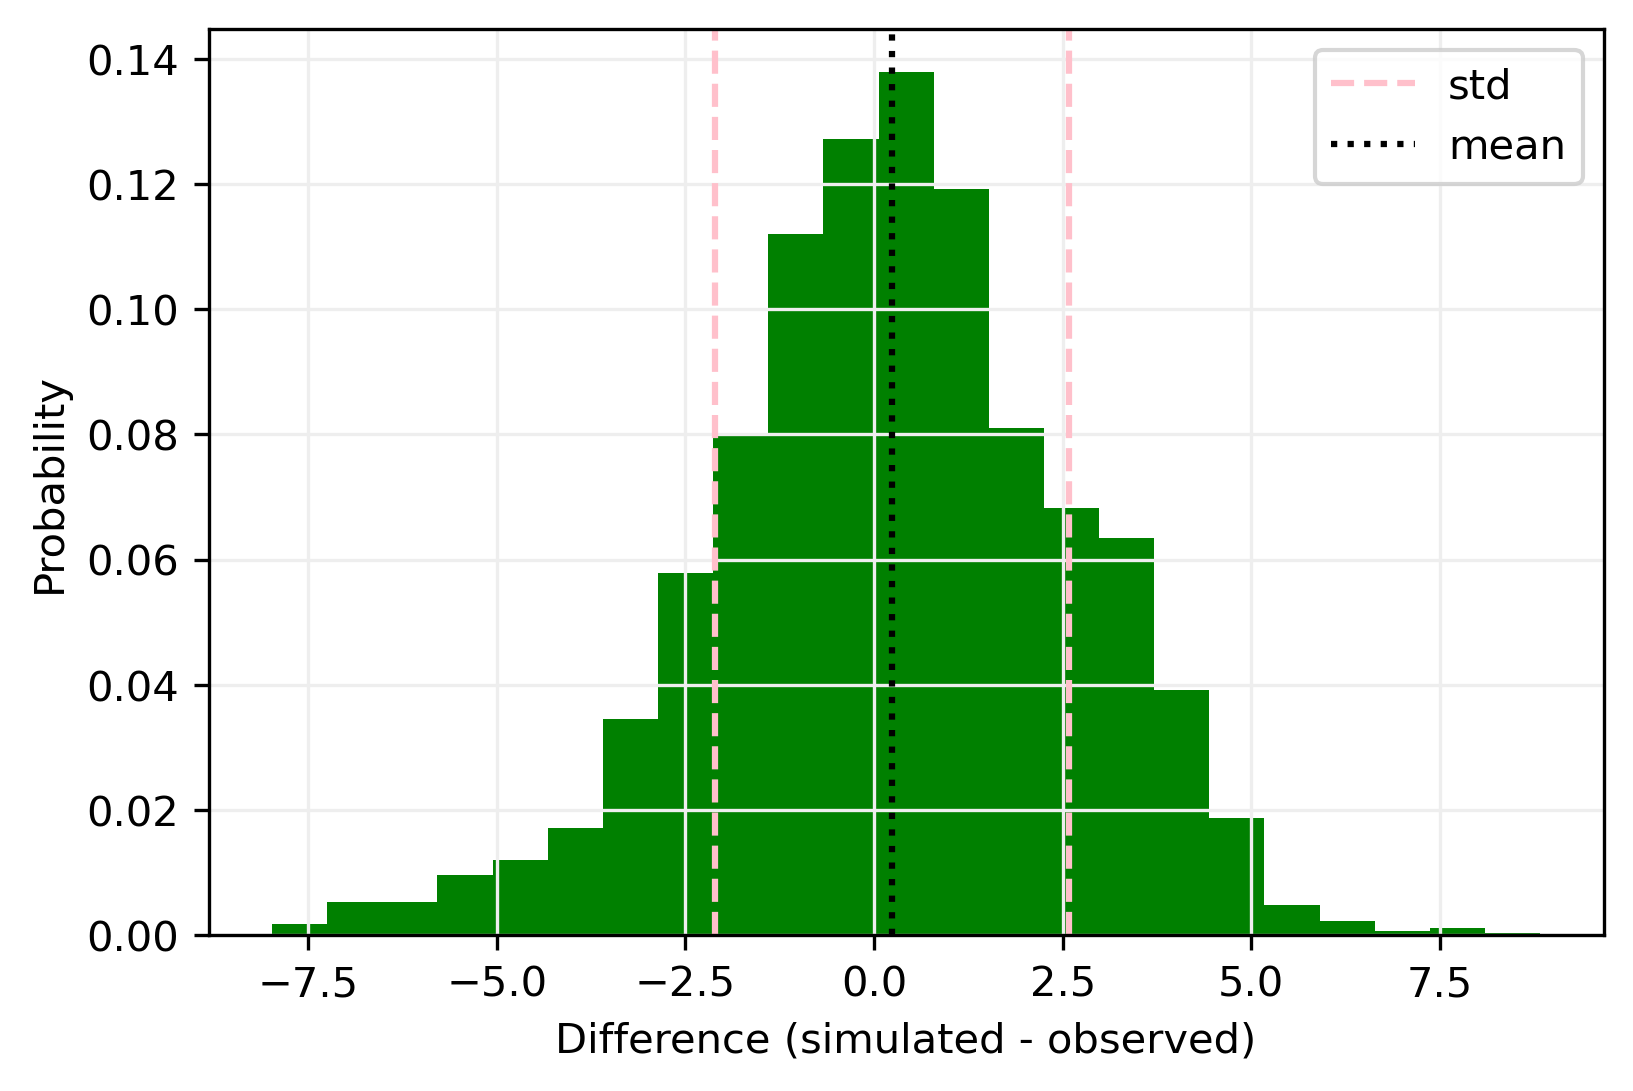

In [10]:
diff = temperature_validation.sim - temperature_validation.obs
weights = np.ones_like(diff) / (len(diff))
std = np.std(diff)
mean_diff = diff.mean()
temperature_validation['diff'] = diff
plt.figure(dpi=300)
#sns.histplot(diff)
plt.hist(diff, bins=23, weights=weights, facecolor='g')
plt.axvline(x=mean_diff+std, c="pink", linestyle='--', label='std')
plt.axvline(x=mean_diff, c="black", linestyle=':', label='mean')
plt.axvline(x=mean_diff-std, c="pink", linestyle='--')
plt.xlabel('Difference (simulated - observed)')
plt.ylabel('Probability')
plt.grid(True, color='#EEEEEE')
plt.legend()
plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Baseline_val_hist.png", dpi='figure')
plt.show()

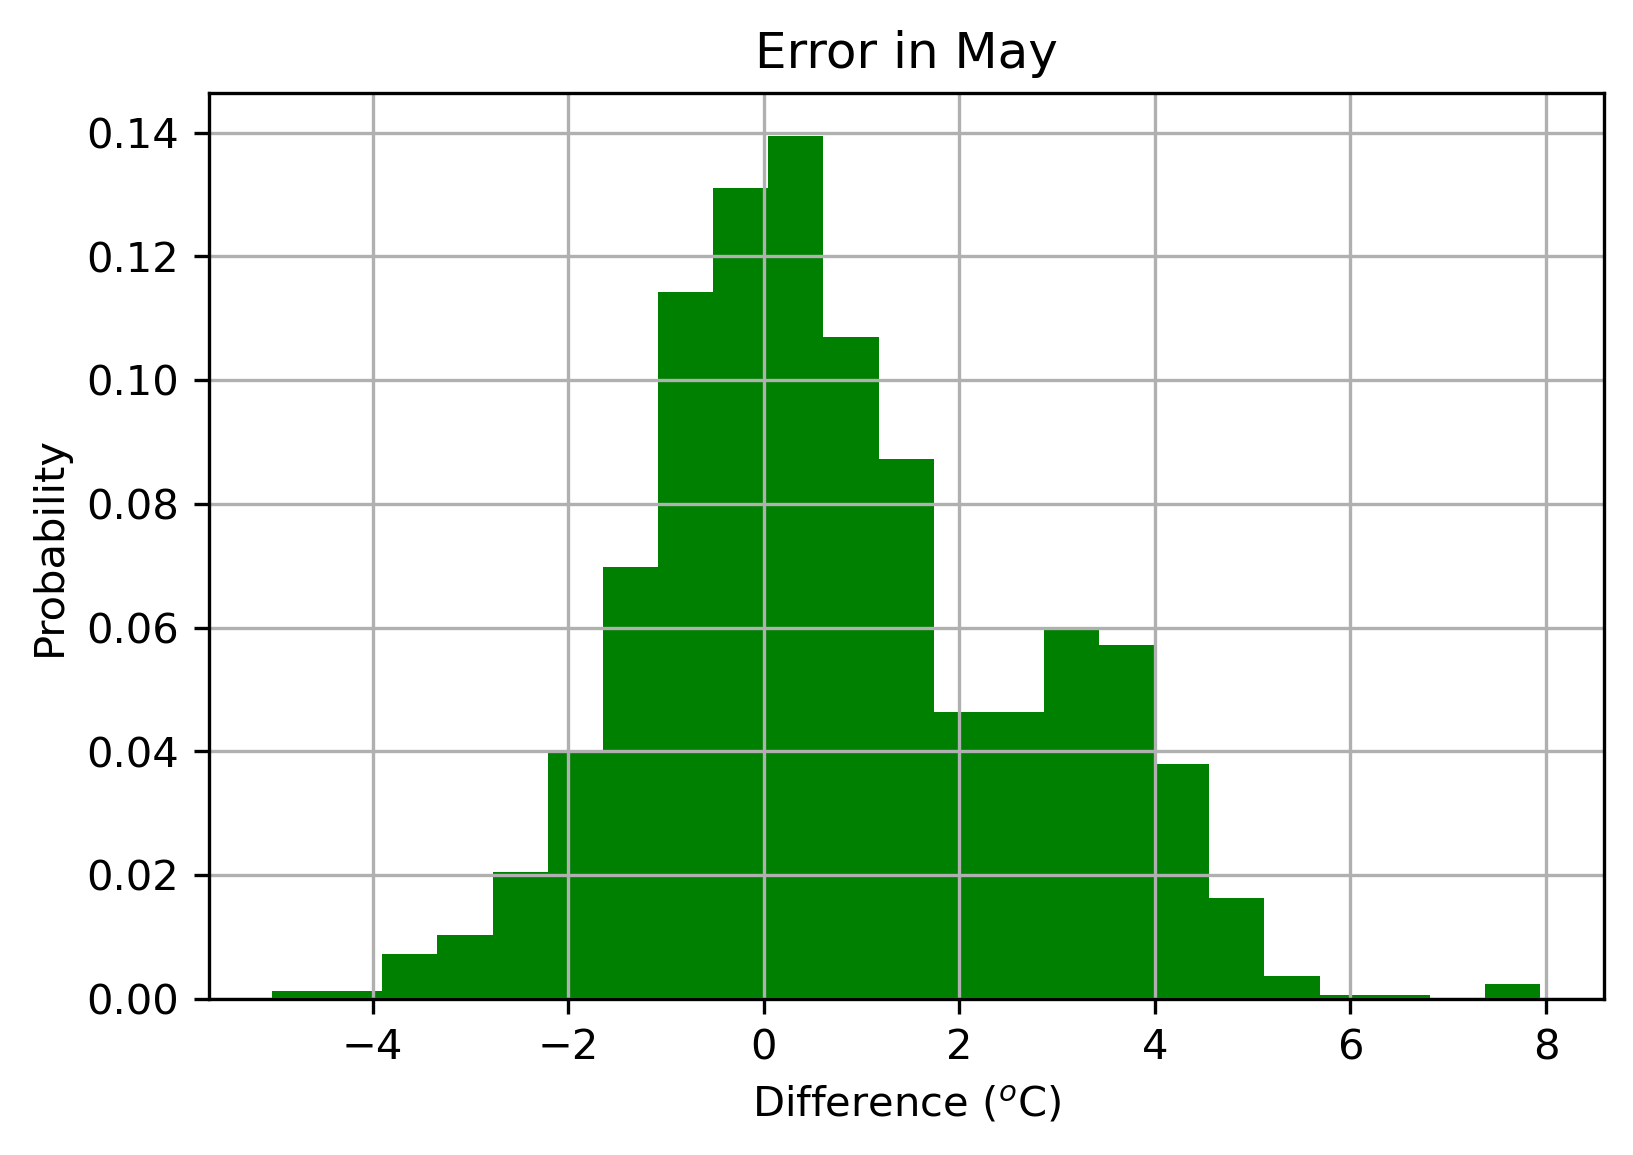

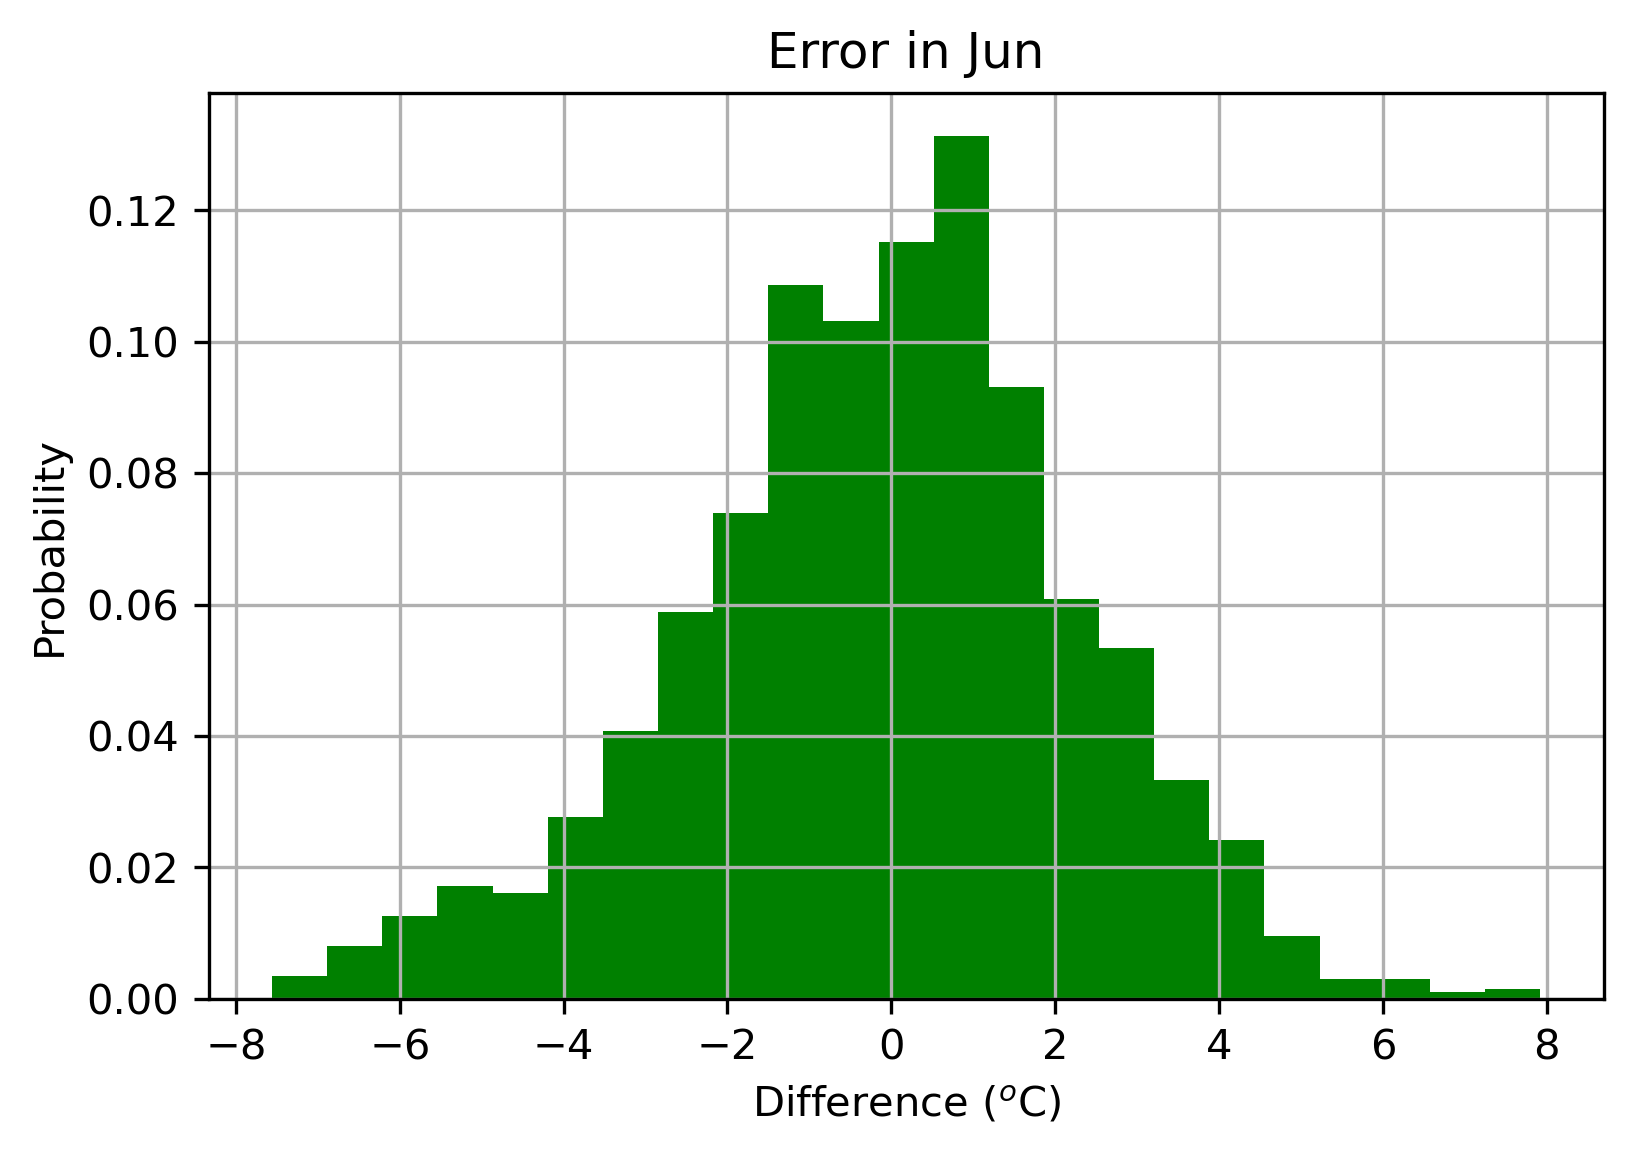

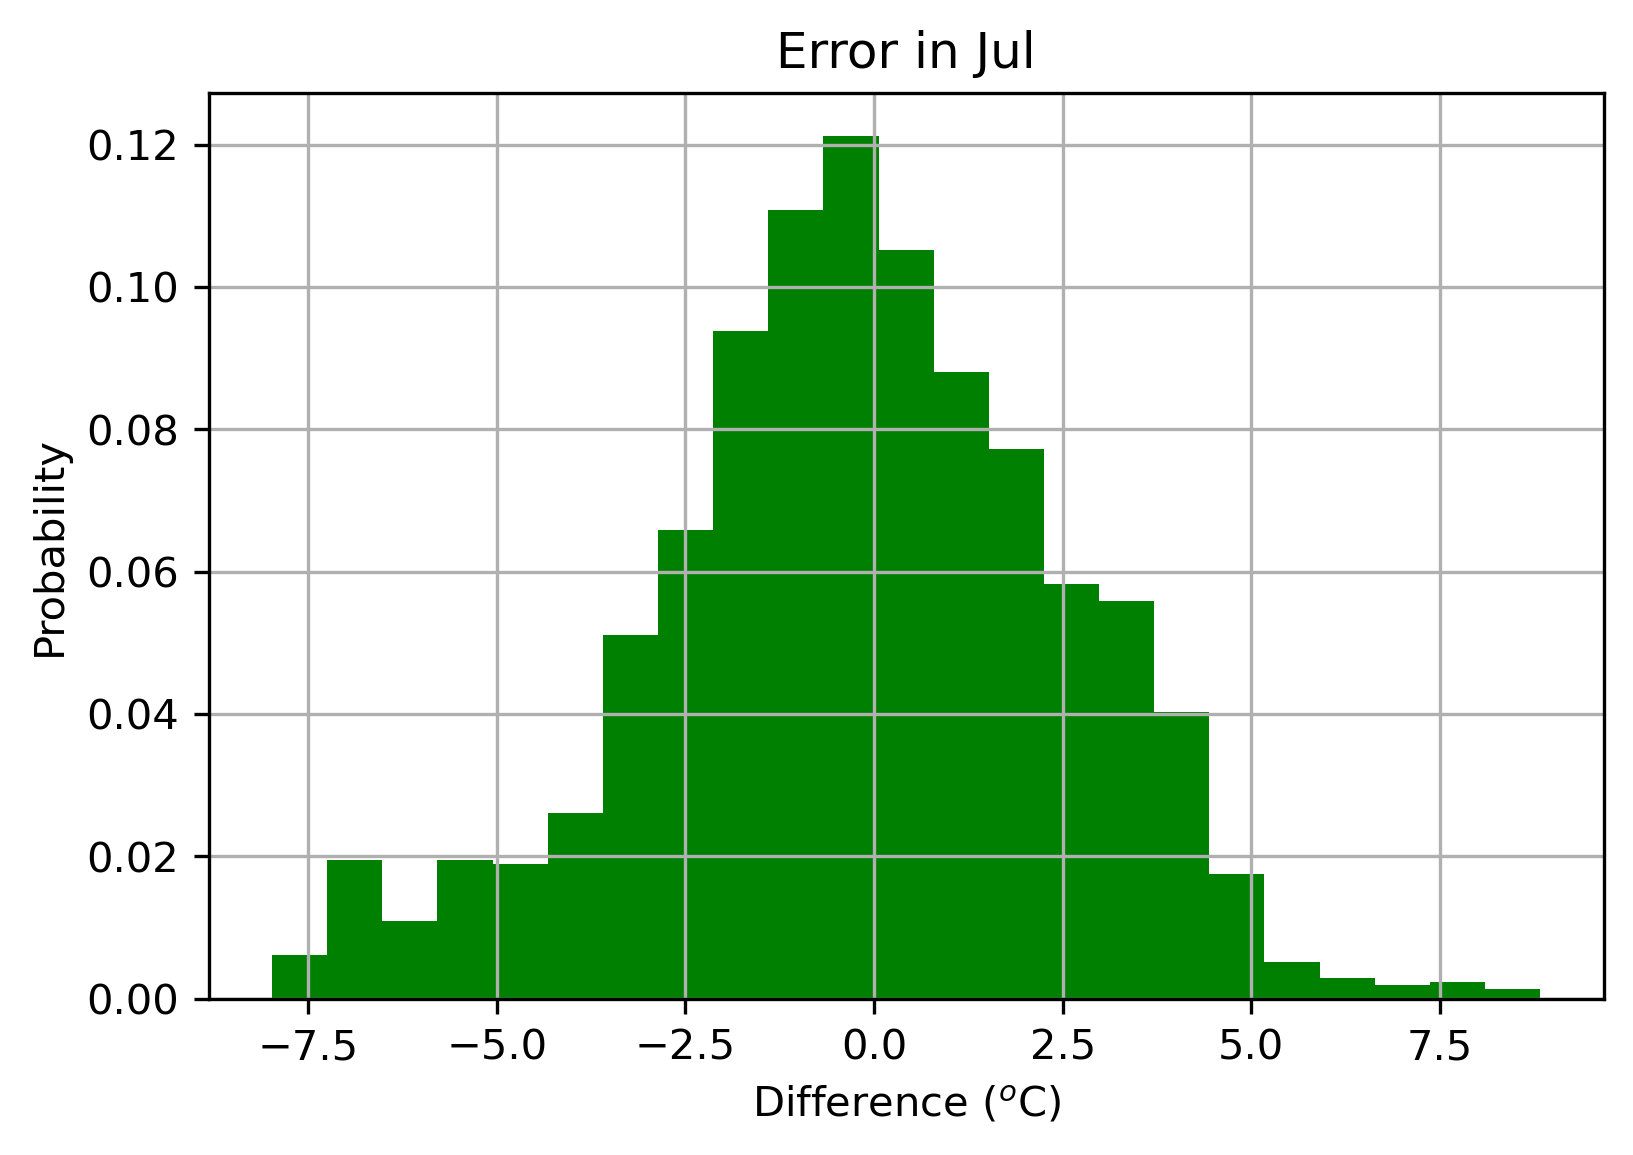

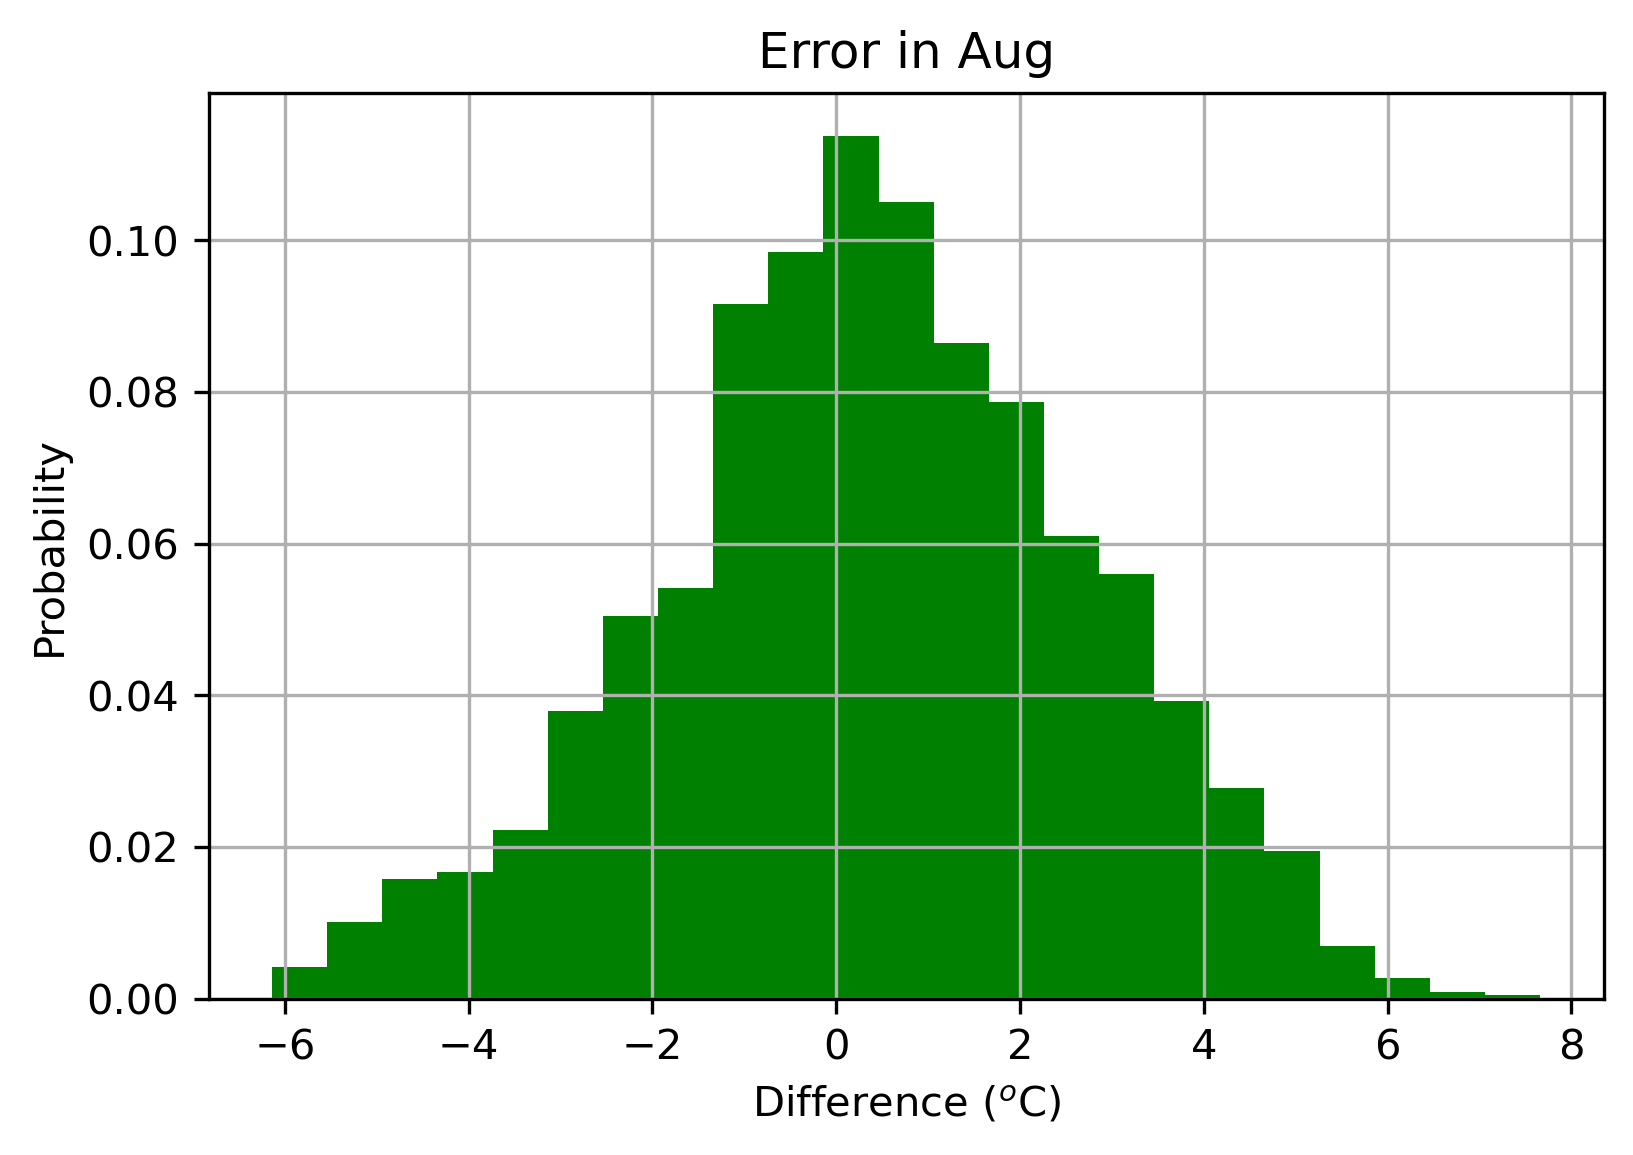

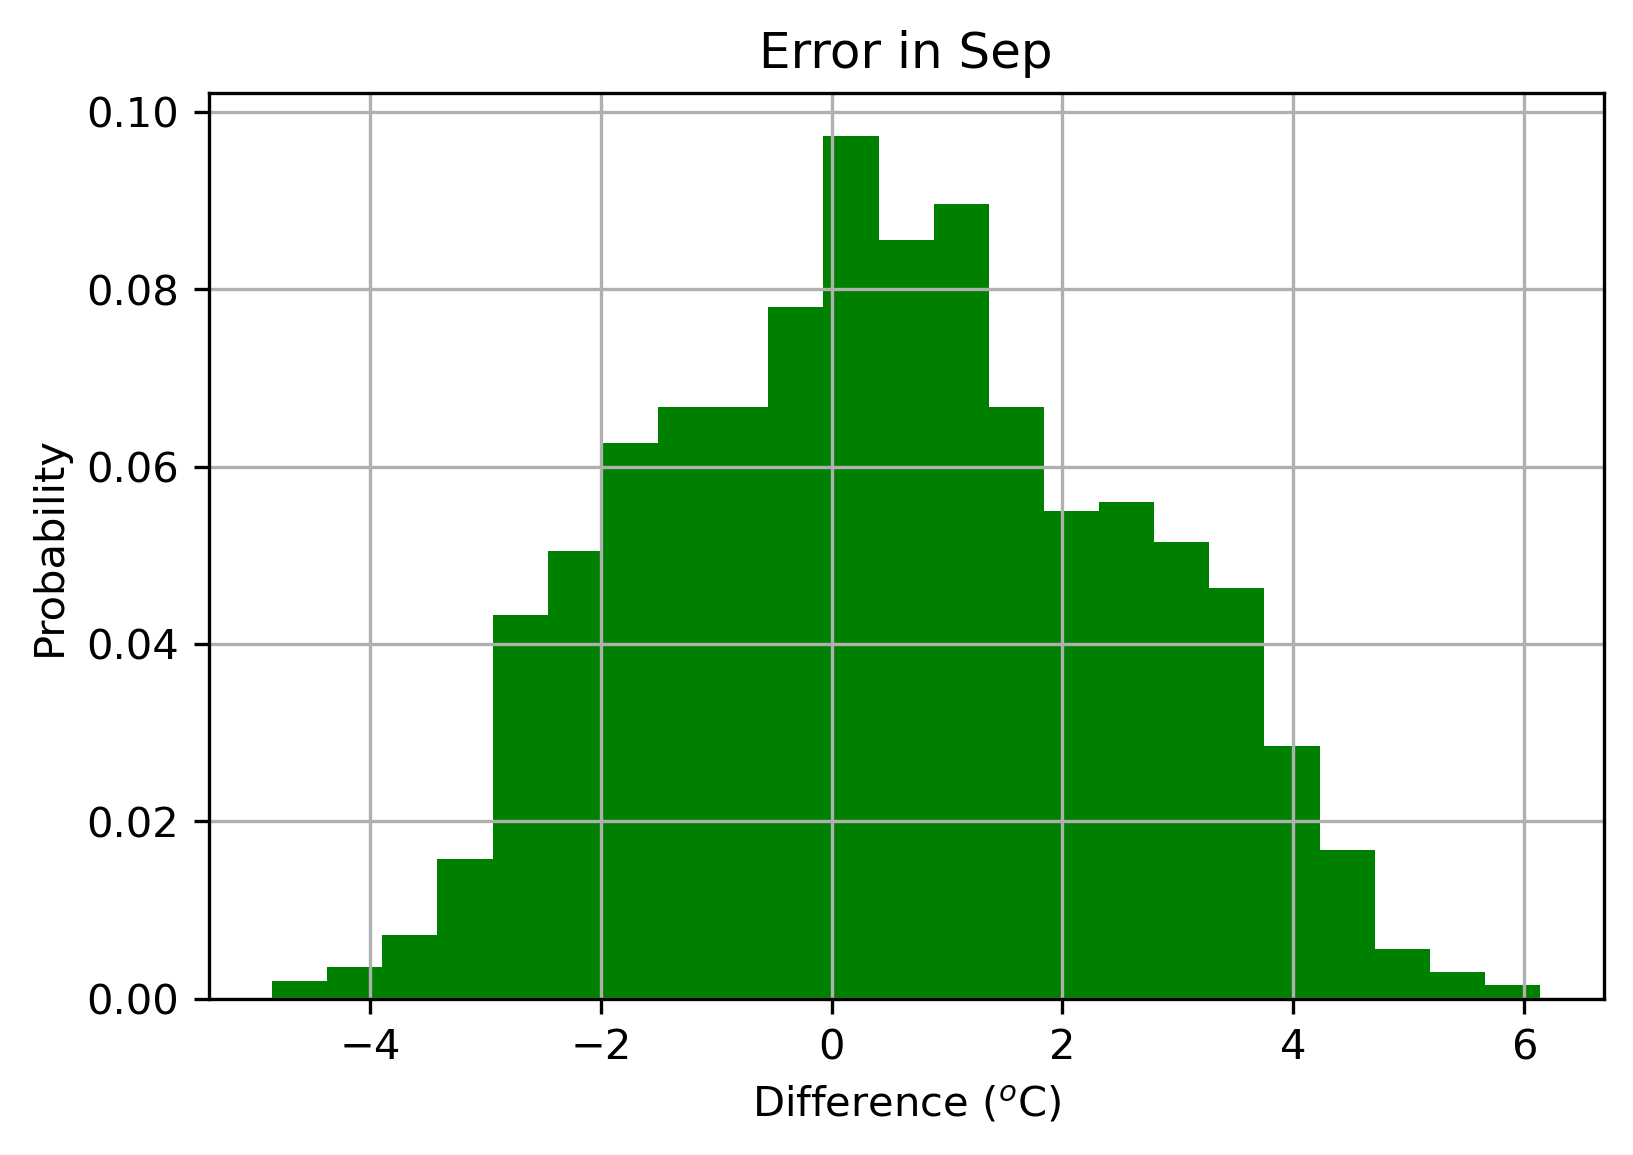

In [78]:
import calendar

for m in [5,6,7,8,9]:
    temperature_validation_m = temperature_validation[temperature_validation["Month"] == m]
    diff = temperature_validation_m.sim - temperature_validation_m.obs
    weights = np.ones_like(diff) / (len(diff))
    plt.figure(dpi=300)
    plt.hist(diff, bins=23, weights=weights, facecolor='g')
    plt.xlabel('Difference ($^o$C)')
    plt.ylabel('Probability')
    m_name = calendar.month_abbr[m] 
    plt.title('Error in %s'%m_name)
    plt.grid(True)
    plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Baseline_val_hist_%s.png"%m, dpi='figure')
    plt.show()

In [ ]:
# Plot Temperature Results

In [99]:
basins_df = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv')

basins = basins_df['outlet_comid'].values

temp_data = pd.read_csv('/glade/scratch/dblaskey/RBM/temperature_gages.csv', index_col=0)
df = pd.merge(temp_data, basins_df, on="site_no")

In [100]:
df_list = []

start_date = '2017-01-01'
end_date = '2021-09-29'
years = range(2013,2018)
time_series = pd.date_range(start_date, end_date)

for w,run in enumerate(['Baseline_loc', 'Optimized_loc']):
    for j,basin in enumerate(basins): 
        gages = basins_df.loc[basins_df['outlet_comid'] == basin]
        comids = gages.COMID.values
        site_nos = gages.site_no.values

        # Specify path
        ds_rbm = xr.open_mfdataset('/glade/scratch/dblaskey/RBM/Output/Validation/%s/%s_*.nc'%(run, basin))
        reachID_list = np.rint(ds_rbm.hru.values).astype(int)

        for i,comid in enumerate(comids):
            # Filter to just one gage for simulations
            seg_sel = np.where(reachID_list == comid)[0][0]
            sim_flow = ds_rbm.T_stream.sel(hru=reachID_list[seg_sel], no_seg=2)
            sim_flow.load()
            sim_df = pd.DataFrame(sim_flow, index=time_series, columns=['sim'])
            sim_df.index.name = 'Date'

            # Filter to just one gage for observations
            temp_df = df[df['site_no']==site_nos[i]][['X_00010_00003', 'Date']]
            temp_df = temp_df.rename(columns={"X_00010_00003": "obs"})
            temp_df = temp_df.set_index('Date')
            temp_df.index = pd.to_datetime(temp_df.index)

            # Combine simulation and observation datasets
            df_concat = pd.concat([sim_df,temp_df],axis=1)
            df_concat = df_concat.dropna()
            df_concat = df_concat.loc['2017-10-01':'2021-09-30']
            df_concat = df_concat[df_concat.index.month.isin([5,6,7,8,9])]
            df_concat['COMID'] = int(comid)
            df_concat['type'] = run
            df_concat = df_concat.reset_index()
            
            df_list.append(df_concat)

plot_df = pd.concat(df_list)

KeyboardInterrupt: 

In [64]:
plot_df = plot_df.reset_index()

In [128]:
plot_df.to_csv('/glade/u/home/dblaskey/RBM/Validation/error.csv')

In [101]:
plot_df=pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/error.csv')
plot_df['Date']=pd.DatetimeIndex(plot_df['Date'])
plot_df = plot_df.set_index('Date')

In [108]:
list_df = []
for comid in np.unique(plot_df.COMID.values):
    temp_df = plot_df[plot_df['COMID'] == comid]
    temp_df_opt = temp_df[temp_df['type'] == "Optimized_loc"].reset_index()
    temp_df_base = temp_df[temp_df['type'] == "Baseline_loc"]
    
    RA = pd.read_csv('/glade/scratch/dblaskey/RBM/Regression/Val/%s.csv'%comid)
    RA = RA.set_index('Date')
    RA.index = pd.to_datetime(RA.index)
    RA = RA.loc['2017-10-01':'2021-09-30']
    RA = RA[RA.index.month.isin([5,6,7,8,9])]
    RA = RA.rename(columns={"sim": "mosh"})
    RA = RA.reset_index()
    temp_df_opt=temp_df_opt.merge(RA)
    
    list_df.append([he.evaluator(he.rmse, temp_df_opt.sim.values, temp_df_opt.obs.values)[0],
                    he.evaluator(he.rmse, temp_df_opt.mosh.values, temp_df_opt.obs.values)[0],
                    he.evaluator(he.rmse, temp_df_base.sim.values, temp_df_base.obs.values)[0],
                    comid])

In [121]:
final_rmses=pd.DataFrame(list_df, columns = ['Opt', 'Stat', 'Base', 'COMID'])
len(final_rmses[final_rmses.Opt < final_rmses.Stat])

14

In [126]:
basins = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv')

final_rmses = final_rmses.merge(basins)
final_rmses[final_rmses.Base < final_rmses.Opt]

Opt      Stat      Base     COMID   site_no  \
3   2.835476  2.388980  2.096038  81012001  15519100   
5   3.654171  2.499983  1.340108  81014458  15493000   
12  2.216545  1.182888  1.210667  81026903  15283700   
13  1.872234  2.297671  1.523531  81027556  15284000   

                                 station_nm        Lat        Long  \
3   TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841 -148.631114   
5                  CHENA R NR TWO RIVERS AK  64.901972 -146.361333   
12                     MOOSE C NR PALMER AK  61.684389 -149.052417   
13                 MATANUSKA R AT PALMER AK  61.608631 -149.073043   

    outlet_comid type  Location  
3       81020021   VG  Interior  
5       81020021   VG  Interior  
12      81027546   VG     South  
13      81027546   OG     South

In [130]:
final_rmses

Opt      Stat      Base     COMID   site_no  \
0   2.643331  5.336220  3.656432  81000092  15803000   
1   2.464168  5.178620  3.227620  81000403  15896000   
2   1.651900  3.002665  2.576812  81002548  15908000   
3   2.835476  2.388980  2.096038  81012001  15519100   
4   1.380485  2.195730  4.506785  81014331  15580095   
5   3.654171  2.499983  1.340108  81014458  15493000   
6   1.960632  3.644754  4.614365  81015538  15515500   
7   2.561733  2.438328  2.596670  81015621  15484000   
8   2.521562  3.799012  5.996204  81023679  15200280   
9   1.319436  1.405329  5.441250  81023793  15292700   
10  4.291404  6.329927  7.885925  81025423  15565447   
11  1.232342  2.164512  4.493014  81026220  15294005   
12  2.216545  1.182888  1.210667  81026903  15283700   
13  1.872234  2.297671  1.523531  81027556  15284000   
14  1.475455  1.886886  3.260960  81030914  15266300   
15  2.304516  2.416120  2.829743  81030990  15258000   
16  2.155740  3.599353  3.811423  81034003  15302000   
17  1.442677  1.702141  1.556636  81034272  15300300   

                                 station_nm        Lat        Long  \
0                     MEADE R AT ATKASUK AK  70.495376 -157.395848   
1                 KUPARUK R NR DEADHORSE AK  70.281385 -148.962786   
2          SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833 -148.817778   
3   TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841 -148.631114   
4      NIUKLUK R AB MELSING C AT COUNCIL AK  64.891944 -163.670000   
5                  CHENA R NR TWO RIVERS AK  64.901972 -146.361333   
6                     TANANA R AT NENANA AK  64.564944 -149.094000   
7                  SALCHA R NR SALCHAKET AK  64.471528 -146.928056   
8                 GULKANA R AT SOURDOUGH AK  62.520392 -145.533015   
9               TALKEETNA R NR TALKEETNA AK  62.346439 -150.019201   
10              YUKON R AT PILOT STATION AK  61.933687 -162.882936   
11                    WILLOW C NR WILLOW AK  61.780303 -149.886679   
12                     MOOSE C NR PALMER AK  61.684389 -149.052417   
13                 MATANUSKA R AT PALMER AK  61.608631 -149.073043   
14                   KENAI R AT SOLDOTNA AK  60.476929 -151.081668   
15             KENAI R AT COOPER LANDING AK  60.492193 -149.809920   
16               NUYAKUK R NR DILLINGHAM AK  59.934830 -158.190006   
17                ILIAMNA R NR PEDRO BAY AK  59.757950 -153.846887   

    outlet_comid type  Location  
0       81000005   OB     North  
1       81000402   VB     North  
2       81000433   OB     North  
3       81020021   VG  Interior  
4       81014324   VB  Interior  
5       81020021   VG  Interior  
6       81020021   OG  Interior  
7       81020021   OG  Interior  
8       81030789   OB  Interior  
9       81027459   VG     South  
10      81020021   VG  Interior  
11      81027459   OG     South  
12      81027546   VG     South  
13      81027546   OG     South  
14      81030912   OG     South  
15      81030912   VG     South  
16      81035777   VB  Interior  
17      81035794   OB     South

In [129]:
print(final_rmses.Opt.min(), final_rmses.Opt.max(), final_rmses.Opt.mean())

1.2323416760787813 4.29140368507034 2.2213225671884853


In [102]:
plot_df['DOY'] = plot_df.index.dayofyear

In [103]:
test = plot_df.groupby(['COMID', 'type', 'DOY']).mean().reset_index()
test

COMID           type  DOY       sim       obs
0     81000092   Baseline_loc  151  0.680000  1.500000
1     81000092   Baseline_loc  152  5.235000  1.000000
2     81000092   Baseline_loc  153  4.105000  1.450000
3     81000092   Baseline_loc  154  3.090000  2.100000
4     81000092   Baseline_loc  155  2.695000  2.300000
...        ...            ...  ...       ...       ...
5293  81034272  Optimized_loc  270  6.112500  5.950000
5294  81034272  Optimized_loc  271  6.045000  6.475000
5295  81034272  Optimized_loc  272  6.090000  6.725000
5296  81034272  Optimized_loc  273  6.733333  7.466667
5297  81034272  Optimized_loc  274  5.840000  7.300000

[5298 rows x 5 columns]

In [104]:
plot_df_comid = test[test["COMID"]==81000092]
plot_df_opt = plot_df_comid[plot_df_comid['type'] == 'Optimized_loc']

In [37]:
plot_df_opt

COMID           type  DOY       sim       obs
123  81000092  Optimized_loc  151  7.840000  1.500000
124  81000092  Optimized_loc  152  6.075000  1.000000
125  81000092  Optimized_loc  153  4.915000  1.450000
126  81000092  Optimized_loc  154  3.920000  2.100000
127  81000092  Optimized_loc  155  4.065000  2.300000
..        ...            ...  ...       ...       ...
241  81000092  Optimized_loc  269  4.203333  1.066667
242  81000092  Optimized_loc  270  3.836667  0.900000
243  81000092  Optimized_loc  271  3.746667  0.800000
244  81000092  Optimized_loc  272  3.766667  0.900000
245  81000092  Optimized_loc  273  4.570000  1.150000

[123 rows x 5 columns]

In [105]:
RA = pd.read_csv('/glade/scratch/dblaskey/RBM/Regression/Val/81000092.csv')
RA = RA.set_index('Date')
RA = RA.rename(columns={"sim": "mosh"})
RA.index = pd.to_datetime(RA.index)
RA['DOY'] = RA.index.dayofyear
RA = RA.loc['2017-10-01':'2021-09-30']
RA = RA[RA.index.month.isin([5,6,7,8,9])]
RA_ave = RA.groupby(['DOY']).mean().reset_index()
RA_ave

DOY      mosh
0    121  3.181712
1    122  3.045693
2    123  3.031832
3    124  2.972560
4    125  3.013799
..   ...       ...
149  270  3.735576
150  271  3.794013
151  272  3.880696
152  273  4.029782
153  274  3.829796

[154 rows x 2 columns]

In [106]:
plot_df_opt.merge(RA_ave)

COMID           type  DOY       sim       obs      mosh
0    81000092  Optimized_loc  151  7.840000  1.500000  3.388622
1    81000092  Optimized_loc  152  6.075000  1.000000  3.505637
2    81000092  Optimized_loc  153  4.915000  1.450000  3.542952
3    81000092  Optimized_loc  154  3.920000  2.100000  3.478348
4    81000092  Optimized_loc  155  4.065000  2.300000  3.468659
..        ...            ...  ...       ...       ...       ...
118  81000092  Optimized_loc  269  4.203333  1.066667  3.821619
119  81000092  Optimized_loc  270  3.836667  0.900000  3.735576
120  81000092  Optimized_loc  271  3.746667  0.800000  3.794013
121  81000092  Optimized_loc  272  3.766667  0.900000  3.880696
122  81000092  Optimized_loc  273  4.570000  1.150000  4.029782

[123 rows x 6 columns]

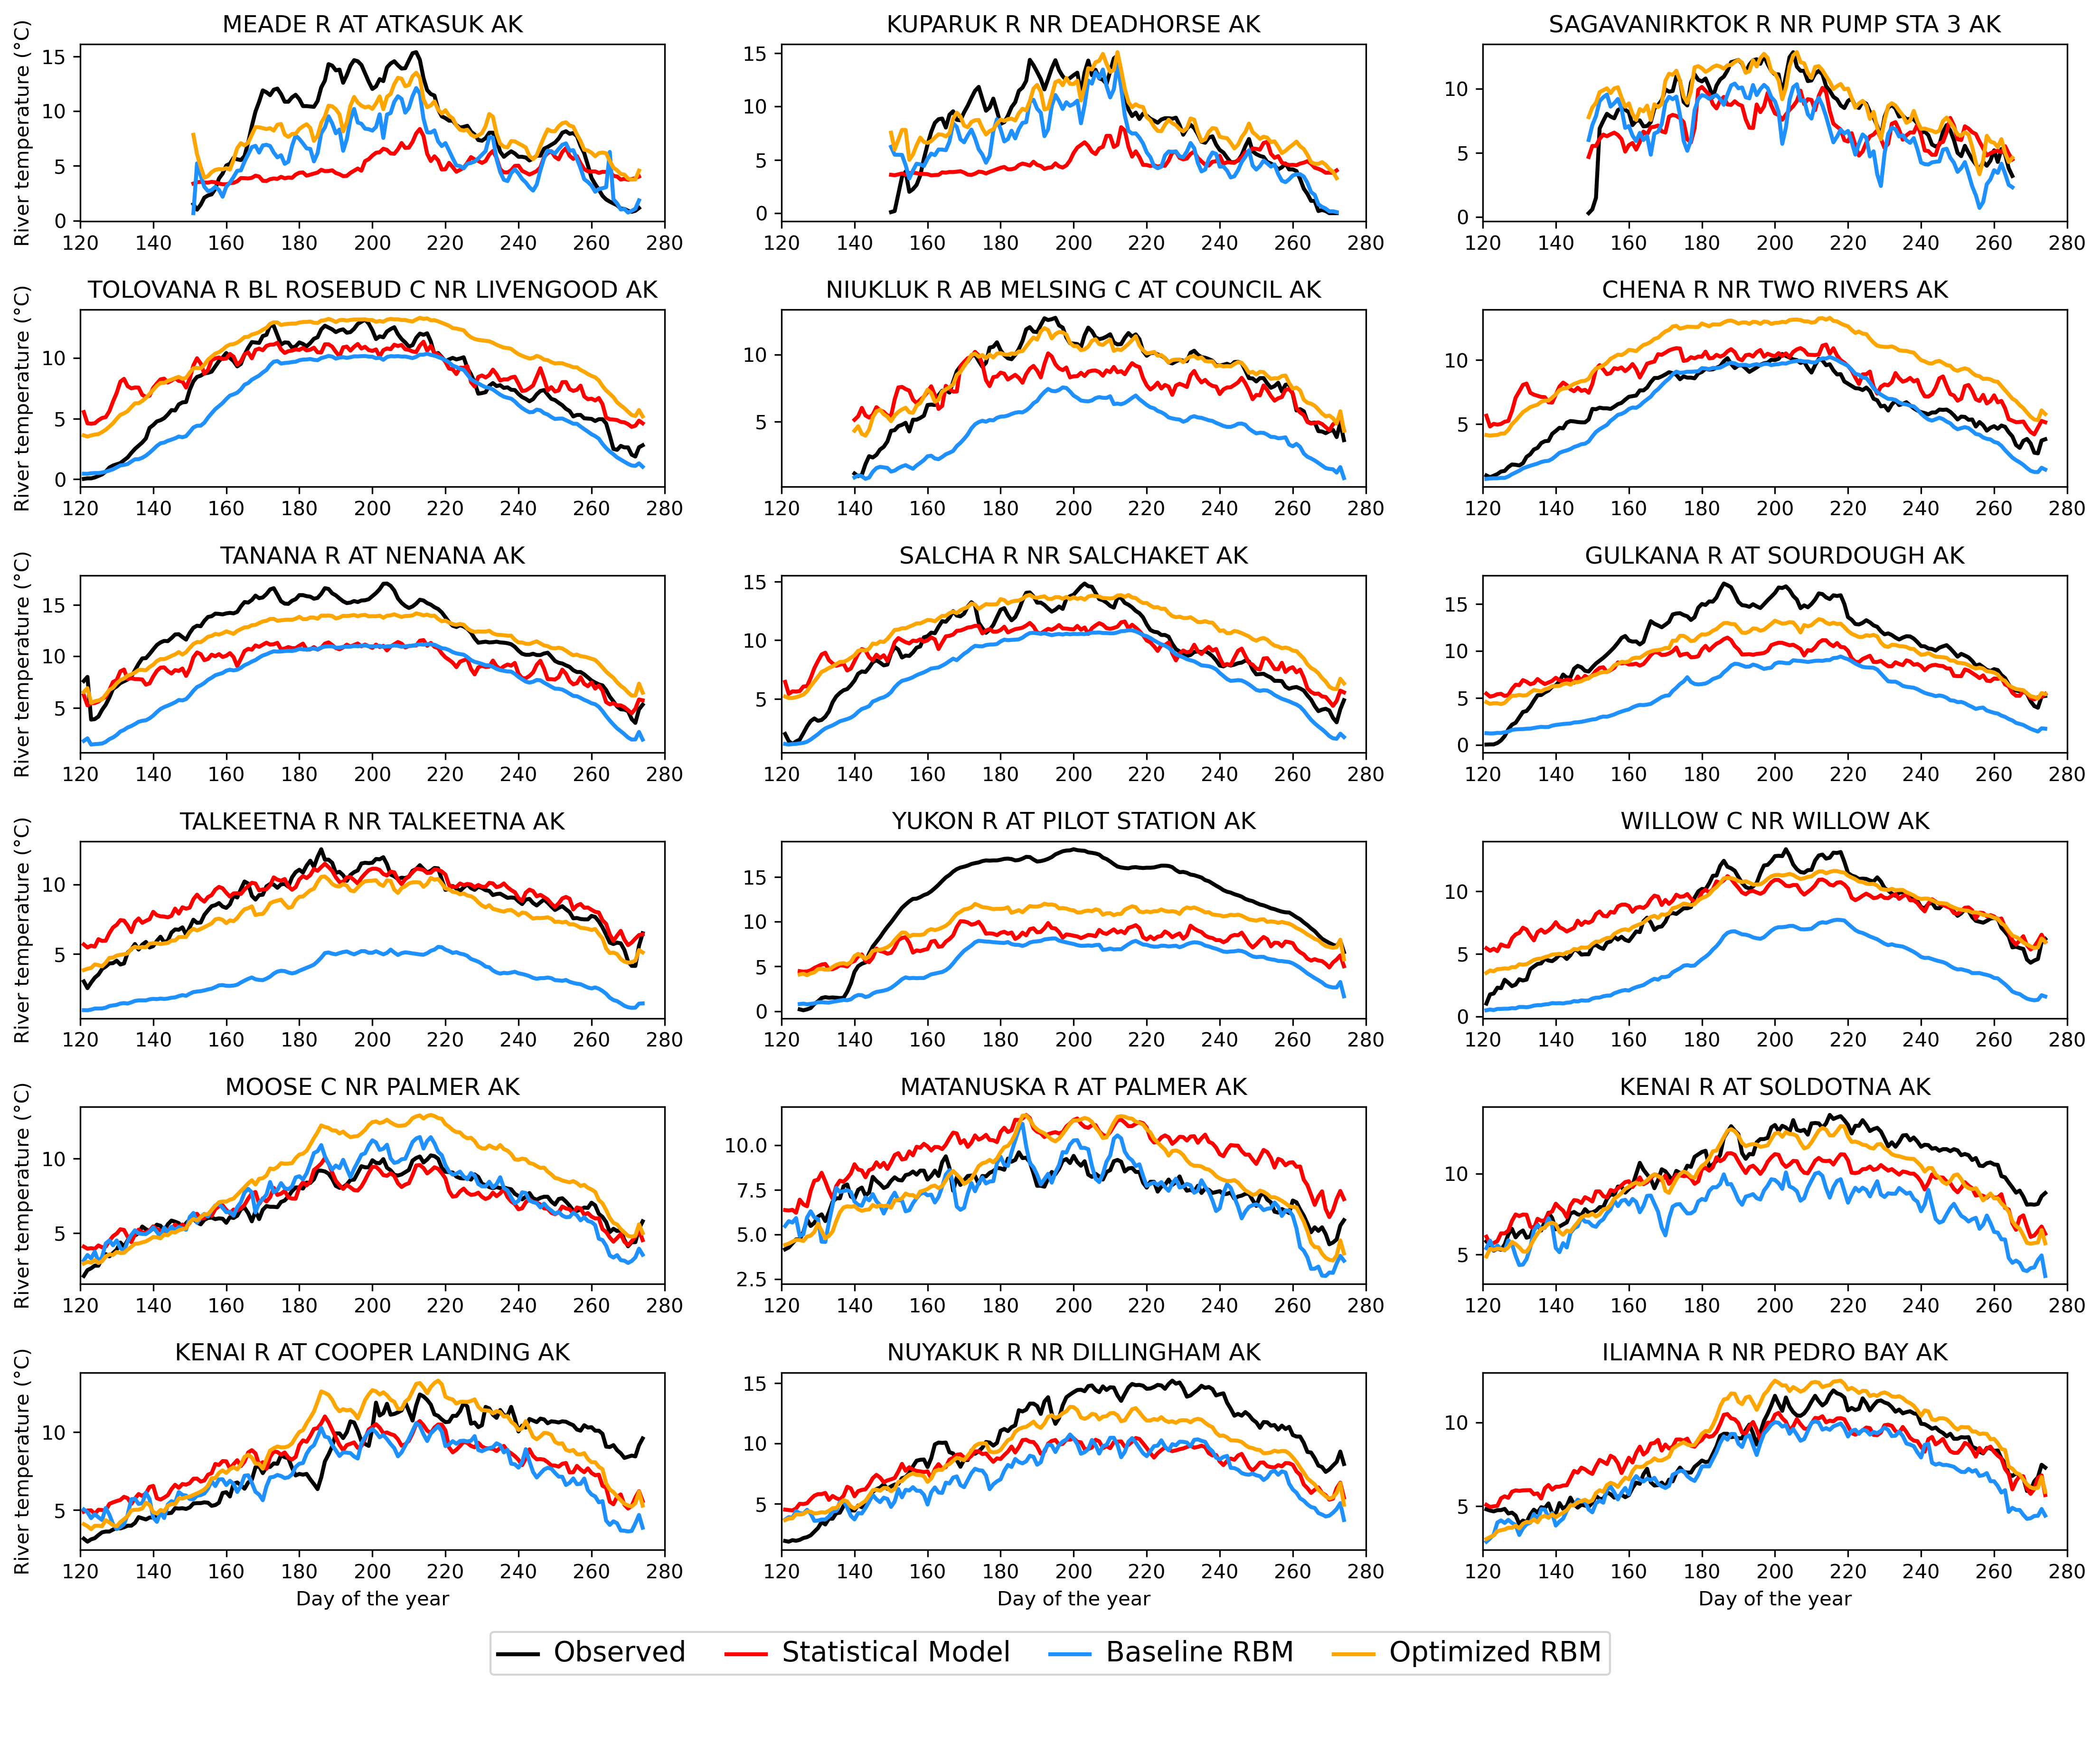

In [179]:
fig,ax = plt.subplots(6, 3,figsize=[18,14],dpi=300)

for i_param, comid in enumerate(np.unique(test.COMID.values)):
    plot_df_comid = test[test["COMID"]==comid]
    plot_df_opt = plot_df_comid[plot_df_comid['type'] == 'Optimized_loc']
    plot_df_base = plot_df_comid[plot_df_comid['type'] == 'Baseline_loc']
    RA = pd.read_csv('/glade/scratch/dblaskey/RBM/Regression/Val/%s.csv'%(comid))
    RA = RA.set_index('Date')
    RA = RA.rename(columns={"sim": "mosh"})
    RA.index = pd.to_datetime(RA.index)
    RA['DOY'] = RA.index.dayofyear
    RA = RA.loc['2017-10-01':'2021-09-30']
    RA = RA[RA.index.month.isin([5,6,7,8,9])]
    RA_ave = RA.groupby(['DOY']).mean().reset_index()
    plot_df_opt=plot_df_opt.merge(RA_ave)
    
    col = i_param %3
    row = int(np.floor(i_param/3))

    ax[row,col].plot(plot_df_base.DOY.values, plot_df_base['obs'].values, lw=2, c='black', label = "Observed")
    ax[row,col].plot(plot_df_opt.DOY.values, plot_df_opt['mosh'].values, lw=2, c='red', label = "Statistical Model")
    ax[row,col].plot(plot_df_base.DOY.values, plot_df_base['sim'].values, lw=2, c='dodgerblue', label = "Baseline RBM")
    ax[row,col].plot(plot_df_opt.DOY.values, plot_df_opt['sim'].values, lw=2, c='orange', label = "Optimized RBM")
    #ax[row,col].set_ylim(0,20)
    ax[row,col].set_xlim(120,280)
    
    title = basins_df.station_nm.values[i_param]
    
    ax[row,col].set_title("%s"%title) 
    xmin,xmax = ax[row,col].get_xlim()
    ymin,ymax = ax[row,col].get_ylim()
    if col == 0:
        ax[row,col].set_ylabel('River temperature (°C)')
    if row == 5:
        ax[row,col].set_xlabel('Day of the year')
    
fig.subplots_adjust(hspace=0.5)

# Move the legend below the figure
handles, labels = ax[0, 0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower center', ncol=4, borderaxespad=3.5)

# Increase the font size of the legend
font_size = 14
for text in legend.get_texts():
    text.set_fontsize(font_size)
for line in legend.get_lines():
    line.set_linewidth(2)

plt.savefig("/glade/u/home/dblaskey/RBM/Validation/Daily_Temp_Lines.png", dpi='figure')

In [113]:
locs_df = pd.read_csv('/glade/u/home/dblaskey/RBM/Optimization/Opt_Basins.csv')
locs_df = locs_df[['outlet_comid', 'Location', 'type']] 
locs_df

outlet_comid  Location type
0       81000005     North  Opt
1       81000402     North  Val
2       81000433     North  Opt
3       81020021  Interior  Val
4       81014324  Interior  Val
5       81020021  Interior  Val
6       81015538  Interior  Opt
7       81015621  Interior  Opt
8       81030789  Interior  Opt
9       81027459     South  Val
10      81020021  Interior  Val
11      81027459     South  Opt
12      81027546     South  Val
13      81027546     South  Opt
14      81030912     South  Opt
15      81030912     South  Val
16      81035777     South  Val
17      81035794     South  Opt

In [180]:
locs_df = pd.read_csv('/glade/u/home/dblaskey/RBM/Production_Runs/AK_outlets.csv')
locs_df = locs_df[['Location', 'COMID']]
grouped_df = val_results_opt.groupby('outlet_id').RMSE.mean().reset_index()

In [181]:
# Create an empty GeoDataFrame
outline_gdf = gpd.GeoDataFrame()

# Iterate through each basin
for comid in grouped_df.outlet_id.values:
    shape_file = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/subbasin_{}.gpkg'.format(comid))
    
    # Extract the outline (exterior) of the shapefile
    outline = shape_file.exterior[0]
    
    # Append the outline to the GeoDataFrame
    outline_gdf = outline_gdf.append({'geometry': outline}, ignore_index=True)

outline_gdf['COMID'] = grouped_df['outlet_id']

from pyproj import CRS

# Define the desired CRS
target_crs = CRS.from_epsg(4326)

# Set the CRS for outline_gdf.geometry
outline_gdf.geometry.crs = target_crs

# Perform the coordinate transformation
outline_gdf = outline_gdf.to_crs(target_crs)

# Combine
grouped_df = grouped_df.rename(columns={"outlet_id": "COMID"})
#locs_df = locs_df.rename(columns={"outlet_comid": "COMID"})
outline_gdf = outline_gdf.merge(grouped_df)
outline_gdf = outline_gdf.merge(locs_df)
outline_gdf = outline_gdf.drop_duplicates()

In [116]:
outline_gdf

geometry     COMID      RMSE  \
0   LINEARRING (-157.26042 69.52625, -157.26042 69...  81000005  2.643331   
1   LINEARRING (-149.24458 68.56708, -149.24125 68...  81000402  2.464168   
2   LINEARRING (-148.32375 68.34375, -148.32375 68...  81000433  1.651900   
3   LINEARRING (-164.66625 64.83292, -164.66208 64...  81014324  1.380485   
4   LINEARRING (-133.99708 59.01708, -133.99792 59...  81020021  3.060683   
7   LINEARRING (-151.38292 61.47542, -151.38458 61...  81027459  1.275889   
9   LINEARRING (-148.27208 61.17208, -148.27292 61...  81027546  2.044389   
11  LINEARRING (-140.95792 60.34792, -140.95875 60...  81030789  2.521562   
12  LINEARRING (-149.84625 60.24958, -149.84375 60...  81030912  1.889986   
14  LINEARRING (-157.77625 58.75958, -157.77625 58...  81035777  2.155740   
15  LINEARRING (-154.72875 58.78875, -154.72875 58...  81035794  1.442677   

    Location  
0      North  
1      North  
2      North  
3   Interior  
4   Interior  
7      South  
9      South  
11  Interior  
12     South  
14     South  
15     South

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor r

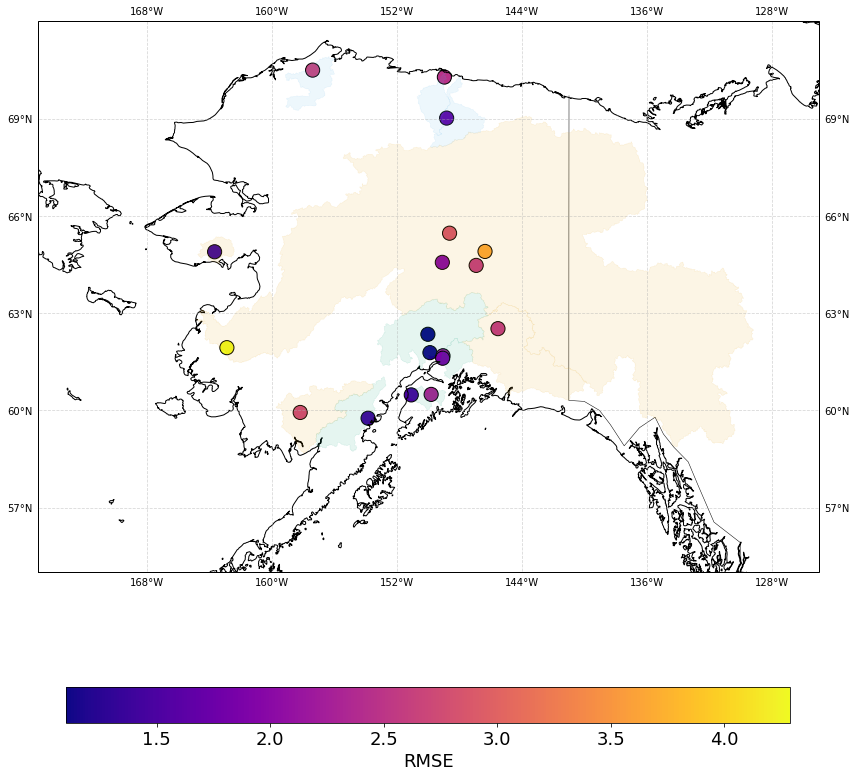

In [182]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Rest of your code...

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Create a GeoDataFrame with a single Polygon representing the entire map extent
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
map_extent = world.unary_union
map_extent_gdf = gpd.GeoDataFrame(geometry=[map_extent], crs=outline_gdf.crs)

group_shp = outline_gdf.groupby('Location')
for name, group in group_shp:
    if name == 'North':
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#56B4E9", edgecolor='#56B4E9')
    elif name == 'Interior':
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#E69F00", edgecolor='#E69F00')
    else:
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#009E73", edgecolor='#009E73')
# Plot shape files
#outline_gdf.geometry.plot(linewidth=0.4, ax=ax, alpha=0.9, edgecolor="grey")

# Set map extent
ax.set_xlim([-175, -125])
ax.set_ylim([55, 72])

# Draw coastlines
ax.coastlines(resolution='10m')

# Add political boundaries
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=0.5)
gl.xlocator = plt.MaxNLocator(7)
gl.ylocator = plt.MaxNLocator(6)

# Set axis label size and format
ax.tick_params(axis='both', labelsize=14)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Scatter plot
points = ax.scatter(val_results_opt.Long, val_results_opt.Lat, c=val_results_opt.RMSE, s=200, cmap="plasma", alpha=1, edgecolor='black')
cbar = fig.colorbar(points, orientation="horizontal", fraction=0.037*18/14) 
cbar.set_label(label='RMSE', size=18)
cbar.ax.tick_params(labelsize=18)

plt.savefig('/glade/u/home/dblaskey/RBM/Production_Runs/Figures/results_geographic.png', dpi=300)
plt.show()

In [128]:
basins

index   site_no                               station_nm        Lat  \
0       0  15803000                    MEADE R AT ATKASUK AK  70.495376   
1       1  15896000                KUPARUK R NR DEADHORSE AK  70.281385   
2       2  15908000         SAGAVANIRKTOK R NR PUMP STA 3 AK  69.015833   
3       3  15519100  TOLOVANA R BL ROSEBUD C NR LIVENGOOD AK  65.464841   
4       4  15580095     NIUKLUK R AB MELSING C AT COUNCIL AK  64.891944   
5       5  15493000                 CHENA R NR TWO RIVERS AK  64.901972   
6       6  15515500                    TANANA R AT NENANA AK  64.564944   
7       7  15484000                 SALCHA R NR SALCHAKET AK  64.471528   
8       8  15200280                GULKANA R AT SOURDOUGH AK  62.520392   
9       9  15292700              TALKEETNA R NR TALKEETNA AK  62.346439   
10     10  15565447              YUKON R AT PILOT STATION AK  61.933687   
11     11  15294005                    WILLOW C NR WILLOW AK  61.780303   
12     12  15283700                     MOOSE C NR PALMER AK  61.684389   
13     13  15284000                 MATANUSKA R AT PALMER AK  61.608631   
14     14  15266300                   KENAI R AT SOLDOTNA AK  60.476929   
15     15  15258000             KENAI R AT COOPER LANDING AK  60.492193   
16     16  15302000               NUYAKUK R NR DILLINGHAM AK  59.934830   
17     17  15300300                ILIAMNA R NR PEDRO BAY AK  59.757950   

          Long     COMID  outlet_comid type  Location  
0  -157.395848  81000092      81000005   OB     North  
1  -148.962786  81000403      81000402   VB     North  
2  -148.817778  81002548      81000433   OB     North  
3  -148.631114  81012001      81020021   VG  Interior  
4  -163.670000  81014331      81014324   VB  Interior  
5  -146.361333  81014458      81020021   VG  Interior  
6  -149.094000  81015538      81020021   OG  Interior  
7  -146.928056  81015621      81020021   OG  Interior  
8  -145.533015  81023679      81030789   OB  Interior  
9  -150.019201  81023793      81027459   VG     South  
10 -162.882936  81025423      81020021   VG  Interior  
11 -149.886679  81026220      81027459   OG     South  
12 -149.052417  81026903      81027546   VG     South  
13 -149.073043  81027556      81027546   OG     South  
14 -151.081668  81030914      81030912   OG     South  
15 -149.809920  81030990      81030912   VG     South  
16 -158.190006  81034003      81035777   VB     South  
17 -153.846887  81034272      81035794   OB     South

In [142]:
basins = pd.read_csv('/glade/u/home/dblaskey/RBM/Validation/Val_Basins.csv')
basins = basins.reset_index()

# Create an empty GeoDataFrame
outline_gdf = gpd.GeoDataFrame()

# Iterate through each basin
for comid in basins.outlet_comid.values:
    shape_file = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/subbasin_{}.gpkg'.format(comid))
    
    # Extract the outline (exterior) of the shapefile
    outline = shape_file.exterior[0]
    
    # Append the outline to the GeoDataFrame
    outline_gdf = outline_gdf.append({'geometry': outline}, ignore_index=True)

outline_gdf['COMID'] = basins['outlet_comid']

from pyproj import CRS

# Define the desired CRS
target_crs = CRS.from_epsg(4326)

# Set the CRS for outline_gdf.geometry
outline_gdf.geometry.crs = target_crs

# Perform the coordinate transformation
outline_gdf = outline_gdf.to_crs(target_crs)

# Combine
grouped_df = basins[['outlet_comid', 'Location']].rename(columns={"outlet_comid": "COMID"})
#locs_df = locs_df.rename(columns={"outlet_comid": "COMID"})
outline_gdf = outline_gdf.merge(grouped_df)
#outline_gdf = outline_gdf.merge(locs_df)
outline_gdf = outline_gdf.drop_duplicates()

In [143]:
outline_gdf

geometry     COMID  Location
0   LINEARRING (-157.26042 69.52625, -157.26042 69...  81000005     North
1   LINEARRING (-149.24458 68.56708, -149.24125 68...  81000402     North
2   LINEARRING (-148.32375 68.34375, -148.32375 68...  81000433     North
3   LINEARRING (-133.99708 59.01708, -133.99792 59...  81020021  Interior
28  LINEARRING (-164.66625 64.83292, -164.66208 64...  81014324  Interior
29  LINEARRING (-140.95792 60.34792, -140.95875 60...  81030789  Interior
30  LINEARRING (-151.38292 61.47542, -151.38458 61...  81027459     South
34  LINEARRING (-148.27208 61.17208, -148.27292 61...  81027546     South
38  LINEARRING (-149.84625 60.24958, -149.84375 60...  81030912     South
42  LINEARRING (-157.77625 58.75958, -157.77625 58...  81035777  Interior
43  LINEARRING (-154.72875 58.78875, -154.72875 58...  81035794     South

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor r

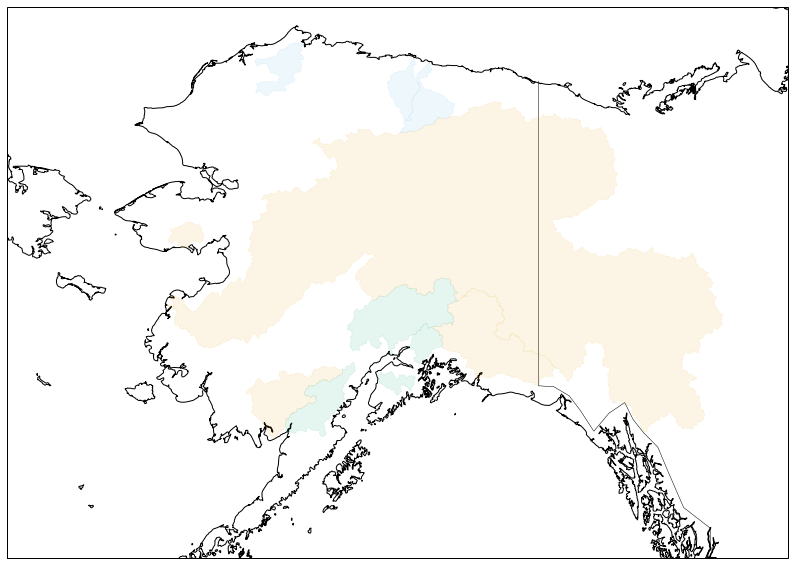

In [136]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Rest of your code...

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Create a GeoDataFrame with a single Polygon representing the entire map extent
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
map_extent = world.unary_union
map_extent_gdf = gpd.GeoDataFrame(geometry=[map_extent], crs=outline_gdf.crs)

group_shp = outline_gdf.groupby('Location')
for name, group in group_shp:
    if name == 'North':
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#56B4E9", edgecolor='#56B4E9')
    elif name == 'Interior':
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#E69F00", edgecolor='#E69F00')
    else:
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#009E73", edgecolor='#009E73')
# Plot shape files
#outline_gdf.geometry.plot(linewidth=0.4, ax=ax, alpha=0.9, edgecolor="grey")

# Set map extent
ax.set_xlim([-175, -125])
ax.set_ylim([55, 72])

# Draw coastlines
ax.coastlines(resolution='10m')

# Add political boundaries
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')

In [138]:
basins

index        Lat        Long     COMID Location
0        0  70.833034 -155.422682  81000004    North
1        1  70.837255 -156.015633  81000005    North
2        2  70.915635 -156.113898  81000011    North
3        3  71.150743 -156.243935  81000028    North
4        4  70.441231 -150.483028  81000069    North
..     ...        ...         ...       ...      ...
133    133  58.250652 -157.315567  81036473    South
134    134  58.033862 -154.941147  81036498    South
135    135  69.816346 -142.164601  82000054    North
136    136  69.674101 -141.819274  82000070    North
137    137  69.800654 -142.090851  82000077    North

[138 rows x 5 columns]

/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/glade/u/home/dblaskey/miniconda3/envs/py3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor r

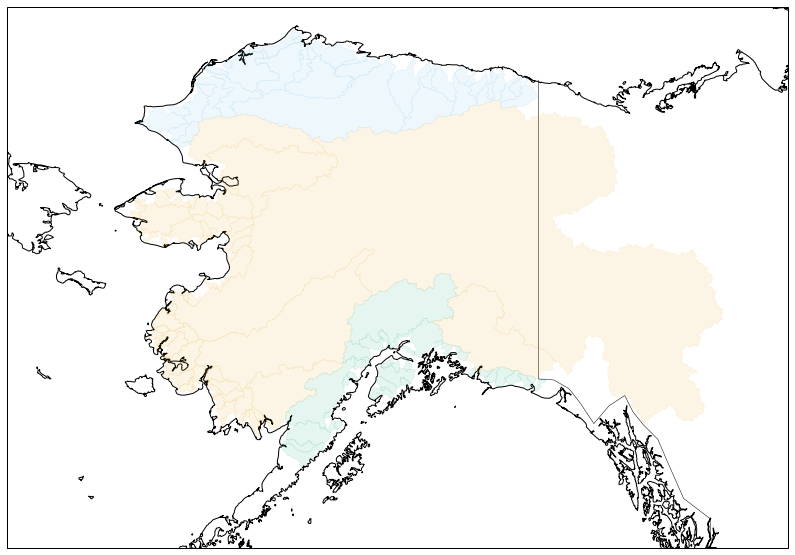

In [144]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

basins = pd.read_csv('/glade/u/home/dblaskey/RBM/Production_Runs/AK_outlets2.csv')

# Create an empty GeoDataFrame
outline_gdf = gpd.GeoDataFrame()

# Iterate through each basin
for comid in basins.COMID.values:
    shape_file = gpd.read_file('/glade/u/home/dblaskey/RBM/Production_Runs/Shapefiles/subbasin_{}.gpkg'.format(comid))
    
    # Extract the outline (exterior) of the shapefile
    outline = shape_file.exterior[0]
    
    # Append the outline to the GeoDataFrame
    outline_gdf = outline_gdf.append({'geometry': outline}, ignore_index=True)

outline_gdf['COMID'] = basins['COMID']

from pyproj import CRS

# Define the desired CRS
target_crs = CRS.from_epsg(4326)

# Set the CRS for outline_gdf.geometry
outline_gdf.geometry.crs = target_crs

# Perform the coordinate transformation
outline_gdf = outline_gdf.to_crs(target_crs)

# Combine
grouped_df = basins[['COMID', 'Location']]
#locs_df = locs_df.rename(columns={"outlet_comid": "COMID"})
outline_gdf = outline_gdf.merge(grouped_df)
#outline_gdf = outline_gdf.merge(locs_df)
outline_gdf = outline_gdf.drop_duplicates()

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Create a GeoDataFrame with a single Polygon representing the entire map extent
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
map_extent = world.unary_union
map_extent_gdf = gpd.GeoDataFrame(geometry=[map_extent], crs=outline_gdf.crs)

group_shp = outline_gdf.groupby('Location')
for name, group in group_shp:
    if name == 'North':
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#56B4E9", edgecolor='#56B4E9')
    elif name == 'Interior':
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#E69F00", edgecolor='#E69F00')
    else:
        group.plot(linewidth=0.4, ax=ax, alpha=0.1, facecolor="#009E73", edgecolor='#009E73')
# Plot shape files
#outline_gdf.geometry.plot(linewidth=0.4, ax=ax, alpha=0.9, edgecolor="grey")

# Set map extent
ax.set_xlim([-175, -125])
ax.set_ylim([55, 72])

# Draw coastlines
ax.coastlines(resolution='10m')

# Add political boundaries
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')

In [145]:
basins = pd.read_csv('/glade/u/home/dblaskey/RBM/Production_Runs/AK_outlets2.csv')
basins2 = pd.read_csv('/glade/u/home/dblaskey/RBM/Production_Runs/AK_outlets.csv')

In [158]:
locs = basins[['COMID', 'Location']].merge(basins2[['COMID', 'Location']], on='COMID', how='outer')
locs['Samesies'] = np.where(locs.Location_x == locs.Location_y, 'True', 'False')
locs = locs[locs['Samesies'] == 'False']
locs

COMID Location_x Location_y Samesies
88   81030789   Interior      South    False
120  81035794      South   Interior    False
130  81036242      South   Interior    False
132  81036460      South   Interior    False
133  81036473      South   Interior    False